# Hierarchical MCMC for Polynomial Hyperelastic Model

## Data after Compression

## Initialize  FE

I will first run an optimization in order to specify the priors knowledge.
The model below is aversion of MacroModel which is ready for the oprimazation

Run the optimazation with starting points of the parameters [20,20,20,20]. 

In [4]:
from scipy.optimize import curve_fit
popt,pcov = curve_fit(model,delta,data)

In [6]:
popt# for full polynomial n=2

array([ 0.01134284,  0.20141702, -0.17296894,  0.20061989,  0.09582912,
        0.07282012,  0.13111464])

# Combined Compression and Shear test 

# Optimazation 

## Hierarchical model

In [1]:
from fenics import *

from numpy import where

import numpy as np

import matplotlib.pyplot as plt
import random as rnd
###############################################################################
from smt.sampling_methods import LHS
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy
from emukit.quadrature.kernels.integration_measures import IsotropicGaussianMeasure
from emukit.quadrature.kernels import QuadratureRBFIsoGaussMeasure
from emukit.quadrature.methods.vanilla_bq import VanillaBayesianQuadrature
import GPy
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import math
from emukit.core.loop.user_function import UserFunctionWrapper
import random as rnd
import seaborn as sns
from typing import Tuple, List, Optional
from scipy.stats import norm
import _pickle as cPickle


# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

In [2]:
class MacroModel():

    def __init__(self, N = 5):

        self.mesh = UnitCubeMesh(N, N, N)

        self.V = VectorFunctionSpace(self.mesh, "Lagrange", 1)
        
        self.loadSteps = 10   # cube [1,1,1] is pressed by 0.2 on top
        self.delta = 0.02
        self.N_MC = 30
        self.verbosity = True

        # Find the top and bottom of my domain
        self.top =  CompiledSubDomain("near(x[2], side) && on_boundary", side = 1.0)
        self.bottom = CompiledSubDomain("near(x[2], side) && on_boundary", side = 0.0)
        self.c = Constant((0.0, 0.0, 0.0))
        self.bc_bottom = DirichletBC(self.V, self.c, self.bottom) #boundary for bottom face = fixed

        # Find dofs on top face
        #ff = MeshFunction("size_t",mesh, mesh.topology().dim()-1, 0)
        #top.mark(ff, 1)
        self.vv = Function(self.V)
        self.bc = DirichletBC(self.V, Constant((0.0, 0.0, 1.0)), self.top)
        self.bc.apply(self.vv.vector())
        self.top_dofs = where(self.vv.vector()==1.0)[0]

    def setData(self, data_comp,data_shear, sigma_f):
        self.data_comp = data_comp
        self.data_shear = data_shear
        self.sigma_f = sigma_f
        self.J = len(data_comp)


    def apply_press(self, data, param, plotSolution = False, solutionFileName = "solution"):
        print(param)
        ## Unwrap parameters

        C01 = param[0]
        C10 = param[1]
        C11 = param[2]
        D1 = param[3]

        # Define functions
        du = TrialFunction(self.V)            # Incremental displacement
        v  = TestFunction(self.V)             # Test function
        u  = Function(self.V)                 # Displacement from previous iteration

        # Kinematics
        d = u.geometric_dimension()
        I = Identity(d)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        C = F.T*F                   # Right Cauchy-Green tensor

        # Invariants of deformation tensors
        I1 = tr(C)
        J  = det(F)

        I2 = 0.5 * ( I1**2 - tr(C * C))

        barI1 = J**(-2./3.) * I1

        barI2 = J**(-4./3.) * I2
        
        #C01 = 4.03038e-09
        #C10 = 0.214722
        #C11 = -0.0215579
        ##C11 = 0
        #D1 = 0.209308
        #D1 = 0.05
        
        # Stored strain energy density (compressible neo-Hookean model)
        psi = C10 * (barI1 - 3.)  + C01 * (barI2 - 3.) + C11 * (barI1 - 3.) * (barI2 - 3.) + D1 * (J - 1.)**2

        # Total potential energy
        Pi = psi * dx

        # Compute first variation of Pi (directional derivative about u in the direction of v)
        F = derivative(Pi, u, v)

        # Compute Jacobian of F
        J = derivative(F, u, du)

        # Loading loop
        Force=[]
        for i in range(1, self.loadSteps + 1):

                    if(self.verbosity):
                        print("Load step - " + str(i))

                    # Update non-homogeneous boundary condition for current load step
                    r = Constant((0.0, 0.0, -i * self.delta))
                    bc_top = DirichletBC(self.V, r, self.top)
                    bcs = [self.bc_bottom, bc_top]

                    # Solve variational problem
                    solve(F == 0, u, bcs, J=J)

                    # Save solution in VTK format
                    if(plotSolution):
                        file = File(solutionFileName + str(i) + ".pvd");
                        file << u;

                    # Output forces
                    y = assemble(F)
                    Force_top = 0
                    for i in self.top_dofs:
                        Force_top += y[i]

                    print(Force_top)
                    Force.append(Force_top)

        #
        assert len(Force) == len(data), "Force list not same length as data list"

        misfit_press = np.sum((np.asarray(Force) - np.asarray(data))**2)
        return misfit_press
    
    def apply_shear(self, data, param, plotSolution = False, solutionFileName = "solution"):

        ## Unwrap parameters

        C01 = param[0]
        C10 = param[1]
        C11 = param[2]
        D1 = param[3]

        # Define functions
        du = TrialFunction(self.V)            # Incremental displacement
        v  = TestFunction(self.V)             # Test function
        u  = Function(self.V)                 # Displacement from previous iteration

        # Kinematics
        d = u.geometric_dimension()
        I = Identity(d)             # Identity tensor
        F = I + grad(u)             # Deformation gradient
        C = F.T*F                   # Right Cauchy-Green tensor

        # Invariants of deformation tensors
        I1 = tr(C)
        J  = det(F)

        I2 = 0.5 * ( I1**2 - tr(C * C))

        barI1 = J**(-2./3.) * I1

        barI2 = J**(-4./3.) * I2
        
        #C01 = 4.03038e-09
        #C10 = 0.214722
        #C11 = -0.0215579
        #C11 = 0
        #D1 = 0.209308
        #D1 = 0.05
        # Stored strain energy density (compressible neo-Hookean model)
        psi = C10 * (barI1 - 3.)  + C01 * (barI2 - 3.) + C11 * (barI1 - 3.) * (barI2 - 3.) + D1 * (J - 1.)**2

        # Total potential energy
        Pi = psi * dx

        # Compute first variation of Pi (directional derivative about u in the direction of v)
        F = derivative(Pi, u, v)

        # Compute Jacobian of F
        J = derivative(F, u, du)

        # Loading loop
        Force=[]
        for i in range(1, self.loadSteps + 1):

                    if(self.verbosity):
                        print("Load step - " + str(i))

                    # Update non-homogeneous boundary condition for current load step
                    r = Constant((i * self.delta, 0.0, 0.0))
                    bc_top = DirichletBC(self.V, r, self.top)
                    bcs = [self.bc_bottom, bc_top]

                    # Solve variational problem
                    solve(F == 0, u, bcs, J=J)

                    # Save solution in VTK format
                    if(plotSolution):
                        file = File(solutionFileName + str(i) + ".pvd");
                        file << u;

                    # Output forces
                    y = assemble(F)
                    Force_top = 0
                    for i in self.top_dofs:
                        Force_top += y[i]

                    print(Force_top)
                    Force.append(Force_top)

        #
        assert len(Force) == len(data), "Force list not same length as data list"

        misfit_shear = np.sum((np.asarray(Force) - np.asarray(data))**2)
        return misfit_shear
    
    def evaluateDensity(self, misfit_press,misfit_shear):
        return -0.5 * (misfit_press + misfit_shear)/ (self.sigma_f**2)
###############################################################################
    def fem(self) -> Tuple[UserFunctionWrapper, List[Tuple[float, float]]]:
        
        integral_bound = [(1,15),(0.2,0.4)]
        return UserFunctionWrapper(self._fem), integral_bound

    def _fem(self, data_comp, data_shear, param:np.ndarray) -> np.ndarray:
        #log_Likelihood_press = self.apply_press(data_comp, param)
        #log_Likelihood_shear = self.apply_shear(data_shear,param)
        #log_Likelihood = log_Likelihood_press + log_Likelihood_shear
        misfit_press = self.apply_press(data_comp, param)
        misfit_shear = self.apply_shear(data_shear,param)
        log_Likelihood = np.exp(self.evaluateDensity(misfit_press, misfit_shear))  #fix the name logLike-> Likelihood 
        return np.reshape(np.array(log_Likelihood),(-1,1))
    
###############################################################################
    def singleGP(self, data_comp, data_shear):         #for polynomial Mooney Rivlin
        #########################################
        # C01 C10 C11 D1 = param
        #xlimits = np.array([[0,0.01],[0.1,0.21], [-0.001,0.01],[0.1,0.21]])   # good 105
        #xlimits = np.array([[0,0.01],[0,0.21], [-0.001,0.01],[0,0.21]])   # good 67 variance and 300 samples
        
        # C01 C10 D1 = param   , C11 = 0
        #xlimits = np.array([[0,0.1],[0,0.5],[0,0.1]])     # variance 157  with C11 = 0  
        #xlimits = np.array([[0,0.1],[0,0.5],[0,0.1]])
        
        #xlimits = np.array([[0,1],[0,1],[0,1],[0,5]])
        xlimits = np.array([[0,0.1],[0,0.5],[0,0.1],[0,0.5]])
        sampling = LHS(xlimits=xlimits)

        train_number =1000 #100#300 #1000
        theta = sampling(train_number)  
        self.validate_number = int(20/100 * train_number)
        ########################################
        
        self.X_init=np.zeros((train_number,4))
        #self.X_init=np.zeros((train_number,3))
        Y=[]
        for i in range(0,train_number):                #initial points to GP 
                function_input=theta[i]
                self.X_init[i]=theta[i]
                Y_= np.reshape(user_function.f(data_comp, data_shear, function_input),(-1,1))
                Y.append(Y_)
            
        self.Y_init=np.reshape(np.array(Y),(-1,1))

        #gpy_model = GPy.models.GPRegression(X=self.X_init, Y=self.Y_init,kernel=GPy.kern.Matern52(input_dim=self.X_init.shape[1], ARD=False))  
        #gpy_model = GPy.models.GPRegression(X=self.X_init, Y=self.Y_init,kernel=GPy.kern.RBF(input_dim=self.X_init.shape[1], ARD=True))
        gpy_model = GPy.models.GPRegression(X=self.X_init[self.validate_number:], Y=self.Y_init[self.validate_number:],kernel=GPy.kern.RBF(input_dim=self.X_init.shape[1], ARD=True))

        gpy_model.optimize(messages=True)
        gpy_model.optimize_restarts(num_restarts = 3)

        return gpy_model
    
  
    def trainAll(self):
        
        self.GPs=[]
        
        for j in range(0,self.J):
        #for j in range(0,1):                  #CHANGE
            GP=self.singleGP(self.data_comp[j],self.data_shear[j])
            self.GPs.append(GP)
        return self.GPs  

#################################################################################################################
    def theta_given_phi(self, phi, theta):
        return norm.logpdf(theta[0], loc=phi[0], scale=phi[1]) + norm.logpdf(theta[1], loc=phi[2], scale=phi[3]) + norm.logpdf(theta[2], loc=phi[4], scale=phi[5]) + norm.logpdf(theta[3], loc=phi[6], scale=phi[7])
        #return norm.logpdf(theta[0], loc=phi[0], scale=phi[1]) + norm.logpdf(theta[1], loc=phi[2], scale=phi[3])+ norm.logpdf(theta[2], loc=phi[4], scale=phi[5])
    def logLike(self,phi):
        ll = 0.0
        for j in range(self.J): # For each experiment
        #for j in range(0,1):                           #PROSOXI NA ALLAXW
            tmp = 0.0
            for i in range(self.N_MC):
                theta =np.array( [np.random.normal(phi[0],phi[1]),np.random.normal(phi[2],phi[3]),np.random.normal(phi[4],phi[5]),np.random.normal(phi[6],phi[7])]) 
                #theta =np.array( [np.random.normal(phi[0],phi[1]),np.random.normal(phi[2],phi[3]),np.random.normal(phi[4],phi[5])]) 
                gp_theta=np.reshape(theta,(1,-1))
                part1 =self.GPs[j].predict(gp_theta) 
                part2  = self.theta_given_phi(phi, theta)                       
                #tmp+=float(part1[0])  + np.log(part2)
                tmp+=float(part1[0])  + part2             # is already log
                #tmp += np.exp(part1[0]) + part2           #TRY THAT       

            if tmp<=0:
                tmp=0.01
            ll += np.log(tmp/self.N_MC)                   #TRY THAT
            #ll += tmp/self.N_MC
        return ll             


In [3]:
oadSteps = 10
delta = 0.02
saveSolution = True
verbosity = True

Data_compression = cPickle.load( open( "CompressionData.p", "rb" ) )
Data_shear = cPickle.load( open( "ShearData.p", "rb" ) )

myModel = MacroModel()
myModel.setData(Data_compression,Data_shear,0.1)

user_function, integral_bounds = myModel.fem()

In [4]:
tr=myModel.trainAll()


[0.05735 0.13575 0.04885 0.23025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019006680660591187
Load step - 2
-0.038862965865608216
Load step - 3
-0.05964968578067151
Load step - 4
-0.08145355390434815
Load step - 5
-0.10436708583585111
Load step - 6
-0.1284883537720444
Load step - 7
-0.15392052929921554
Load step - 8
-0.18077115777431316
Load step - 9
-0.20915109835202775
Load step - 10
-0.23917305640083672
Load step - 1
-5.252335901607241e-05
Load step - 2
-9.717312979565628e-05
Load step - 3
-0.00013523397168053292
Load step - 4
-0.00016813821399602378
Load step - 5
-0.000197465184150707
Load step - 6
-0.00022493763186349187
Load step - 7
-0.0002524153004066731
Load step - 8
-0.00028188577685124214
Load step - 9
-0.00031545282878515756
Load step - 10
-0.0003553225008605432
[0.03125 0.21125 0.08105 0.37075]
Load st

7.521471433976027e-05
Load step - 4
0.00013138182035469525
Load step - 5
0.000201310960446621
Load step - 6
0.00028383073635920847
Load step - 7
0.00037770927582554843
Load step - 8
0.00048166079005647415
Load step - 9
0.0005943536177743962
Load step - 10
0.0007144196074880003
[0.01845 0.48025 0.05715 0.08825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02599038529464044
Load step - 2
-0.05272353297168448
Load step - 3
-0.08026416895623262
Load step - 4
-0.10868867833650735
Load step - 5
-0.13808773869663885
Load step - 6
-0.16856942981092812
Load step - 7
-0.20026284452567858
Load step - 8
-0.23332221224921987
Load step - 9
-0.26793153862480185
Load step - 10
-0.30430977073225784
Load step - 1
1.248330225222559e-05
Load step - 2
-6.254350976672403e-05
Load step - 3
-0.0002261217101660085
Load step - 4
-0.000479333441

-0.1235752657766012
Load step - 6
-0.15228348406381695
Load step - 7
-0.18256758805323264
Load step - 8
-0.21454555607912426
Load step - 9
-0.24834134890410495
Load step - 10
-0.28408409000752116
Load step - 1
-9.792801040953334e-05
Load step - 2
-0.00019380509854238418
Load step - 3
-0.00028890325837423745
Load step - 4
-0.00038454597597912046
Load step - 5
-0.00048210793310360053
Load step - 6
-0.0005830130684853937
Load step - 7
-0.0006887309905175114
Load step - 8
-0.0008007717755499852
Load step - 9
-0.0009206792254202931
Load step - 10
-0.0010500226942359106
[0.02125 0.11725 0.01525 0.36475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.017010366306710142
Load step - 2
-0.034821333210592796
Load step - 3
-0.05351006365723336
Load step - 4
-0.07316178067053407
Load step - 5
-0.09387058639954066
Load step - 6
-0.115

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012612263191652668
Load step - 2
-0.02562578447148481
Load step - 3
-0.03908039352998844
Load step - 4
-0.05302177511225274
Load step - 5
-0.06750307957559142
Load step - 6
-0.08258705122881158
Load step - 7
-0.09834879934177428
Load step - 8
-0.114879339978985
Load step - 9
-0.13229002671971965
Load step - 10
-0.15071796382810101
Load step - 1
8.94733612757599e-06
Load step - 2
-1.800085015316205e-05
Load step - 3
-8.214985535783098e-05
Load step - 4
-0.00018508615540900643
Load step - 5
-0.00032867177504407476
Load step - 6
-0.0005150323466385463
Load step - 7
-0.0007465394848674253
Load step - 8
-0.0010257883206927884
Load step - 9
-0.0013555711675228073
Load step - 10
-0.001738848326006179
[0.05945 0.22625 0.09885 0.31325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.000613485060606759
Load step - 5
-0.000770340585263165
Load step - 6
-0.0009294893114251677
Load step - 7
-0.0010913766263070466
Load step - 8
-0.0012564464762261536
Load step - 9
-0.0014251417457474848
Load step - 10
-0.001597904427345334
[0.05385 0.02625 0.02245 0.36775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011316906021749496
Load step - 2
-0.023404942252103836
Load step - 3
-0.03636810260650483
Load step - 4
-0.05032202646482233
Load step - 5
-0.06539502617829923
Load step - 6
-0.08172916367914881
Load step - 7
-0.09948135618460101
Load step - 8
-0.11882447738201242
Load step - 9
-0.13994840313659393
Load step - 10
-0.16306092914185022
Load step - 1
-0.00016889625888616178
Load step - 2
-0.00034526827295700897
Load step - 3
-0.000529723022119456
Load step - 4
-0.0007228559998353634
Load step - 5
-0.000925

-0.07962356542974551
Load step - 7
-0.09528357658346974
Load step - 8
-0.11185281141488788
Load step - 9
-0.1294430439217877
Load step - 10
-0.1481809139822651
Load step - 1
-2.837193768321876e-05
Load step - 2
-0.00014821908764626308
Load step - 3
-0.0003596913091281146
Load step - 4
-0.0006627852344387915
Load step - 5
-0.0010573539629399815
Load step - 6
-0.0015431154688332548
Load step - 7
-0.002119659487255953
Load step - 8
-0.002786452689339791
Load step - 9
-0.0035428420105207605
Load step - 10
-0.004388056054908208
[0.00075 0.44175 0.03255 0.22225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03264913200744401
Load step - 2
-0.06627970609500498
Load step - 3
-0.1009405647552221
Load step - 4
-0.13668247058458372
Load step - 5
-0.1735581737722041
Load step - 6
-0.2116225880955848
Load step - 7
-0.250933167652974

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.033940911732375977
Load step - 2
-0.06887378230190688
Load step - 3
-0.10484857388151667
Load step - 4
-0.14191940077980159
Load step - 5
-0.18014573031790093
Load step - 6
-0.21959410891848818
Load step - 7
-0.26034061100499994
Load step - 8
-0.3024742558629286
Load step - 9
-0.3461016768905143
Load step - 10
-0.39135334120399057
Load step - 1
4.2902866332132704e-05
Load step - 2
5.049985704566522e-05
Load step - 3
2.0946089231255996e-05
Load step - 4
-4.7717478335776496e-05
Load step - 5
-0.0001575659824156147
Load step - 6
-0.000310787338113986
Load step - 7
-0.0005096736382073854
Load step - 8
-0.0007566073878989852
Load step - 9
-0.001054042839842547
Load step - 10
-0.0014044828313339811
[0.03805 0.39825 0.06685 0.18625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

-6.662079755444467e-05
Load step - 5
5.775513596165881e-05
Load step - 6
0.00023320315776789767
Load step - 7
0.0004566203012860843
Load step - 8
0.0007246728477486196
Load step - 9
0.0010338118592886588
Load step - 10
0.0013802918637139156
[0.04275 0.32525 0.03345 0.39225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03490684092089412
Load step - 2
-0.0711704141433342
Load step - 3
-0.10888619853446796
Load step - 4
-0.14815598309603958
Load step - 5
-0.1890879301063419
Load step - 6
-0.23179649653521395
Load step - 7
-0.2764021576202469
Load step - 8
-0.32303085996865377
Load step - 9
-0.37181311170584724
Load step - 10
-0.4228825946274522
Load step - 1
-6.0189659269244654e-05
Load step - 2
-8.053183152914223e-05
Load step - 3
-6.301657151666228e-05
Load step - 4
-9.814391217119272e-06
Load step - 5
7.67264389273322e

-0.20006612738871568
Load step - 7
-0.23779377022565998
Load step - 8
-0.27692129707025226
Load step - 9
-0.3175050528832354
Load step - 10
-0.3596021215121796
Load step - 1
8.150395927846113e-06
Load step - 2
8.559239948331194e-06
Load step - 3
-5.500913836424743e-07
Load step - 4
-2.10308135595052e-05
Load step - 5
-5.480951591106464e-05
Load step - 6
-0.00010387956711140496
Load step - 7
-0.00017029122892406204
Load step - 8
-0.00025613865192479935
Load step - 9
-0.00036354401006837
Load step - 10
-0.0004946391047293209
[0.08725 0.18475 0.05395 0.05575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014870357206625764
Load step - 2
-0.03022497000759405
Load step - 3
-0.046106010310793914
Load step - 4
-0.06256290307679455
Load step - 5
-0.07965419288565849
Load step - 6
-0.09744984980809399
Load step - 7
-0.1160340689

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016605531847369594
Load step - 2
-0.03390343203761218
Load step - 3
-0.05196071531073667
Load step - 4
-0.07084931367973456
Load step - 5
-0.09064598257089769
Load step - 6
-0.11143206191963226
Load step - 7
-0.13329305426753843
Load step - 8
-0.156317976937043
Load step - 9
-0.1805984424767612
Load step - 10
-0.20622742381894665
Load step - 1
-3.321833454317237e-05
Load step - 2
-5.327276984382237e-05
Load step - 3
-6.132464152979157e-05
Load step - 4
-5.869917914092134e-05
Load step - 5
-4.688435809766295e-05
Load step - 6
-2.7526811822383156e-05
Load step - 7
-2.4248676045904142e-06
Load step - 8
2.6481144324740926e-05
Load step - 9
5.712107920927682e-05
Load step - 10
8.730936518148318e-05
[0.04675 0.10625 0.05295 0.27725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

6.386748737067957e-05
Load step - 5
9.837555852879867e-05
Load step - 6
0.0001329605295834511
Load step - 7
0.00016351023850447156
Load step - 8
0.00018569405559480927
Load step - 9
0.00019499311764110787
Load step - 10
0.00018673561612788368
[0.01945 0.30125 0.05475 0.34825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03058350465698703
Load step - 2
-0.062338995832693755
Load step - 3
-0.09536393754295476
Load step - 4
-0.12976312522309458
Load step - 5
-0.16564879709588234
Load step - 6
-0.20314058561042364
Load step - 7
-0.24236524920901537
Load step - 8
-0.28345610965660606
Load step - 9
-0.32655210361341463
Load step - 10
-0.3717963408758443
Load step - 1
-5.185753317960252e-05
Load step - 2
-6.028667561299971e-05
Load step - 3
-2.7154035329650573e-05
Load step - 4
4.543261836661134e-05
Load step - 5
0.0001551263

-0.10177194290714257
Load step - 6
-0.12591657430513054
Load step - 7
-0.1516430505764356
Load step - 8
-0.17911024917672608
Load step - 9
-0.20848827680457974
Load step - 10
-0.2399579583771278
Load step - 1
-0.00012818671667331482
Load step - 2
-0.0002479457978587658
Load step - 3
-0.00036027093307211154
Load step - 4
-0.0004662268852722437
Load step - 5
-0.0005669513858830529
Load step - 6
-0.0006636556048744569
Load step - 7
-0.0007576231627850807
Load step - 8
-0.0008502076840009592
Load step - 9
-0.0009428289225861166
Load step - 10
-0.0010369675223576326
[0.05455 0.25925 0.07285 0.22525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02618733191369585
Load step - 2
-0.05334210188218273
Load step - 3
-0.08153963251523019
Load step - 4
-0.11085931980930672
Load step - 5
-0.1413843836166791
Load step - 6
-0.173201514

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01286151912386009
Load step - 2
-0.026200059707396105
Load step - 3
-0.04006438804124067
Load step - 4
-0.05450638591735689
Load step - 5
-0.06958085933571578
Load step - 6
-0.08534527353620946
Load step - 7
-0.10185943122376338
Load step - 8
-0.11918513560025185
Load step - 9
-0.1373859218187253
Load step - 10
-0.15652701022348933
Load step - 1
-1.7025257999775644e-06
Load step - 2
4.263853201756143e-06
Load step - 3
1.6751111302826835e-05
Load step - 4
3.438734381913203e-05
Load step - 5
5.558087815619631e-05
Load step - 6
7.852858731479599e-05
Load step - 7
0.00010122812337194667
Load step - 8
0.00012149362909665207
Load step - 9
0.00013697435631925605
Load step - 10
0.000145175531613192
[0.06585 0.31225 0.06725 0.16475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

0.00035828708169652584
Load step - 8
0.0004855084870531613
Load step - 9
0.0006193519179592061
Load step - 10
0.0007550120181520387
[0.06985 0.17525 0.04295 0.09175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016379019193854746
Load step - 2
-0.03329981044507133
Load step - 3
-0.05079590441710965
Load step - 4
-0.06890348478702013
Load step - 5
-0.08766207450519836
Load step - 6
-0.10711554914678975
Load step - 7
-0.12731361470221636
Load step - 8
-0.14831392747653754
Load step - 9
-0.17018507313383915
Load step - 10
-0.19301064863643688
Load step - 1
1.2859387770724581e-05
Load step - 2
-3.60136338227049e-06
Load step - 3
-5.0613468902661055e-05
Load step - 4
-0.0001295437639679435
Load step - 5
-0.0002418926515543921
Load step - 6
-0.00038928802163713187
Load step - 7
-0.0005734752782604419
Load step - 8
-0.0007963

-0.00025317376896629026
Load step - 5
-0.00022647065350308866
Load step - 6
-0.00016880873164584179
Load step - 7
-8.314314438002729e-05
Load step - 8
2.733707601034667e-05
Load step - 9
0.00015922389617753464
Load step - 10
0.00030890856466504356
[0.06875 0.39425 0.07475 0.42475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04187946186226856
Load step - 2
-0.08537157558543222
Load step - 3
-0.1305990779000512
Load step - 4
-0.17769233109452112
Load step - 5
-0.22678911473956462
Load step - 6
-0.27803417586573553
Load step - 7
-0.3315784720499875
Load step - 8
-0.3875780356115387
Load step - 9
-0.4461923883754328
Load step - 10
-0.5075824541746872
Load step - 1
-4.430809572663553e-05
Load step - 2
-5.526737284791106e-05
Load step - 3
-3.559228624157632e-05
Load step - 4
1.1689962249195691e-05
Load step - 5
8.3243342010

-0.09855646871934315
Load step - 7
-0.11799722581640329
Load step - 8
-0.1384502073415278
Load step - 9
-0.1599766314542364
Load step - 10
-0.18263863135432615
Load step - 1
-4.8252370671388465e-05
Load step - 2
-0.000102276439167495
Load step - 3
-0.00016292663333873842
Load step - 4
-0.00023107267390540405
Load step - 5
-0.0003075988103340531
Load step - 6
-0.0003934019631273217
Load step - 7
-0.0004893887793693951
Load step - 8
-0.0005964716372395629
Load step - 9
-0.0007155636627047429
Load step - 10
-0.0008475728466733766
[0.09155 0.02525 0.02715 0.06025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.00875532483550434
Load step - 2
-0.017897302325481104
Load step - 3
-0.027450569409780582
Load step - 4
-0.03744063338913914
Load step - 5
-0.047893930076230655
Load step - 6
-0.05883798223466425
Load step - 7
-0.07030

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02850373946508487
Load step - 2
-0.05782388886273347
Load step - 3
-0.08800707476144722
Load step - 4
-0.11910570757501888
Load step - 5
-0.15117970101372025
Load step - 6
-0.1842987742696866
Load step - 7
-0.21854548768318485
Load step - 8
-0.2540191696670748
Load step - 9
-0.290840879702889
Load step - 10
-0.32915951105984387
Load step - 1
3.3418327709725185e-05
Load step - 2
1.7693683688727697e-05
Load step - 3
-4.8664236332030084e-05
Load step - 4
-0.00016723178859754745
Load step - 5
-0.00033967570019586304
Load step - 6
-0.0005677525459880821
Load step - 7
-0.0008533032863680607
Load step - 8
-0.0011982429097262704
Load step - 9
-0.0016045453659065388
Load step - 10
-0.0020742241135421205
[0.07565 0.30325 0.08795 0.04725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

0.00048789718014679423
Load step - 7
0.0006598258448482112
Load step - 8
0.0008482310582770757
Load step - 9
0.0010491580252890032
Load step - 10
0.0012585124771677001
[0.03685 0.13975 0.08555 0.27275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01877308258588517
Load step - 2
-0.03842639722201129
Load step - 3
-0.059082649636123974
Load step - 4
-0.08087556539189887
Load step - 5
-0.10394961735788226
Load step - 6
-0.1284594451709427
Load step - 7
-0.15456891766470685
Load step - 8
-0.1824497802352506
Load step - 9
-0.21227981757181644
Load step - 10
-0.24424045025002977
Load step - 1
-7.917598299143791e-05
Load step - 2
-0.000138741895405906
Load step - 3
-0.00018001261701978751
Load step - 4
-0.00020453387699254135
Load step - 5
-0.00021408405484880163
Load step - 6
-0.00021067212026203846
Load step - 7
-0.00019653

-1.1518137455963272e-05
Load step - 3
-2.5568534422923812e-05
Load step - 4
-4.7272146045150614e-05
Load step - 5
-7.848952850881923e-05
Load step - 6
-0.0001212844235952727
Load step - 7
-0.0001779105272731277
Load step - 8
-0.0002507944269541204
Load step - 9
-0.00034251525884976665
Load step - 10
-0.00045578172525198037
[0.07135 0.42375 0.08655 0.23925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03609255573621763
Load step - 2
-0.07336124862526482
Load step - 3
-0.11187978726887983
Load step - 4
-0.1517257779901512
Load step - 5
-0.19298108702260144
Load step - 6
-0.23573248070451622
Load step - 7
-0.28007273296298474
Load step - 8
-0.3261024872810571
Load step - 9
-0.37393329534710257
Load step - 10
-0.42369242896857345
Load step - 1
3.22720576687907e-05
Load step - 2
4.9609682614188555e-05
Load step - 3
4.942341

-0.027846618647339616
Load step - 2
-0.056881899111539125
Load step - 3
-0.08724168395106748
Load step - 4
-0.11907614337069249
Load step - 5
-0.15255071606536494
Load step - 6
-0.18784694099090193
Load step - 7
-0.225163116361731
Load step - 8
-0.26471470231316246
Load step - 9
-0.30673435733300936
Load step - 10
-0.35147146396399065
Load step - 1
-0.00014629066405459076
Load step - 2
-0.00023780495395779363
Load step - 3
-0.0002760017032710419
Load step - 4
-0.0002625548283464357
Load step - 5
-0.0001993551207161139
Load step - 6
-8.850943054770363e-05
Load step - 7
6.766280000676571e-05
Load step - 8
0.0002666356369424427
Load step - 9
0.0005056853138125989
Load step - 10
0.0007819013210440706
[0.02845 0.06525 0.00665 0.44725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013275811570879632
Load step - 2
-0.027277453

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021890215596470836
Load step - 2
-0.04468591147142817
Load step - 3
-0.06850665793344048
Load step - 4
-0.09348378863315669
Load step - 5
-0.11976052643773785
Load step - 6
-0.1474918303626522
Load step - 7
-0.1768438965040544
Load step - 8
-0.20799323501857073
Load step - 9
-0.2411252316809963
Load step - 10
-0.2764320874782465
Load step - 1
-7.456448140735717e-05
Load step - 2
-0.00010743885101860565
Load step - 3
-0.0001000676609701903
Load step - 4
-5.4178299682311216e-05
Load step - 5
2.8217938388098703e-05
Load step - 6
0.00014482885672570324
Load step - 7
0.0002930884160303804
Load step - 8
0.0004701677082341104
Load step - 9
0.0006729895870337701
Load step - 10
0.0008982465904777604
[0.02165 0.30625 0.09435 0.43025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-0.0001496217000489053
Load step - 5
-0.0003084421284044326
Load step - 6
-0.000520605045470203
Load step - 7
-0.0007888849331190089
Load step - 8
-0.0011162505384204897
Load step - 9
-0.001505839070890746
Load step - 10
-0.001960925070308607
[0.03255 0.26375 0.06515 0.41025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03045646816941044
Load step - 2
-0.062187149304990134
Load step - 3
-0.09531705930311431
Load step - 4
-0.12998215110698214
Load step - 5
-0.1663296978279931
Load step - 6
-0.20451850023077126
Load step - 7
-0.24471884618546527
Load step - 8
-0.2871121290473175
Load step - 9
-0.33189000645169064
Load step - 10
-0.37925295038511575
Load step - 1
-9.921396106968382e-05
Load step - 2
-0.00015506800193570178
Load step - 3
-0.00016937368734001474
Load step - 4
-0.0001441833122855461
Load step - 5
-8.17897415

-0.13006854243189422
Load step - 8
-0.1532652515283626
Load step - 9
-0.17789923974501812
Load step - 10
-0.2040811079581327
Load step - 1
-0.00010255014802994228
Load step - 2
-0.0002089291060397469
Load step - 3
-0.000319977478996355
Load step - 4
-0.0004365378680672309
Load step - 5
-0.0005594551225529851
Load step - 6
-0.0006895758680771046
Load step - 7
-0.0008277472895959398
Load step - 8
-0.0009748151665849105
Load step - 9
-0.0011316211763274676
Load step - 10
-0.0012989994989566
[0.01705 0.19675 0.07275 0.42175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024314911978186395
Load step - 2
-0.0497232867010626
Load step - 3
-0.07636939348771962
Load step - 4
-0.10441300066880312
Load step - 5
-0.13403007987077573
Load step - 6
-0.16541330028754778
Load step - 7
-0.19877224296584278
Load step - 8
-0.2343332477233

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.026283452992262007
Load step - 2
-0.05334359143872599
Load step - 3
-0.08122663591423816
Load step - 4
-0.10998450759448172
Load step - 5
-0.1396765175391692
Load step - 6
-0.1703716366382554
Load step - 7
-0.20215150024008413
Load step - 8
-0.2351143106272579
Load step - 9
-0.26937979007886736
Load step - 10
-0.3050952987657541
Load step - 1
2.765086441383593e-05
Load step - 2
3.963286992198157e-06
Load step - 3
-7.257499335905587e-05
Load step - 4
-0.00020358764948829455
Load step - 5
-0.00039081261576085933
Load step - 6
-0.000636099850858534
Load step - 7
-0.0009414039690463119
Load step - 8
-0.0013087718456261154
Load step - 9
-0.0017403254504143222
Load step - 10
-0.002238240300986712
[0.09645 0.09625 0.08905 0.16175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-0.0005090967131679842
Load step - 5
-0.0006321614238038761
Load step - 6
-0.0007566842938292549
Load step - 7
-0.000884464276609186
Load step - 8
-0.0010174254531050736
Load step - 9
-0.00115761003262223
Load step - 10
-0.0013071690278587589
[0.01345 0.25575 0.03955 0.17225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021586454024306145
Load step - 2
-0.043890014151442634
Load step - 3
-0.06695700376841786
Load step - 4
-0.09083600744213746
Load step - 5
-0.1155777613917504
Load step - 6
-0.14123500840937092
Load step - 7
-0.16786233722582292
Load step - 8
-0.19551605118410564
Load step - 9
-0.2242541537421679
Load step - 10
-0.2541366091731098
Load step - 1
1.1065039100228199e-05
Load step - 2
3.648555758363367e-05
Load step - 3
7.484543188822931e-05
Load step - 4
0.00012454984361781173
Load step - 5
0.0001838276024

-0.10601993086725299
Load step - 6
-0.1311803196213121
Load step - 7
-0.1579391150366315
Load step - 8
-0.18643440854934945
Load step - 9
-0.21681357921442923
Load step - 10
-0.2492329682311377
Load step - 1
-0.00013205579315998637
Load step - 2
-0.0002699839715237425
Load step - 3
-0.00041482766098757846
Load step - 4
-0.000567645451311549
Load step - 5
-0.0007295124438249581
Load step - 6
-0.000901520222779474
Load step - 7
-0.001084775720354596
Load step - 8
-0.001280398971997717
Load step - 9
-0.001489519784978162
Load step - 10
-0.0017132733678416813
[0.09135 0.06175 0.04935 0.32175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01782587669712963
Load step - 2
-0.0366916498026553
Load step - 3
-0.056720213566899234
Load step - 4
-0.07804506320737738
Load step - 5
-0.10081048001979054
Load step - 6
-0.12517154399941

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011658481597377725
Load step - 2
-0.02392902922726042
Load step - 3
-0.036880697506608516
Load step - 4
-0.050590890159120036
Load step - 5
-0.0651464120908996
Load step - 6
-0.08064470017197532
Load step - 7
-0.09719527228725215
Load step - 8
-0.1149214424618142
Load step - 9
-0.1339623599833236
Load step - 10
-0.1544754430587998
Load step - 1
-5.9188580496707266e-05
Load step - 2
-0.00024442823979761236
Load step - 3
-0.000555771514685892
Load step - 4
-0.0009931469633776948
Load step - 5
-0.001556371836858785
Load step - 6
-0.00224516248287889
Load step - 7
-0.003059142173341291
Load step - 8
-0.003997846112450366
Load step - 9
-0.005060723460541328
Load step - 10
-0.006247136292731594
[0.04025 0.08575 0.05435 0.15975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may tak

-0.00010588681862167373
Load step - 10
1.2304089525186183e-06
[0.05955 0.36625 0.03485 0.22925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.032214026732715915
Load step - 2
-0.06549232574095051
Load step - 3
-0.09989067513616509
Load step - 4
-0.13546689018152602
Load step - 5
-0.1722807785751735
Load step - 6
-0.21039416610126271
Load step - 7
-0.24987107766572922
Load step - 8
-0.29077821516561025
Load step - 9
-0.3331859593074096
Load step - 10
-0.37717024747805855
Load step - 1
2.309055021267418e-05
Load step - 2
4.206394733988799e-05
Load step - 3
5.494538596743936e-05
Load step - 4
5.9601074906739286e-05
Load step - 5
5.3741064270142376e-05
Load step - 6
3.492669148037796e-05
Load step - 7
5.825629568871095e-07
Load step - 8
-5.1987135450443046e-05
Load step - 9
-0.0001255783234111916
Load step - 10
-0.000223063

9.725661379276682e-06
Load step - 3
2.62603968711404e-06
Load step - 4
-1.4402184565460302e-05
Load step - 5
-4.296585798505768e-05
Load step - 6
-8.477890945734378e-05
Load step - 7
-0.000141653430956335
Load step - 8
-0.00021548773286977262
Load step - 9
-0.00030825162593220944
Load step - 10
-0.0004219692546169159
[0.02955 0.08125 0.07735 0.14875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01130896771939201
Load step - 2
-0.0231614303598578
Load step - 3
-0.035643104840695355
Load step - 4
-0.04884633982440982
Load step - 5
-0.06286940306498529
Load step - 6
-0.07781552955825954
Load step - 7
-0.09379173135327977
Load step - 8
-0.110907369158853
Load step - 9
-0.1292724867795666
Load step - 10
-0.14899591779662502
Load step - 1
-3.86156998694637e-05
Load step - 2
-6.980628287558372e-05
Load step - 3
-9.45509673904

-0.16015506545167654
Load step - 5
-0.20434874631175712
Load step - 6
-0.2504492248307876
Load step - 7
-0.2985887070645487
Load step - 8
-0.3489036117229108
Load step - 9
-0.40153318244112174
Load step - 10
-0.4566177061065584
Load step - 1
-3.330554121363068e-05
Load step - 2
-3.6876301572204983e-05
Load step - 3
-1.3179701406155776e-05
Load step - 4
3.502713236279095e-05
Load step - 5
0.00010470110138598556
Load step - 6
0.00019252233734702964
Load step - 7
0.0002949087766454902
Load step - 8
0.00040803586995406165
Load step - 9
0.0005278610499623445
Load step - 10
0.0006501524559891748
[0.00095 0.14175 0.08875 0.33975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.017056841739274128
Load step - 2
-0.034914712928737004
Load step - 3
-0.053729201051058086
Load step - 4
-0.07367409552644363
Load step - 5
-0.09494125577

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03941542145822277
Load step - 2
-0.08048138961763511
Load step - 3
-0.1233237249516934
Load step - 4
-0.16807747248321747
Load step - 5
-0.21488718765723433
Load step - 6
-0.2639070758350945
Load step - 7
-0.3153009179590834
Load step - 8
-0.36924169233951376
Load step - 9
-0.425910773439963
Load step - 10
-0.48549655172806416
Load step - 1
-0.00011100090186402816
Load step - 2
-0.00018281132418395822
Load step - 3
-0.00021764836351351448
Load step - 4
-0.00021791269597351228
Load step - 5
-0.00018618653685556545
Load step - 6
-0.00012522826092723909
Load step - 7
-3.796369625989676e-05
Load step - 8
7.252581687181166e-05
Load step - 9
0.00020301843420386125
Load step - 10
0.0003501696441076225
[0.08185 0.41325 0.00585 0.30525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

-1.2897250190242976e-05
Load step - 6
-8.300525059779407e-05
Load step - 7
-0.00018127156230115507
Load step - 8
-0.00031036764049176084
Load step - 9
-0.00047305816431212505
Load step - 10
-0.0006721761150666455
[0.04435 0.03525 0.01155 0.23725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.010139300161300225
Load step - 2
-0.020881110497991955
Load step - 3
-0.032287552304858615
Load step - 4
-0.04442690306482762
Load step - 5
-0.05737412157001664
Load step - 6
-0.07121138715475608
Load step - 7
-0.08602864000446811
Load step - 8
-0.10192410304782216
Load step - 9
-0.11900475706934131
Load step - 10
-0.13738672857581297
Load step - 1
-0.00010541258705680901
Load step - 2
-0.00021302133279117236
Load step - 3
-0.0003233433496010368
Load step - 4
-0.00043689509722064264
Load step - 5
-0.0005541932614580213
Load step - 6

8.229211198341265e-06
Load step - 2
-3.218863264880736e-05
Load step - 3
-0.000122317498428579
Load step - 4
-0.0002633839796973991
Load step - 5
-0.00045677898956592695
Load step - 6
-0.0007040545039810771
Load step - 7
-0.0010069154149424879
Load step - 8
-0.0013672067234316563
Load step - 9
-0.0017868964564407186
Load step - 10
-0.002268054819476762
[0.02155 0.24575 0.01445 0.46225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.029295308648504395
Load step - 2
-0.0598151468431883
Load step - 3
-0.09165235988180317
Load step - 4
-0.12490770027169554
Load step - 5
-0.1596904720879967
Load step - 6
-0.196119194479109
Load step - 7
-0.2343222678235294
Load step - 8
-0.27443861669781205
Load step - 9
-0.3166182702931672
Load step - 10
-0.3610228214476213
Load step - 1
-0.00013921088239694026
Load step - 2
-0.0002281622170

-0.01703153197223839
Load step - 2
-0.034697541402357625
Load step - 3
-0.05304796478998935
Load step - 4
-0.07213524076368336
Load step - 5
-0.09201425854269588
Load step - 6
-0.11274236276351024
Load step - 7
-0.13437949511633981
Load step - 8
-0.1569886069066244
Load step - 9
-0.18063655827520217
Load step - 10
-0.20539583962808908
Load step - 1
3.2105452756772427e-06
Load step - 2
-5.389546278893945e-06
Load step - 3
-2.72776387117066e-05
Load step - 4
-6.414890868852496e-05
Load step - 5
-0.00011791138817081938
Load step - 6
-0.00019067621616743072
Load step - 7
-0.000284743409004677
Load step - 8
-0.00040258361689715877
Load step - 9
-0.0005468164619636721
Load step - 10
-0.0007201861395891758
[0.09855 0.34125 0.07035 0.20625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03175194104962913
Load step - 2
-0.0645718

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02745408699431404
Load step - 2
-0.05617507393166079
Load step - 3
-0.08627752595177704
Load step - 4
-0.11788452331719108
Load step - 5
-0.15112770970979567
Load step - 6
-0.1861471448019546
Load step - 7
-0.22309089345592756
Load step - 8
-0.2621142663594934
Load step - 9
-0.30337860617358287
Load step - 10
-0.34704948979017397
Load step - 1
-9.300613656036821e-05
Load step - 2
-0.00017706440849084873
Load step - 3
-0.00025390944353580604
Load step - 4
-0.00032543287961944245
Load step - 5
-0.0003936829944129122
Load step - 6
-0.0004608610208095774
Load step - 7
-0.0005293141779003005
Load step - 8
-0.0006015255333352105
Load step - 9
-0.0006801008945896345
Load step - 10
-0.000767752999894645
[0.04165 0.47175 0.07315 0.09675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

-0.0008587586277915399
Load step - 9
-0.0009626826398379945
Load step - 10
-0.0010676548420687423
[0.06175 0.06325 0.07045 0.32225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.015346608202837283
Load step - 2
-0.031615315396806364
Load step - 3
-0.04895643925130978
Load step - 4
-0.06753461402071742
Load step - 5
-0.08752853555862528
Load step - 6
-0.10913044027565806
Load step - 7
-0.13254528500428817
Load step - 8
-0.15798957144244993
Load step - 9
-0.18568973318078025
Load step - 10
-0.21587997890128513
Load step - 1
-0.000137058933861405
Load step - 2
-0.00027385822343673
Load step - 3
-0.0004113298448376495
Load step - 4
-0.0005505035904363955
Load step - 5
-0.0006925125224524521
Load step - 6
-0.0008385964176352718
Load step - 7
-0.0009901030940141732
Load step - 8
-0.0011484875686021332
Load step - 9
-0.0013153

-7.968981460813074e-05
Load step - 3
-0.00016189126123359766
Load step - 4
-0.0002735956596027178
Load step - 5
-0.0004158098452301542
Load step - 6
-0.0005895828638769887
Load step - 7
-0.0007960004734651761
Load step - 8
-0.0010361781201587475
Load step - 9
-0.0013112526468188773
Load step - 10
-0.0016223730006911558
[0.06265 0.14575 0.05125 0.24025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02030000966449603
Load step - 2
-0.041500972913042014
Load step - 3
-0.06368668738524162
Load step - 4
-0.08694688440292912
Load step - 5
-0.11137711915779995
Load step - 6
-0.1370784881800918
Load step - 7
-0.1641571251688286
Load step - 8
-0.19272341732537343
Load step - 9
-0.22289087604352564
Load step - 10
-0.25477459061442415
Load step - 1
-5.234944890105366e-05
Load step - 2
-9.73608520890663e-05
Load step - 3
-0.0001364

-0.07883273183935796
Load step - 6
-0.09615988386939696
Load step - 7
-0.11410627924989886
Load step - 8
-0.1327297936925652
Load step - 9
-0.15210062242620054
Load step - 10
-0.17230513910500556
Load step - 1
1.8608308734025543e-05
Load step - 2
1.7088125953639984e-05
Load step - 3
-5.568815150004555e-06
Load step - 4
-5.051358305519879e-05
Load step - 5
-0.00011904029506870544
Load step - 6
-0.0002125825133998889
Load step - 7
-0.0003327058224419102
Load step - 8
-0.0004810967438355173
Load step - 9
-0.0006595482647238231
Load step - 10
-0.0008699423599237183
[0.03485 0.38175 0.06555 0.44425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03951170817393606
Load step - 2
-0.08054719440727257
Load step - 3
-0.12322904170043529
Load step - 4
-0.16768871888143783
Load step - 5
-0.21406667429349463
Load step - 6
-0.26251222

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03213083369868112
Load step - 2
-0.065315173860936
Load step - 3
-0.09960358383593952
Load step - 4
-0.1350481441423917
Load step - 5
-0.1717023372264926
Load step - 6
-0.20962096860935067
Load step - 7
-0.248860189217732
Load step - 8
-0.289477729996405
Load step - 9
-0.33153353167355853
Load step - 10
-0.3750910597881496
Load step - 1
2.3021175049500864e-05
Load step - 2
4.5438305102567066e-05
Load step - 3
6.5417924553577e-05
Load step - 4
8.101776801288475e-05
Load step - 5
9.018936417716072e-05
Load step - 6
9.07844456914564e-05
Load step - 7
8.05651054091906e-05
Load step - 8
5.7217528600735155e-05
Load step - 9
1.836903520624673e-05
Load step - 10
-3.839191992567256e-05
[0.01395 0.20975 0.09545 0.27875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

-9.564176660533394e-05
Load step - 7
-0.00010617254759555026
Load step - 8
-0.00012561736223919314
Load step - 9
-0.0001585045876433401
Load step - 10
-0.0002095711087832814
[0.07765 0.18725 0.05575 0.28475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.025242033984895364
Load step - 2
-0.05157681302319562
Load step - 3
-0.07909851634721349
Load step - 4
-0.10790760142081413
Load step - 5
-0.13811065358209454
Load step - 6
-0.1698200426309465
Load step - 7
-0.20315333152875964
Load step - 8
-0.2382323731378167
Load step - 9
-0.27518202349080323
Load step - 10
-0.31412839816154736
Load step - 1
-5.498452024289346e-05
Load step - 2
-0.0001019393076073859
Load step - 3
-0.00014256721136789147
Load step - 4
-0.0001787518074352944
Load step - 5
-0.0002125557418597073
Load step - 6
-0.0002462153438287049
Load step - 7
-0.0002

-0.00017515972901914256
Load step - 6
-0.00012971842226131415
Load step - 7
-6.175650417337693e-05
Load step - 8
2.6523479418321316e-05
Load step - 9
0.00013275400177219942
Load step - 10
0.00025441449837990474
[0.09265 0.46525 0.03605 0.02875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02170465574361318
Load step - 2
-0.04440273432715387
Load step - 3
-0.0682085059201147
Load step - 4
-0.09325096350325743
Load step - 5
-0.11967559164110454
Load step - 6
-0.14764639678669408
Load step - 7
-0.17734826468804352
Load step - 8
-0.2089897259433705
Load step - 9
-0.2428062287629608
Load step - 10
-0.2790640394156147
Load step - 1
-8.266776057075411e-05
Load step - 2
-0.00036552699118937263
Load step - 3
-0.0008486550315004691
Load step - 4
-0.0015318967293101058
Load step - 5
-0.0024148877311805953
Load step - 6
-0.0034970

-0.22743156558028998
Load step - 6
-0.2787105380610367
Load step - 7
-0.3322260509206859
Load step - 8
-0.388119596280594
Load step - 9
-0.44653586237603404
Load step - 10
-0.5076207969257466
Load step - 1
-4.89490991315647e-05
Load step - 2
-6.188284707499042e-05
Load step - 3
-4.133894050139034e-05
Load step - 4
9.904677622439421e-06
Load step - 5
8.883353331534736e-05
Load step - 6
0.0001922050155565131
Load step - 7
0.00031656138752560376
Load step - 8
0.0004582472372583057
Load step - 9
0.0006134310782253294
Load step - 10
0.0007781307081206621
[0.09045 0.26625 0.00625 0.35175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.033053009339659684
Load step - 2
-0.06744662339626215
Load step - 3
-0.10325875301771782
Load step - 4
-0.14057120389410394
Load step - 5
-0.17946952532971452
Load step - 6
-0.22004271886565743
L

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.010321459034171783
Load step - 2
-0.021320103279174323
Load step - 3
-0.03313727741169666
Load step - 4
-0.04592334463060272
Load step - 5
-0.05983546234462149
Load step - 6
-0.07503526046437987
Load step - 7
-0.0916864846690378
Load step - 8
-0.10995260450428213
Load step - 9
-0.1299943476253675
Load step - 10
-0.15196710525207582
Load step - 1
-7.795721005202297e-05
Load step - 2
-0.00016313453837739665
Load step - 3
-0.00025638840055793786
Load step - 4
-0.00035872153736370876
Load step - 5
-0.0004712881154123536
Load step - 6
-0.0005953953641103151
Load step - 7
-0.0007325017424403799
Load step - 8
-0.0008842118270291275
Load step - 9
-0.0010522683075012173
Load step - 10
-0.0012385416394942827
[0.05995 0.06225 0.06215 0.32975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

-0.001151604138260356
Load step - 7
-0.001572300180865848
Load step - 8
-0.0020629415845289877
Load step - 9
-0.0026258331498987767
Load step - 10
-0.0032634996422050257
[0.02225 0.44125 0.06585 0.45775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04288717521686821
Load step - 2
-0.08736371878037888
Load step - 3
-0.13355045834621487
Load step - 4
-0.1815765255355838
Load step - 5
-0.23157938133144718
Load step - 6
-0.2837046347072703
Load step - 7
-0.3381055821145709
Load step - 8
-0.3949423792829079
Load step - 9
-0.45438074094262115
Load step - 10
-0.5165900526761233
Load step - 1
-5.038916441255381e-05
Load step - 2
-4.210696531287177e-05
Load step - 3
2.2253694891590902e-05
Load step - 4
0.00013978479721600247
Load step - 5
0.00030726660878835463
Load step - 6
0.0005211761963960294
Load step - 7
0.000777701007427

-1.181438271319625e-05
Load step - 2
-0.00010949562418204091
Load step - 3
-0.00029395874658346853
Load step - 4
-0.0005663138948292905
Load step - 5
-0.0009278765450564947
Load step - 6
-0.0013801711872267412
Load step - 7
-0.0019249282691480147
Load step - 8
-0.0025640744459530605
Load step - 9
-0.003299716432738655
Load step - 10
-0.00413411898523054
[0.09035 0.41025 0.01655 0.11525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028376798699531375
Load step - 2
-0.05759426260319574
Load step - 3
-0.08770373367896228
Load step - 4
-0.1187647259240552
Load step - 5
-0.1508471487843154
Load step - 6
-0.18403407962857785
Load step - 7
-0.2184251521707576
Load step - 8
-0.2541406024432155
Load step - 9
-0.2913259757358104
Load step - 10
-0.3301574526813501
Load step - 1
1.9613689651501695e-05
Load step - 2
-4.479058496018

-0.02085930522481255
Load step - 2
-0.04254762367225892
Load step - 3
-0.06512572977362364
Load step - 4
-0.08865704301861581
Load step - 5
-0.11320741135196986
Load step - 6
-0.13884487949045016
Load step - 7
-0.16563949743429282
Load step - 8
-0.19366327194718846
Load step - 9
-0.2229904409509414
Load step - 10
-0.25369837292989883
Load step - 1
-6.403609313395047e-06
Load step - 2
-3.214441834820101e-05
Load step - 3
-7.891780521738503e-05
Load step - 4
-0.00014860994102595775
Load step - 5
-0.00024329315697498315
Load step - 6
-0.0003652165928847332
Load step - 7
-0.0005167923841141159
Load step - 8
-0.0007005777875634286
Load step - 9
-0.0009192537673219018
Load step - 10
-0.0011756006487609548
[0.04505 0.23775 0.02835 0.44775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030250194421365003
Load step - 2
-0.061810

-3.794421148725245e-05
Load step - 9
-0.0001213384095936367
Load step - 10
-0.00023368823331437999
[0.04635 0.27375 0.07255 0.09925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020033654535636294
Load step - 2
-0.04067074007602934
Load step - 3
-0.06195505451900835
Load step - 4
-0.08393549570620047
Load step - 5
-0.10666748462372454
Load step - 6
-0.1302149229070767
Load step - 7
-0.15465285284432453
Load step - 8
-0.18007101322218758
Load step - 9
-0.20657849501732886
Load step - 10
-0.23430968578967626
Load step - 1
2.2034725865374236e-05
Load step - 2
9.49606885752952e-06
Load step - 3
-3.913788964940413e-05
Load step - 4
-0.00012562840085593956
Load step - 5
-0.0002519746782516667
Load step - 6
-0.00042040636524565654
Load step - 7
-0.000633370009367918
Load step - 8
-0.0008935099203108658
Load step - 9
-0.001203

-0.3632964916300707
Load step - 1
3.521599792704228e-06
Load step - 2
1.4140876866666134e-06
Load step - 3
-8.236563320203723e-06
Load step - 4
-2.7474339661964992e-05
Load step - 5
-5.846970914261107e-05
Load step - 6
-0.00010351213556898913
Load step - 7
-0.0001649986827847494
Load step - 8
-0.00024541891060912116
Load step - 9
-0.0003473363639289232
Load step - 10
-0.00047336704351784984
[2.6750e-02 3.9225e-01 9.6950e-02 2.5000e-04]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01339670412546274
Load step - 2
-0.02772488392624907
Load step - 3
-0.04308012971185556
Load step - 4
-0.0595707046108739
Load step - 5
-0.07731957194109408
Load step - 6
-0.09646680000953185
Load step - 7
-0.11717242527532541
Load step - 8
-0.13961987455487776
Load step - 9
-0.16402007209538835
Load step - 10
-0.19061638952315432
Load step - 

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016019387923948858
Load step - 2
-0.033131128109769835
Load step - 3
-0.05148911614521355
Load step - 4
-0.07126191185396683
Load step - 5
-0.09263317790670558
Load step - 6
-0.11580197184400669
Load step - 7
-0.14098283185233537
Load step - 8
-0.16840557456893007
Load step - 9
-0.19831469927431297
Load step - 10
-0.23096826777863474
Load step - 1
-0.00018226368344149011
Load step - 2
-0.0003818798830257027
Load step - 3
-0.0005998043522365522
Load step - 4
-0.0008370012315971464
Load step - 5
-0.0010944473700795548
Load step - 6
-0.0013731355568975747
Load step - 7
-0.0016740765798026653
Load step - 8
-0.001998300051967508
Load step - 9
-0.0023468539777807655
Load step - 10
-0.0027208030573485646
[0.08035 0.45275 0.04775 0.07275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, thi

-3.586267194449647e-05
Load step - 7
2.5637115971875128e-05
Load step - 8
9.756780129653722e-05
Load step - 9
0.00017597624934292207
Load step - 10
0.0002566737718624131
[0.06515 0.14775 0.00045 0.38875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02375431041514688
Load step - 2
-0.048632631836254006
Load step - 3
-0.07471286825450588
Load step - 4
-0.10207890614787946
Load step - 5
-0.13082104491847146
Load step - 6
-0.16103643337091947
Load step - 7
-0.19282949962443022
Load step - 8
-0.2263123551552369
Load step - 9
-0.26160514395874046
Load step - 10
-0.29883629377328946
Load step - 1
-0.00013450524399836233
Load step - 2
-0.0002519512851478085
Load step - 3
-0.00035348696315787504
Load step - 4
-0.0004402850328568187
Load step - 5
-0.0005135410167479297
Load step - 6
-0.0005744712756478238
Load step - 7
-0.000624

-8.922105995617978e-05
Load step - 2
-0.00019903633894928453
Load step - 3
-0.0003305064014361049
Load step - 4
-0.0004847957037219802
Load step - 5
-0.00066317608759525
Load step - 6
-0.0008670272363472734
Load step - 7
-0.0010978341438222647
Load step - 8
-0.0013571817662739573
Load step - 9
-0.0016467471383420566
Load step - 10
-0.001968289329183817
[0.09445 0.26175 0.05175 0.08675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02058030526778243
Load step - 2
-0.04180435802822393
Load step - 3
-0.06371843424499428
Load step - 4
-0.0863758913744718
Load step - 5
-0.10983915244798777
Load step - 6
-0.13418224974650467
Load step - 7
-0.1594940297679926
Load step - 8
-0.18588210954351242
Load step - 9
-0.21347764860913399
Load step - 10
-0.24244096379942712
Load step - 1
1.186421851458496e-05
Load step - 2
-4.12233627512

-0.018534342013427935
Load step - 2
-0.03796311420677435
Load step - 3
-0.058424381749488614
Load step - 4
-0.08006925292046213
Load step - 5
-0.10306149759607951
Load step - 6
-0.12757680676167935
Load step - 7
-0.15380165431324166
Load step - 8
-0.18193171182849177
Load step - 9
-0.2121697511624605
Load step - 10
-0.2447229517232694
Load step - 1
-9.311973468713926e-05
Load step - 2
-0.0001646130109630042
Load step - 3
-0.00021574550466629995
Load step - 4
-0.00024801747737695964
Load step - 5
-0.00026316712722618046
Load step - 6
-0.00026317013405398033
Load step - 7
-0.0002502353882175633
Load step - 8
-0.00022679701881027158
Load step - 9
-0.00019550295978107142
Load step - 10
-0.00015920040298535165
[0.03725 0.35325 0.06655 0.47925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.038693985919687125
Load step - 2
-0.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.026444582473577213
Load step - 2
-0.053821177069048536
Load step - 3
-0.08220169730197262
Load step - 4
-0.11166188335708624
Load step - 5
-0.14228131222377904
Load step - 6
-0.1741435116308285
Load step - 7
-0.20733630099176642
Load step - 8
-0.24195256222918265
Load step - 9
-0.2780917630175145
Load step - 10
-0.31586272795935594
Load step - 1
1.2863427256630265e-05
Load step - 2
1.6957508007622846e-05
Load step - 3
1.0071731159670276e-05
Load step - 4
-1.035138395697854e-05
Load step - 5
-4.7209453894246666e-05
Load step - 6
-0.00010372602100058338
Load step - 7
-0.00018342936063032436
Load step - 8
-0.00029012494668373043
Load step - 9
-0.00042786242610188196
Load step - 10
-0.0006008981087228542
[0.01535 0.43125 0.06305 0.16425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, 

-0.00033836982136826484
Load step - 7
-0.0002836294137986895
Load step - 8
-0.00020339130021927964
Load step - 9
-0.00010048818059348827
Load step - 10
2.205053658904622e-05
[0.00355 0.49075 0.08545 0.00625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016655454272845184
Load step - 2
-0.03431510831336221
Load step - 3
-0.05308667543671198
Load step - 4
-0.07309095400773633
Load step - 5
-0.0944638121479247
Load step - 6
-0.11735854124243779
Load step - 7
-0.14194865554980612
Load step - 8
-0.1684312335912216
Load step - 9
-0.19703092035440337
Load step - 10
-0.22800473917531452
Load step - 1
-0.00011152790708549682
Load step - 2
-0.0004256303642457913
Load step - 3
-0.0009422476904095338
Load step - 4
-0.0016613281882145586
Load step - 5
-0.002582853814411966
Load step - 6
-0.003706860758965585
Load step - 7
-0.005033

-0.19957796169852668
Load step - 7
-0.23842533628189805
Load step - 8
-0.2791265402170758
Load step - 9
-0.3217869045005806
Load step - 10
-0.36651389264149065
Load step - 1
-8.421211282958418e-05
Load step - 2
-0.00016049598757749298
Load step - 3
-0.00023046349352415674
Load step - 4
-0.0002957636422253074
Load step - 5
-0.00035808021871590106
Load step - 6
-0.00041912764468330873
Load step - 7
-0.0004806450872040076
Load step - 8
-0.0005443888726822075
Load step - 9
-0.0006121233099200765
Load step - 10
-0.0006856100671828523
[0.07805 0.40625 0.00885 0.10225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.026693561703298948
Load step - 2
-0.05417280230543424
Load step - 3
-0.08248801163500148
Load step - 4
-0.11169793067749056
Load step - 5
-0.14187190342391065
Load step - 6
-0.1730924887618568
Load step - 7
-0.205458

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04053207218791972
Load step - 2
-0.08236596405521442
Load step - 3
-0.12555858419582058
Load step - 4
-0.17016836097771326
Load step - 5
-0.21625521962115873
Load step - 6
-0.2638806782777312
Load step - 7
-0.31310817204023106
Load step - 8
-0.36400377831049413
Load step - 9
-0.41663761079705064
Load step - 10
-0.47108627922791463
Load step - 1
3.476858674299603e-05
Load step - 2
5.974963615917997e-05
Load step - 3
7.275175400152167e-05
Load step - 4
7.150186955434668e-05
Load step - 5
5.364791068190541e-05
Load step - 6
1.6765907348606154e-05
Load step - 7
-4.162855822230512e-05
Load step - 8
-0.0001240647563389844
Load step - 9
-0.00023309738415649972
Load step - 10
-0.00037128372589557285
[0.04335 0.39325 0.07925 0.46125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

-0.00013865269201986243
Load step - 5
-0.0002642133349735067
Load step - 6
-0.00042978336411518786
Load step - 7
-0.0006375746522776632
Load step - 8
-0.0008899952445708436
Load step - 9
-0.0011896265779543238
Load step - 10
-0.0015391968229849793
[0.02415 0.35625 0.09305 0.23775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030266861255618886
Load step - 2
-0.06155306532122439
Load step - 3
-0.09393705108855605
Load step - 4
-0.1275016658803528
Load step - 5
-0.16233404399467932
Load step - 6
-0.1985254628843353
Load step - 7
-0.23617123865653766
Load step - 8
-0.2753707792323926
Load step - 9
-0.316228005931059
Load step - 10
-0.3588525007047734
Load step - 1
1.6495413192079385e-05
Load step - 2
4.956451048015835e-05
Load step - 3
9.690875390245683e-05
Load step - 4
0.0001558547864780356
Load step - 5
0.0002233598188

-0.25137354635432957
Load step - 7
-0.2985162254150902
Load step - 8
-0.34738073354735177
Load step - 9
-0.3980651017334697
Load step - 10
-0.4506795471410782
Load step - 1
3.336990302610562e-05
Load step - 2
5.364112112136318e-05
Load step - 3
5.8319297238877156e-05
Load step - 4
4.466567639290918e-05
Load step - 5
9.700510235274786e-06
Load step - 6
-4.9786914758687e-05
Load step - 7
-0.00013722174708914227
Load step - 8
-0.0002562208440438532
Load step - 9
-0.0004105643300582858
Load step - 10
-0.0006041620758671148
[0.07385 0.27675 0.02495 0.35725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03281647207338978
Load step - 2
-0.06695516480866201
Load step - 3
-0.10250377391865227
Load step - 4
-0.13955515321066442
Load step - 5
-0.17820724284981168
Load step - 6
-0.21856284755037864
Load step - 7
-0.2607292116167276

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019490809650550948
Load step - 2
-0.03993517034732
Load step - 3
-0.061443123034723615
Load step - 4
-0.08413262722540281
Load step - 5
-0.10812914461421301
Load step - 6
-0.13356496243935456
Load step - 7
-0.16057820766648406
Load step - 8
-0.1893114969086353
Load step - 9
-0.21991016275276828
Load step - 10
-0.25251999838366385
Load step - 1
-6.756563992194715e-05
Load step - 2
-0.00013603307599084803
Load step - 3
-0.00020687101932921335
Load step - 4
-0.0002817400986280592
Load step - 5
-0.00036249272206157
Load step - 6
-0.00045116896422830967
Load step - 7
-0.000549988604414973
Load step - 8
-0.0006613395697882069
Load step - 9
-0.000787763149531189
Load step - 10
-0.0009319364361354441
[0.08785 0.17125 0.00795 0.25625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

0.00012687758560178783
Load step - 5
0.00014042615215943384
Load step - 6
0.00014038918149193182
Load step - 7
0.00012316197720620451
Load step - 8
8.491698302925672e-05
Load step - 9
2.1633003965009813e-05
Load step - 10
-7.087027246831614e-05
[0.06105 0.37325 0.02365 0.05275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02033396648605823
Load step - 2
-0.04134102150032375
Load step - 3
-0.06308864649763431
Load step - 4
-0.08565579249249217
Load step - 5
-0.10913477507176902
Load step - 6
-0.13363336562427602
Load step - 7
-0.15927708276853822
Load step - 8
-0.1862116980043675
Load step - 9
-0.21460598759976413
Load step - 10
-0.2446547890072855
Load step - 1
-1.7232572878591164e-05
Load step - 2
-0.00014619740120636905
Load step - 3
-0.0003873654241841733
Load step - 4
-0.0007410763963594679
Load step - 5
-0.0012075

-0.135773605094486
Load step - 6
-0.16781384220735898
Load step - 7
-0.20190611072285494
Load step - 8
-0.23825204173741651
Load step - 9
-0.2770604372146414
Load step - 10
-0.31854460946481933
Load step - 1
-0.00010774444628015183
Load step - 2
-0.00020517579911672056
Load step - 3
-0.0002939617642301846
Load step - 4
-0.00037599138092399254
Load step - 5
-0.00045337683327737117
Load step - 6
-0.0005284510863264206
Load step - 7
-0.0006037613900664822
Load step - 8
-0.0006820588180025323
Load step - 9
-0.0007662841228310513
Load step - 10
-0.0008595502930404175
[0.03745 0.45725 0.03275 0.12275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02871643735183063
Load step - 2
-0.05823937345213396
Load step - 3
-0.0886179771961201
Load step - 4
-0.11990880345451366
Load step - 5
-0.15217787464936733
Load step - 6
-0.18550333

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.005889135011276803
Load step - 2
-0.01217219500988692
Load step - 3
-0.01891207977929314
Load step - 4
-0.026174145252799173
Load step - 5
-0.034025301820689455
Load step - 6
-0.04253306872903205
Load step - 7
-0.05176459537027236
Load step - 8
-0.061785652035967385
Load step - 9
-0.07265959194585163
Load step - 10
-0.08444629639207817
Load step - 1
-3.317437104272224e-05
Load step - 2
-8.11409299034332e-05
Load step - 3
-0.00014448561664216273
Load step - 4
-0.00022385664915791474
Load step - 5
-0.0003199651228544846
Load step - 6
-0.0004335838920233811
Load step - 7
-0.0005655448797202384
Load step - 8
-0.0007167350316380603
Load step - 9
-0.0008880911857649366
Load step - 10
-0.001080594167468559
[0.09015 0.39725 0.06755 0.46025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, t

-7.450909014888738e-05
Load step - 5
-1.3233579662673791e-05
Load step - 6
7.351164835672417e-05
Load step - 7
0.00018209975365377992
Load step - 8
0.0003087105131562755
Load step - 9
0.00044935201732536833
Load step - 10
0.0005998861676083625
[0.06755 0.18675 0.03545 0.31675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.025357328464361534
Load step - 2
-0.05182508150681833
Load step - 3
-0.07949355035613877
Load step - 4
-0.10845956954559269
Load step - 5
-0.1388266214385483
Load step - 6
-0.17070480661071227
Load step - 7
-0.20421062738072007
Load step - 8
-0.23946651632297827
Load step - 9
-0.27660002262478456
Load step - 10
-0.31574254655816436
Load step - 1
-7.478309238651937e-05
Load step - 2
-0.00013414493693226698
Load step - 3
-0.0001796031588596462
Load step - 4
-0.0002128029221065529
Load step - 5
-0.0002355

-0.22501349262915427
Load step - 7
-0.2672141475617952
Load step - 8
-0.31100493844579963
Load step - 9
-0.3565079884785643
Load step - 10
-0.40386898193533516
Load step - 1
3.6301958602897544e-05
Load step - 2
4.335800946909902e-05
Load step - 3
1.869226201831422e-05
Load step - 4
-4.04900878977182e-05
Load step - 5
-0.00013729917938149828
Load step - 6
-0.0002751488012493684
Load step - 7
-0.00045773679865035704
Load step - 8
-0.0006890180190441419
Load step - 9
-0.0009731704752202074
Load step - 10
-0.001314555599760749
[0.08895 0.31675 0.00685 0.26275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03271155336713417
Load step - 2
-0.06659503943026163
Load step - 3
-0.1017065988931347
Load step - 4
-0.13810382721559167
Load step - 5
-0.17584545237964017
Load step - 6
-0.21499093534393235
Load step - 7
-0.2556000039646

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023560740566827672
Load step - 2
-0.04828088018967234
Load step - 3
-0.07431453993022102
Load step - 4
-0.10183292043237581
Load step - 5
-0.13102533467210178
Load step - 6
-0.16210010583852907
Load step - 7
-0.1952852714448755
Load step - 8
-0.230829016210762
Load step - 9
-0.26899973015689027
Load step - 10
-0.3100855533254509
Load step - 1
-0.00018602585471944323
Load step - 2
-0.0003392662383010628
Load step - 3
-0.0004609058837794115
Load step - 4
-0.0005522745794018042
Load step - 5
-0.000614851194071858
Load step - 6
-0.0006502657875122805
Load step - 7
-0.0006602997253299916
Load step - 8
-0.0006468837606196172
Load step - 9
-0.0006120940867614913
Load step - 10
-0.0005581464090710119
[0.08045 0.17225 0.03155 0.35525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

-0.0011044442993328812
Load step - 9
-0.0011849652396302892
Load step - 10
-0.0012551755599876937
[0.09635 0.43625 0.05255 0.36875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04390974955173952
Load step - 2
-0.08940553461764553
Load step - 3
-0.1365823167497049
Load step - 4
-0.18553901977536297
Load step - 5
-0.23637814957990372
Load step - 6
-0.28920527735142904
Load step - 7
-0.3441283919143036
Load step - 8
-0.4012571589969995
Load step - 9
-0.4607021855546052
Load step - 10
-0.5225744948903748
Load step - 1
-1.608947063750152e-06
Load step - 2
5.299917372291065e-06
Load step - 3
1.7939048644873847e-05
Load step - 4
3.327872861876355e-05
Load step - 5
4.805202154006707e-05
Load step - 6
5.876570038279528e-05
Load step - 7
6.171701594327337e-05
Load step - 8
5.301602370756111e-05
Load step - 9
2.861303542744996e-0

-0.20365684929577568
Load step - 9
-0.24018977818469692
Load step - 10
-0.2803213435236363
Load step - 1
-0.00021461452906818365
Load step - 2
-0.00041774948760945187
Load step - 3
-0.0006104705549149121
Load step - 4
-0.0007939687747018299
Load step - 5
-0.0009695699677178764
Load step - 6
-0.0011387421207320937
Load step - 7
-0.001303100494065549
Load step - 8
-0.0014644102467253999
Load step - 9
-0.0016245864511664613
Load step - 10
-0.0017856914542078287
[0.08315 0.30475 0.02225 0.39175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03620588196680778
Load step - 2
-0.07386749227980936
Load step - 3
-0.11307822630856942
Load step - 4
-0.15393678959976773
Load step - 5
-0.19654710283804322
Load step - 6
-0.24101804659644602
Load step - 7
-0.2874629893038133
Load step - 8
-0.3359990265138221
Load step - 9
-0.3867458418

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022328617745702904
Load step - 2
-0.045520314671469636
Load step - 3
-0.06962445385619613
Load step - 4
-0.09469220655306668
Load step - 5
-0.12077630505746267
Load step - 6
-0.14793071076528638
Load step - 7
-0.17621019372923322
Load step - 8
-0.2056698332063771
Load step - 9
-0.23636447474830588
Load step - 10
-0.26834822784151574
Load step - 1
-1.0216892547440489e-05
Load step - 2
-2.756454229136456e-05
Load step - 3
-5.345999124317381e-05
Load step - 4
-8.940221372122462e-05
Load step - 5
-0.0001369694516845206
Load step - 6
-0.0001978137953840269
Load step - 7
-0.0002736530819607547
Load step - 8
-0.0003662602571831758
Load step - 9
-0.00047745041270851496
Load step - 10
-0.0006090657701328401
[0.00065 0.42325 0.03085 0.30325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03219070735686632
Load step - 2
-0.06532866081559187
Load step - 3
-0.09945216150926868
Load step - 4
-0.1346014729580156
Load step - 5
-0.17081938478399528
Load step - 6
-0.2081520895976704
Load step - 7
-0.24665051517689432
Load step - 8
-0.28637230103037625
Load step - 9
-0.32738465843781844
Load step - 10
-0.369768394475729
Load step - 1
4.044227808942985e-05
Load step - 2
5.907063615720465e-05
Load step - 3
5.436772074682273e-05
Load step - 4
2.4811534024765506e-05
Load step - 5
-3.112527151863696e-05
Load step - 6
-0.00011497277824153596
Load step - 7
-0.00022825787685845243
Load step - 8
-0.00037249513255485645
Load step - 9
-0.0005491746404400152
Load step - 10
-0.0007597471526250828
[0.04075 0.43075 0.04095 0.49725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

-0.0040962520343511225
Load step - 7
-0.00556741277854286
Load step - 8
-0.007262979229488993
Load step - 9
-0.009182522828732612
Load step - 10
-0.011325571147133015
[0.09545 0.20075 0.02995 0.23825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.025705417540419905
Load step - 2
-0.05244592162630056
Load step - 3
-0.08028740103601555
Load step - 4
-0.10929867578119894
Load step - 5
-0.1395512133780791
Load step - 6
-0.17111871330959258
Load step - 7
-0.20407653726585295
Load step - 8
-0.23850096912064764
Load step - 9
-0.2744683054740105
Load step - 10
-0.312053814098806
Load step - 1
-2.3268518482424896e-05
Load step - 2
-5.2133672853575845e-05
Load step - 3
-8.827274418597684e-05
Load step - 4
-0.00013347774999384436
Load step - 5
-0.00018965250848146912
Load step - 6
-0.0002588063853386212
Load step - 7
-0.0003430448

7.597426795944779e-06
Load step - 4
-3.280028304634194e-05
Load step - 5
-9.824900627979972e-05
Load step - 6
-0.00019138547763660922
Load step - 7
-0.00031514504148193515
Load step - 8
-0.00047273552000469025
Load step - 9
-0.0006676059949117243
Load step - 10
-0.0009034116358803069
[0.06955 0.42575 0.00995 0.02175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018787594381743034
Load step - 2
-0.038469597728811755
Load step - 3
-0.05914362120677428
Load step - 4
-0.0809187194378713
Load step - 5
-0.10391664204959866
Load step - 6
-0.12827327077274917
Load step - 7
-0.15414028657703868
Load step - 8
-0.18168712006884713
Load step - 9
-0.21110324846116274
Load step - 10
-0.24260091442107937
Load step - 1
-7.991746799041618e-05
Load step - 2
-0.0003417777766872461
Load step - 3
-0.0007853830102879098
Load step - 4
-0.001

-0.178436705521252
Load step - 6
-0.21772313345388256
Load step - 7
-0.25838963247469343
Load step - 8
-0.30053330753270796
Load step - 9
-0.34426796768035617
Load step - 10
-0.3897306270884894
Load step - 1
3.892373205051368e-05
Load step - 2
5.002624452706263e-05
Load step - 3
3.107903408045248e-05
Load step - 4
-2.0405788389662614e-05
Load step - 5
-0.00010717391400868082
Load step - 6
-0.00023222016172850873
Load step - 7
-0.0003987728110291769
Load step - 8
-0.0006102712496907881
Load step - 9
-0.0008703374454067118
Load step - 10
-0.0011827419287430499
[0.04195 0.05025 0.04805 0.22975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011214467984035734
Load step - 2
-0.023082862655069626
Load step - 3
-0.035707962687443744
Load step - 4
-0.049202481007888696
Load step - 5
-0.06368899115232972
Load step - 6
-0.0792996

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01499384017675637
Load step - 2
-0.030481172839953257
Load step - 3
-0.046500255578051874
Load step - 4
-0.06309613208144883
Load step - 5
-0.08032216056340817
Load step - 6
-0.09824180224260788
Load step - 7
-0.11693067367780713
Load step - 8
-0.13647885588756742
Load step - 9
-0.1569934457518576
Load step - 10
-0.1786013360771483
Load step - 1
-3.425276278716432e-06
Load step - 2
-7.851337256381025e-05
Load step - 3
-0.0002259201931312758
Load step - 4
-0.00044623775183764053
Load step - 5
-0.0007399994317616773
Load step - 6
-0.0011076829978669792
Load step - 7
-0.0015497112317563854
Load step - 8
-0.002066450126956005
Load step - 9
-0.0026582046554483162
Load step - 10
-0.003325212187673883
[0.00665 0.33675 0.05555 0.41775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

-0.09378064104595715
Load step - 6
-0.11716772720962426
Load step - 7
-0.1425764040227315
Load step - 8
-0.17025196340431697
Load step - 9
-0.20046168905014486
Load step - 10
-0.23349541672134855
Load step - 1
-0.00022245137104746055
Load step - 2
-0.0004545669917284781
Load step - 3
-0.0006972256548926314
Load step - 4
-0.0009513028167265671
Load step - 5
-0.0012176739426646046
Load step - 6
-0.0014972172751405238
Load step - 7
-0.0017908159556420937
Load step - 8
-0.0020993594445927136
Load step - 9
-0.0024237441952786216
Load step - 10
-0.002764873552000163
[0.02865 0.25675 0.03395 0.00425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009713402659330074
Load step - 2
-0.020012201768021435
Load step - 3
-0.03095814513655772
Load step - 4
-0.04262018320266728
Load step - 5
-0.05507550683524439
Load step - 6
-0.0684107

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.033941615253280585
Load step - 2
-0.06919172083436122
Load step - 3
-0.10584311319580042
Load step - 4
-0.14399577534414645
Load step - 5
-0.1837573206494719
Load step - 6
-0.2252434022233859
Load step - 7
-0.26857805597006706
Load step - 8
-0.3138939315102942
Load step - 9
-0.36133234586736146
Load step - 10
-0.411043068114314
Load step - 1
-9.959693463240629e-05
Load step - 2
-0.00013650166942391056
Load step - 3
-0.00011240922861020873
Load step - 4
-2.9169551184337705e-05
Load step - 5
0.00011121500951677995
Load step - 6
0.00030659418100067374
Load step - 7
0.0005546762603043295
Load step - 8
0.0008530365513887338
Load step - 9
0.0011991276637037273
Load step - 10
0.0015902915438082968
[0.02725 0.40175 0.04575 0.34275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-0.003429417943510141
Load step - 8
-0.004488286037206455
Load step - 9
-0.005691887510736855
Load step - 10
-0.007041351027993175
[0.08565 0.00725 0.09915 0.47725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013528515506827583
Load step - 2
-0.028221190815947025
Load step - 3
-0.04435310047329593
Load step - 4
-0.06222318716283342
Load step - 5
-0.08215256568043657
Load step - 6
-0.10448299453801219
Load step - 7
-0.12957526718644252
Load step - 8
-0.1578071978095195
Load step - 9
-0.18957092658680105
Load step - 10
-0.2252693674424313
Load step - 1
-0.0002237953049874358
Load step - 2
-0.00047065309031806295
Load step - 3
-0.0007415673190358069
Load step - 4
-0.001037556064173071
Load step - 5
-0.0013596689168270584
Load step - 6
-0.0017089927117895408
Load step - 7
-0.0020866553999144832
Load step - 8
-0.0024938279

-1.0896839091413334e-05
Load step - 4
-7.303218487020389e-05
Load step - 5
-0.00016765211361669257
Load step - 6
-0.00029709232783027724
Load step - 7
-0.00046393463109071587
Load step - 8
-0.0006709862634676311
Load step - 9
-0.0009212540432017528
Load step - 10
-0.0012179141212143422
[0.09305 0.02875 0.02795 0.01825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006073876506788897
Load step - 2
-0.012397173775095303
Load step - 3
-0.0189958350570073
Load step - 4
-0.02590054400390019
Load step - 5
-0.03314776523741622
Load step - 6
-0.040780966635253435
Load step - 7
-0.04885203720156139
Load step - 8
-0.057422915081093026
Load step - 9
-0.06656744516858697
Load step - 10
-0.07637349698078999
Load step - 1
-9.989061695560897e-06
Load step - 2
-6.527594395447001e-05
Load step - 3
-0.0001664072457848973
Load step - 4
-0

-0.07946838092618722
Load step - 7
-0.09476383479061204
Load step - 8
-0.11078145497086896
Load step - 9
-0.12757646494599106
Load step - 10
-0.14520509706859305
Load step - 1
-3.4398898698682243e-06
Load step - 2
6.325102884953586e-06
Load step - 3
2.835181157079882e-05
Load step - 4
6.15237494742367e-05
Load step - 5
0.00010455334719968612
Load step - 6
0.0001559872311043455
Load step - 7
0.0002142144327830553
Load step - 8
0.0002774773165982882
Load step - 9
0.0003438849186931859
Load step - 10
0.00041142831368269357
[0.02665 0.09825 0.02515 0.27175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014607694283915675
Load step - 2
-0.029917079513518862
Load step - 3
-0.04600411074758493
Load step - 4
-0.0629524692315297
Load step - 5
-0.0808541190245647
Load step - 6
-0.09980983498205777
Load step - 7
-0.119929674853661

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009109660532004734
Load step - 2
-0.01856203110218633
Load step - 3
-0.028377455997006897
Load step - 4
-0.0385772994217712
Load step - 5
-0.04918389843142642
Load step - 6
-0.06022047744448303
Load step - 7
-0.07171101245544385
Load step - 8
-0.08368003063943247
Load step - 9
-0.09615232891297829
Load step - 10
-0.10915259410460534
Load step - 1
-8.483899721084663e-06
Load step - 2
-9.905610853911806e-06
Load step - 3
-4.779206417533331e-06
Load step - 4
6.347020202734829e-06
Load step - 5
2.2891466692541134e-05
Load step - 6
4.424093134156684e-05
Load step - 7
6.975310764809612e-05
Load step - 8
9.875983119366386e-05
Load step - 9
0.00013057102712936433
Load step - 10
0.00016447928939644155
[0.08825 0.19475 0.00905 0.47125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

5.36140012702349e-05
Load step - 8
8.292193874053676e-05
Load step - 9
0.00011122724151608918
Load step - 10
0.00013610583081317815
[0.03305 0.03425 0.04225 0.25125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009049550147921831
Load step - 2
-0.01868419170093206
Load step - 3
-0.02901516861576639
Load step - 4
-0.04016568289848605
Load step - 5
-0.05227090846521451
Load step - 6
-0.06547787922847795
Load step - 7
-0.07994523617983768
Load step - 8
-0.09584278682981917
Load step - 9
-0.11335080143799593
Load step - 10
-0.1326589492949536
Load step - 1
-0.00011263276469671908
Load step - 2
-0.00022436057819295895
Load step - 3
-0.0003356834350887525
Load step - 4
-0.0004471421406273572
Load step - 5
-0.0005593226295487904
Load step - 6
-0.0006728594856732154
Load step - 7
-0.0007884385470017579
Load step - 8
-0.0009067

-0.2404560791928176
Load step - 1
-0.0001661425643641989
Load step - 2
-0.0003244945524965566
Load step - 3
-0.000476043898967601
Load step - 4
-0.0006219152326066017
Load step - 5
-0.0007633787069977442
Load step - 6
-0.0009018564629416284
Load step - 7
-0.0010389264753679476
Load step - 8
-0.001176323617343694
Load step - 9
-0.001315937871466333
Load step - 10
-0.00145980972669725
[0.07315 0.32975 0.09475 0.09325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022880742409474065
Load step - 2
-0.046455502718355454
Load step - 3
-0.07078378619433012
Load step - 4
-0.09593469143826605
Load step - 5
-0.12198950040214866
Load step - 6
-0.1490449756418466
Load step - 7
-0.17721749009396753
Load step - 8
-0.20664810253380558
Load step - 9
-0.2375086664558595
Load step - 10
-0.27000902686053535
Load step - 1
1.589969219880269

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.008859440699277698
Load step - 2
-0.01813789789097561
Load step - 3
-0.02790228519636422
Load step - 4
-0.038223631064177595
Load step - 5
-0.04917627764190713
Load step - 6
-0.0608369366226723
Load step - 7
-0.07328363944608002
Load step - 8
-0.08659463323867969
Load step - 9
-0.10084729986167562
Load step - 10
-0.11611722461748156
Load step - 1
-1.8651900245027038e-05
Load step - 2
-3.661069760004216e-05
Load step - 3
-5.484890874680127e-05
Load step - 4
-7.455323855181265e-05
Load step - 5
-9.71202295113581e-05
Load step - 6
-0.0001241478078075895
Load step - 7
-0.00015742333471908346
Load step - 8
-0.00019890894161058554
Load step - 9
-0.00025072501115407266
Load step - 10
-0.00031513266091062395
[0.05295 0.31775 0.07305 0.42225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, 

-0.0008268141150677905
[0.03025 0.02075 0.08145 0.20475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006996852536397066
Load step - 2
-0.014545401325672383
Load step - 3
-0.02281477329686399
Load step - 4
-0.0319858016677084
Load step - 5
-0.04224752921575437
Load step - 6
-0.05379419820526099
Load step - 7
-0.0668226266200896
Load step - 8
-0.08152975840682794
Load step - 9
-0.09811022977533541
Load step - 10
-0.11675387743392462
Load step - 1
-9.346693431013736e-05
Load step - 2
-0.00018931360745210767
Load step - 3
-0.0002880428807105118
Load step - 4
-0.00039023933102580455
Load step - 5
-0.0004965783726671237
Load step - 6
-0.0006078333591395527
Load step - 7
-0.0007248802459261039
Load step - 8
-0.000848699603918413
Load step - 9
-0.0009803760193572506
Load step - 10
-0.0011210951527044195
[0.09675 0.30975 0.028

-0.0016216489309291509
Load step - 6
-0.002377383094387918
Load step - 7
-0.003277551695877909
Load step - 8
-0.004322298456870988
Load step - 9
-0.005511708313872564
Load step - 10
-0.006845802220392254
[0.04535 0.19625 0.02095 0.18375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020555490035370952
Load step - 2
-0.04187342174550142
Load step - 3
-0.06400007246067671
Load step - 4
-0.0869837794499752
Load step - 5
-0.11087475956773253
Load step - 6
-0.1357248430297224
Load step - 7
-0.1615871082543707
Load step - 8
-0.18851541071101444
Load step - 9
-0.2165638130590038
Load step - 10
-0.2457859534503587
Load step - 1
-7.729360041492883e-06
Load step - 2
-8.722755859546396e-06
Load step - 3
-4.252231331516957e-06
Load step - 4
4.307970174326101e-06
Load step - 5
1.5483631141647138e-05
Load step - 6
2.7705286803334872e

-0.1208439629468296
Load step - 6
-0.14802909039628187
Load step - 7
-0.1763841839130609
Load step - 8
-0.20598595063859393
Load step - 9
-0.23691531994053525
Load step - 10
-0.269259279988684
Load step - 1
3.6135487957317055e-06
Load step - 2
-7.292846929592549e-06
Load step - 3
-3.4562248784811436e-05
Load step - 4
-8.028646945081578e-05
Load step - 5
-0.00014680067309334358
Load step - 6
-0.0002366723286010826
Load step - 7
-0.00035268481952065286
Load step - 8
-0.0004978161943362065
Load step - 9
-0.0006752136919146482
Load step - 10
-0.0008881647888435345
[0.02055 0.39175 0.01105 0.38325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03741226723294919
Load step - 2
-0.07616967561100595
Load step - 3
-0.11634871683395036
Load step - 4
-0.1580298387250664
Load step - 5
-0.2012973449189224
Load step - 6
-0.24623916809

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.035863398500949946
Load step - 2
-0.07296998571264232
Load step - 3
-0.11138854773363849
Load step - 4
-0.1511903921629963
Load step - 5
-0.19244918874361
Load step - 6
-0.2352408348813747
Load step - 7
-0.2796434225542005
Load step - 8
-0.325737442120679
Load step - 9
-0.3736064519849986
Load step - 10
-0.42333858628462145
Load step - 1
1.5644012610874586e-05
Load step - 2
2.251890610086802e-05
Load step - 3
1.832105560750863e-05
Load step - 4
5.56791266115807e-07
Load step - 5
-3.3453639380800495e-05
Load step - 6
-8.656672217985904e-05
Load step - 7
-0.00016180106405521994
Load step - 8
-0.0002623177865981505
Load step - 9
-0.0003913963305666985
Load step - 10
-0.000552406196518329
[0.00625 0.23025 0.06925 0.39575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take so

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021883816102856536
Load step - 2
-0.04479936218196131
Load step - 3
-0.06887777316517915
Load step - 4
-0.09426483820987981
Load step - 5
-0.12112201699219755
Load step - 6
-0.14962737061711548
Load step - 7
-0.17997635697539932
Load step - 8
-0.21238242439147778
Load step - 9
-0.24707731509714062
Load step - 10
-0.28431095972081244
Load step - 1
-0.0001638759878717029
Load step - 2
-0.0002918603228774105
Load step - 3
-0.000385028979824881
Load step - 4
-0.00044459611471259306
Load step - 5
-0.0004719170704580802
Load step - 6
-0.0004684896894343905
Load step - 7
-0.0004359538714233803
Load step - 8
-0.0003760893514322027
Load step - 9
-0.00029081170860174605
Load step - 10
-0.00018216665386171574
[0.02365 0.34175 0.02355 0.09025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

-0.252322258444711
Load step - 7
-0.3021425248398035
Load step - 8
-0.3547058815235201
Load step - 9
-0.41022877737589364
Load step - 10
-0.4689323553097497
Load step - 1
-0.00010370218901070714
Load step - 2
-0.00018489412639808713
Load step - 3
-0.00024603698953012574
Load step - 4
-0.0002898783009934538
Load step - 5
-0.00031945074778167267
Load step - 6
-0.0003380656051129576
Load step - 7
-0.00034930084018919587
Load step - 8
-0.00035698411785540455
Load step - 9
-0.0003651710681215841
Load step - 10
-0.0003781192978888608
[0.03175 0.35475 0.00215 0.24725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03099581279327225
Load step - 2
-0.06302022730182402
Load step - 3
-0.09611978481702234
Load step - 4
-0.13034216128156392
Load step - 5
-0.16573589562626465
Load step - 6
-0.20235004895788475
Load step - 7
-0.2402337

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03014118495245354
Load step - 2
-0.061686548949835565
Load step - 3
-0.09475010457747537
Load step - 4
-0.12945556852366796
Load step - 5
-0.16593705408476425
Load step - 6
-0.20433974730634175
Load step - 7
-0.24482053462183107
Load step - 8
-0.2875485353656965
Load step - 9
-0.3327054723963574
Load step - 10
-0.38048578617376455
Load step - 1
-0.000164080095835247
Load step - 2
-0.00030029147153623476
Load step - 3
-0.00041015354439146617
Load step - 4
-0.0004952693135543424
Load step - 5
-0.0005573249195155463
Load step - 6
-0.000598087639664233
Load step - 7
-0.0006194022976744725
Load step - 8
-0.0006231860996964741
Load step - 9
-0.0006114219450623344
Load step - 10
-0.0005861502922953008
[0.00745 0.29475 0.05695 0.05975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.035154746152179145
Load step - 2
-0.07165723584305898
Load step - 3
-0.10963841601215472
Load step - 4
-0.14924005431564435
Load step - 5
-0.19061488463041665
Load step - 6
-0.2339265051029828
Load step - 7
-0.27934894644083513
Load step - 8
-0.3270658112547322
Load step - 9
-0.3772688683154231
Load step - 10
-0.4301559719949017
Load step - 1
-6.379034866821643e-05
Load step - 2
-7.03087646220162e-05
Load step - 3
-2.1838523191568563e-05
Load step - 4
7.897119494733909e-05
Load step - 5
0.0002291072196243429
Load step - 6
0.000425199833253373
Load step - 7
0.0006635356863574451
Load step - 8
0.0009400759843248493
Load step - 9
0.001250479598555994
Load step - 10
0.001590130622680799
[0.01605 0.11675 0.02175 0.36975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011346506839480706
Load step - 2
-0.023255533814975124
Load step - 3
-0.03578622079759968
Load step - 4
-0.049001151577714716
Load step - 5
-0.06296600763175428
Load step - 6
-0.0777490844116197
Load step - 7
-0.09342065154848289
Load step - 8
-0.11005214095350047
Load step - 9
-0.12771515459434543
Load step - 10
-0.1464803015765637
Load step - 1
-3.162827349563457e-05
Load step - 2
-7.280533271924672e-05
Load step - 3
-0.0001244662085602405
Load step - 4
-0.0001876517443615251
Load step - 5
-0.0002635074583332329
Load step - 6
-0.0003532798883641873
Load step - 7
-0.00045831055936715575
Load step - 8
-0.0005800277945578238
Load step - 9
-0.0007199366579170136
Load step - 10
-0.000879607361148743
[0.01145 0.14425 0.02335 0.25975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

1.3022436227252412e-05
Load step - 5
-1.8335669998214806e-05
Load step - 6
-6.829357087923134e-05
Load step - 7
-0.00013938501448672866
Load step - 8
-0.00023421073634622032
Load step - 9
-0.00035541862702638365
Load step - 10
-0.000505680593252564
[0.07545 0.10925 0.01725 0.42725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022006448981595515
Load step - 2
-0.04517223997404799
Load step - 3
-0.06960131242135909
Load step - 4
-0.0954071560128423
Load step - 5
-0.1227135855711894
Load step - 6
-0.1516555293947799
Load step - 7
-0.1823798087116344
Load step - 8
-0.21504587489572694
Load step - 9
-0.24982645570295364
Load step - 10
-0.28690804037087214
Load step - 1
-0.00017180481560921651
Load step - 2
-0.00033557679458939393
Load step - 3
-0.0004924132701047105
Load step - 4
-0.0006434392973802114
Load step - 5
-0.0007

-0.047728889506818695
Load step - 6
-0.059081962633749686
Load step - 7
-0.07117424988225926
Load step - 8
-0.08407810275089483
Load step - 9
-0.09787445912875123
Load step - 10
-0.11265405418126735
Load step - 1
-0.0001774781974672044
Load step - 2
-0.0003476752077042798
Load step - 3
-0.000510888084823138
Load step - 4
-0.0006674145640095113
Load step - 5
-0.0008175526111044411
Load step - 6
-0.0009615999993492914
Load step - 7
-0.001099853908333125
Load step - 8
-0.001232610540320836
Load step - 9
-0.0013601647493509104
Load step - 10
-0.0014828096787588584
[0.02385 0.48475 0.00985 0.04275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021739773481157198
Load step - 2
-0.044268399288991164
Load step - 3
-0.06767053933530125
Load step - 4
-0.0920430554458597
Load step - 5
-0.11749646441418234
Load step - 6
-0.14415650

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.045890785115824055
Load step - 2
-0.09348496566546556
Load step - 3
-0.14290584966889708
Load step - 4
-0.1942842243093576
Load step - 5
-0.24775815880570506
Load step - 6
-0.3034725721311534
Load step - 7
-0.3615785010214307
Load step - 8
-0.42223199787546223
Load step - 9
-0.48559259039767494
Load step - 10
-0.5518212546799522
Load step - 1
-3.6161096471160685e-05
Load step - 2
-2.761907069012058e-05
Load step - 3
2.274110357205686e-05
Load step - 4
0.00011170436633053612
Load step - 5
0.0002357298886776051
Load step - 6
0.0003909614227492962
Load step - 7
0.0005732436016963241
Load step - 8
0.0007781439523299486
Load step - 9
0.001000980234374867
Load step - 10
0.0012368525841828786
[0.05795 0.04475 0.09355 0.03925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take s

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028344280671296566
Load step - 2
-0.057668078628552305
Load step - 3
-0.0880379463541647
Load step - 4
-0.11952411346983007
Load step - 5
-0.1522003311063032
Load step - 6
-0.18614360005731084
Load step - 7
-0.221433762767661
Load step - 8
-0.25815294688469137
Load step - 9
-0.29638486710689105
Load step - 10
-0.3362140317561048
Load step - 1
-1.5382335422015801e-06
Load step - 2
2.6827791575451826e-05
Load step - 3
8.331333019804361e-05
Load step - 4
0.00016591533706085388
Load step - 5
0.0002724153061533394
Load step - 6
0.00040038608679678344
Load step - 7
0.0005472026262264224
Load step - 8
0.0007100564854968131
Load step - 9
0.0008859738756825931
Load step - 10
0.0010718368692011616
[0.07075 0.16375 0.02125 0.05425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take

-0.0010651988424703886
Load step - 10
-0.0013350122781534725
[0.00275 0.45875 0.09185 0.29575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03701275273673209
Load step - 2
-0.07523444093948135
Load step - 3
-0.11475208727209558
Load step - 4
-0.1556575470467257
Load step - 5
-0.19804736345672264
Load step - 6
-0.24202256377605666
Load step - 7
-0.28768843943392997
Load step - 8
-0.3351544028070677
Load step - 9
-0.38453409820608253
Load step - 10
-0.43594608353225284
Load step - 1
2.2670789782869513e-05
Load step - 2
7.772577029485625e-05
Load step - 3
0.00016257967370321484
Load step - 4
0.00027424927874335046
Load step - 5
0.00040935811346153267
Load step - 6
0.000564148537165334
Load step - 7
0.000734501071799327
Load step - 8
0.0009159606360050212
Load step - 9
0.0011037691261047036
Load step - 10
0.001292903599327

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03119321500531679
Load step - 2
-0.0636848404813407
Load step - 3
-0.09762667679267706
Load step - 4
-0.13318468942714953
Load step - 5
-0.17053928276421423
Load step - 6
-0.20988527513364916
Load step - 7
-0.25143148464658666
Load step - 8
-0.29539981616672384
Load step - 9
-0.3420237172208355
Load step - 10
-0.3915458456001828
Load step - 1
-0.00010164101600674356
Load step - 2
-0.00015170230069393628
Load step - 3
-0.0001521796090270227
Load step - 4
-0.00010540881994052092
Load step - 5
-1.4066613148943263e-05
Load step - 6
0.00011883385856635591
Load step - 7
0.0002899522792364251
Load step - 8
0.0004956353007015035
Load step - 9
0.0007319351998551399
Load step - 10
0.0009946326453609915
[0.00885 0.03725 0.05325 0.13925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

-0.0006412852806982149
Load step - 7
-0.0006969681367218074
Load step - 8
-0.0007430860249346605
Load step - 9
-0.0007818906381073837
Load step - 10
-0.0008157769381104804
[0.07435 0.46375 0.02345 0.20375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03605635654128512
Load step - 2
-0.0732050554416881
Load step - 3
-0.11149607636550533
Load step - 4
-0.15098261675765387
Load step - 5
-0.1917220001993477
Load step - 6
-0.2337770396668164
Load step - 7
-0.2772180497733037
Load step - 8
-0.32212576081519095
Load step - 9
-0.36859544616091433
Load step - 10
-0.41674261646695976
Load step - 1
4.0874704900976065e-05
Load step - 2
4.411197338877236e-05
Load step - 3
7.787820041162943e-06
Load step - 4
-7.00903004904314e-05
Load step - 5
-0.00019158407912351304
Load step - 6
-0.0003588200898799862
Load step - 7
-0.000573980694

-0.4904092543633661
Load step - 1
-2.515323572100552e-05
Load step - 2
-1.8984031688813377e-05
Load step - 3
1.6233672709925408e-05
Load step - 4
7.809183459834716e-05
Load step - 5
0.0001640526644549762
Load step - 6
0.00027145642181049235
Load step - 7
0.0003975325841745177
Load step - 8
0.0005394142370865569
Load step - 9
0.0006941554510865378
Load step - 10
0.0008587513367358459
[0.05705 0.16575 0.02625 0.19775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019957813907750123
Load step - 2
-0.04071559413573192
Load step - 3
-0.06232832619468582
Load step - 4
-0.08485392832835523
Load step - 5
-0.10835309270465039
Load step - 6
-0.1328890151042223
Load step - 7
-0.15852698505474527
Load step - 8
-0.1853338065738871
Load step - 9
-0.21337702199973357
Load step - 10
-0.24272392241457594
Load step - 1
-2.316191038636407

-0.022500070588475942
Load step - 2
-0.04622298537222186
Load step - 3
-0.07133898609322367
Load step - 4
-0.0980351198071285
Load step - 5
-0.12651557654379264
Load step - 6
-0.15700176018381137
Load step - 7
-0.1897320268577565
Load step - 8
-0.22496100407310926
Load step - 9
-0.26295837639979
Load step - 10
-0.3040069907063929
Load step - 1
-0.0001718708494194661
Load step - 2
-0.0003324189303693237
Load step - 3
-0.00048294143696386144
Load step - 4
-0.0006248747281038103
Load step - 5
-0.0007597993434074431
Load step - 6
-0.0008894425111074244
Load step - 7
-0.0010156780632552152
Load step - 8
-0.0011405237365289633
Load step - 9
-0.0012661359013749725
Load step - 10
-0.0013948018253554736
[0.08535 0.20175 0.05215 0.34225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028255034570502782
Load step - 2
-0.05776130024

-0.0002921246691213877
Load step - 9
-0.0004404293025746795
Load step - 10
-0.0006205022892872655
[0.04715 0.18525 0.04325 0.48875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.026929375610585674
Load step - 2
-0.05513428476681197
Load step - 3
-0.08474820361652133
Load step - 4
-0.11591797842160279
Load step - 5
-0.14880480132889407
Load step - 6
-0.18358514187495903
Load step - 7
-0.22045158699317052
Load step - 8
-0.2596135242255127
Load step - 9
-0.3012975784406148
Load step - 10
-0.34574767966469666
Load step - 1
-0.00017674161429928219
Load step - 2
-0.00031981211867514837
Load step - 3
-0.0004305699844910671
Load step - 4
-0.0005105014875613307
Load step - 5
-0.0005612223349834
Load step - 6
-0.0005844774595557159
Load step - 7
-0.0005821389433616304
Load step - 8
-0.0005562020710644889
Load step - 9
-0.00050877

-1.99414196192901e-06
Load step - 3
-6.879017033532736e-05
Load step - 4
-0.00018033842899391672
Load step - 5
-0.00033723327783884984
Load step - 6
-0.0005400172854579596
Load step - 7
-0.0007891824493128125
Load step - 8
-0.0010851691871890173
Load step - 9
-0.0014283631084338133
Load step - 10
-0.0018190896422215456
[0.04365 0.49875 0.07955 0.47175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04818667840862305
Load step - 2
-0.09813626577380356
Load step - 3
-0.14997716883579734
Load step - 4
-0.20384562122433073
Load step - 5
-0.25988547649087596
Load step - 6
-0.31824775712611775
Load step - 7
-0.37908989506634355
Load step - 8
-0.44257459550895384
Load step - 9
-0.5088682622480022
Load step - 10
-0.5781389501727899
Load step - 1
-3.185010271528212e-05
Load step - 2
-1.3454241107469368e-05
Load step - 3
5.2140363

-0.1036462632568511
Load step - 6
-0.12807462592140828
Load step - 7
-0.15398766232959044
Load step - 8
-0.18151460907820932
Load step - 9
-0.21079744194140917
Load step - 10
-0.24199219518254547
Load step - 1
-0.0002005080226954601
Load step - 2
-0.00038870680060927647
Load step - 3
-0.0005654079031290652
Load step - 4
-0.0007314265620999872
Load step - 5
-0.0008875812784085408
Load step - 6
-0.0010346931966236507
Load step - 7
-0.001173585225848586
Load step - 8
-0.001305080891514404
Load step - 9
-0.001430002909651349
Load step - 10
-0.0015491714820294418
[0.09765 0.32825 0.07155 0.35875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03749629029522538
Load step - 2
-0.07646555543257287
Load step - 3
-0.11701658755760491
Load step - 4
-0.15926415285663584
Load step - 5
-0.2033286449722394
Load step - 6
-0.249335521447

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.015666726240717514
Load step - 2
-0.03212081266563408
Load step - 3
-0.04947590085431789
Load step - 4
-0.06785540004695792
Load step - 5
-0.08739206745291922
Load step - 6
-0.10822730739899762
Load step - 7
-0.13051015455385212
Load step - 8
-0.15439589739720355
Load step - 9
-0.18004428667803238
Load step - 10
-0.20761726215555668
Load step - 1
-7.580137417379116e-05
Load step - 2
-0.00014229179772077288
Load step - 3
-0.0002005884338747264
Load step - 4
-0.000251990389375951
Load step - 5
-0.0002979808886520221
Load step - 6
-0.0003402261601849601
Load step - 7
-0.0003805710664914582
Load step - 8
-0.00042103161899010715
Load step - 9
-0.00046378462214820976
Load step - 10
-0.0005111547806268467
[0.01675 0.47475 0.08635 0.23175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.004513406871219856
Load step - 2
-0.009414531580879189
Load step - 3
-0.014844326332584883
Load step - 4
-0.02095383130376192
Load step - 5
-0.027901363863626474
Load step - 6
-0.035850470948998465
Load step - 7
-0.044968232298571685
Load step - 8
-0.05542353304973089
Load step - 9
-0.06738515375598633
Load step - 10
-0.0810196955888232
Load step - 1
-7.661520616497307e-05
Load step - 2
-0.00015397614953825873
Load step - 3
-0.00023241405168022107
Load step - 4
-0.0003123021941050615
Load step - 5
-0.0003940635090875083
Load step - 6
-0.0004781771549207808
Load step - 7
-0.0005651836196233701
Load step - 8
-0.0006556880621753059
Load step - 9
-0.0007503618032570076
Load step - 10
-0.0008499420757702946
[0.03045 0.42025 0.03075 0.40675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler

-2.3937209805500743e-05
Load step - 6
-7.088205244616365e-05
Load step - 7
-0.00013828346689133056
Load step - 8
-0.0002293176700566403
Load step - 9
-0.00034733610939834396
Load step - 10
-0.0004958354948190524
[0.09615 0.28225 0.00125 0.08725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021471919309536604
Load step - 2
-0.04360195701641069
Load step - 3
-0.06642806734346263
Load step - 4
-0.08999420174441161
Load step - 5
-0.1143519518633856
Load step - 6
-0.13956259314742508
Load step - 7
-0.16569957356509785
Load step - 8
-0.19285147063019709
Load step - 9
-0.2211254085541667
Load step - 10
-0.2506508904272088
Load step - 1
1.1166468232002956e-05
Load step - 2
-4.8529542077693425e-05
Load step - 3
-0.0001799775157562922
Load step - 4
-0.00038397553073590417
Load step - 5
-0.0006612352021109328
Load step - 6
-0.001

-0.08768408462516683
Load step - 7
-0.10491965764042585
Load step - 8
-0.12308115974967654
Load step - 9
-0.1422384390503871
Load step - 10
-0.16246141381008666
Load step - 1
-1.6488115517289025e-05
Load step - 2
-3.108406391356133e-05
Load step - 3
-4.4877654776663415e-05
Load step - 4
-5.9131208390771856e-05
Load step - 5
-7.52769639832583e-05
Load step - 6
-9.491108947727383e-05
Load step - 7
-0.0001197844839110012
Load step - 8
-0.0001517906805629699
Load step - 9
-0.00019295125606970165
Load step - 10
-0.00024539922098078276
[0.01045 0.23825 0.06135 0.32375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02507677431929561
Load step - 2
-0.05115546034663271
Load step - 3
-0.07833743072312331
Load step - 4
-0.10673304732270496
Load step - 5
-0.13646193316977345
Load step - 6
-0.16765308119146582
Load step - 7
-0.20044

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.017015004433779717
Load step - 2
-0.03450550039647098
Load step - 3
-0.052503792899862844
Load step - 4
-0.07104768273273061
Load step - 5
-0.09018184862960728
Load step - 6
-0.10995952487238873
Load step - 7
-0.1304444969761999
Load step - 8
-0.15171342321084272
Load step - 9
-0.17385847172098565
Load step - 10
-0.19699024669281553
Load step - 1
1.3760973944829547e-05
Load step - 2
-1.941053467519746e-05
Load step - 3
-0.0001001115605001209
Load step - 4
-0.00022889998682993663
Load step - 5
-0.0004063013184065619
Load step - 6
-0.000632813340303855
Load step - 7
-0.0009089084883813322
Load step - 8
-0.0012350338223905345
Load step - 9
-0.0016116085646672614
Load step - 10
-0.002039019242067037
[0.04835 0.28875 0.00295 0.43525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0202027386586528
Load step - 2
-0.04117164057946392
Load step - 3
-0.06300089131137779
Load step - 4
-0.08579907656805144
Load step - 5
-0.10969120469154214
Load step - 6
-0.1348209931800917
Load step - 7
-0.1613534802037083
Load step - 8
-0.189478044135913
Load step - 9
-0.21941194091381336
Load step - 10
-0.2514045009014065
Load step - 1
-4.378355410350929e-05
Load step - 2
-0.00023010436750103738
Load step - 3
-0.0005593578225861753
Load step - 4
-0.0010319152017746747
Load step - 5
-0.0016481453416507326
Load step - 6
-0.002408431654519776
Load step - 7
-0.0033131838883621316
Load step - 8
-0.0043628441483504815
Load step - 9
-0.005557886885534921
Load step - 10
-0.00689881275916032
[0.08175 0.26725 0.08115 0.47275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take 

-0.00015277333329488928
Load step - 6
-0.00023304721714336357
Load step - 7
-0.00033064667278522427
Load step - 8
-0.00044588817946673593
Load step - 9
-0.0005790800506289163
Load step - 10
-0.000730518436958264
[0.08385 0.25425 0.02855 0.12325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02238077243966691
Load step - 2
-0.045477694058468895
Load step - 3
-0.06932775279319406
Load step - 4
-0.09397076081181474
Load step - 5
-0.11945016261068642
Load step - 6
-0.14581421907110684
Load step - 7
-0.17311771742627774
Load step - 8
-0.2014243970968736
Load step - 9
-0.23081031728078988
Load step - 10
-0.2613684104283832
Load step - 1
1.97189500066732e-05
Load step - 2
1.6884481831720948e-06
Load step - 3
-5.5481758188410864e-05
Load step - 4
-0.0001532636759405055
Load step - 5
-0.0002932105356089207
Load step - 6
-0.00047

-0.09055194277382374
Load step - 6
-0.1121916236449418
Load step - 7
-0.1353285281517873
Load step - 8
-0.16012915931962932
Load step - 9
-0.1867764678044308
Load step - 10
-0.21547081041562152
Load step - 1
-0.00017128328655035326
Load step - 2
-0.0003298134120257781
Load step - 3
-0.0004763356790801443
Load step - 4
-0.0006116319508777476
Load step - 5
-0.0007365223162116564
Load step - 6
-0.0008518661402540893
Load step - 7
-0.00095856246398327
Load step - 8
-0.001057549727376682
Load step - 9
-0.001149804803942994
Load step - 10
-0.0012363413467193088
[0.02755 0.27475 0.07565 0.47375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03222080325699973
Load step - 2
-0.06581675191751823
Load step - 3
-0.10093572525680336
Load step - 4
-0.1377396629592728
Load step - 5
-0.1764051884602542
Load step - 6
-0.2171240413325617

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.049998433693214404
Load step - 2
-0.10185303510486562
Load step - 3
-0.15568724987498428
Load step - 4
-0.21163141386331408
Load step - 5
-0.26982250733253427
Load step - 6
-0.33040367489971173
Load step - 7
-0.3935234456031003
Load step - 8
-0.4593345798990178
Load step - 9
-0.5279924698770593
Load step - 10
-0.5996530344798823
Load step - 1
-3.804523571953423e-05
Load step - 2
-3.252705658035636e-05
Load step - 3
1.3534939262735673e-05
Load step - 4
9.683087804141015e-05
Load step - 5
0.0002137653694306086
Load step - 6
0.0003604679747506082
Load step - 7
0.0005328093041682536
Load step - 8
0.0007264225201114732
Load step - 9
0.0009367298872400296
Load step - 10
0.00115897388397241
[0.09275 0.12425 0.03055 0.09475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take som

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02475301596780048
Load step - 2
-0.050286162313100534
Load step - 3
-0.07663961020494034
Load step - 4
-0.10385515003301724
Load step - 5
-0.13197626839413965
Load step - 6
-0.1610483288735741
Load step - 7
-0.19111893978253652
Load step - 8
-0.22223863941663755
Load step - 9
-0.25446209756358207
Load step - 10
-0.28785012502205976
Load step - 1
2.427356695122627e-05
Load step - 2
4.726919877177978e-05
Load step - 3
6.750861787678666e-05
Load step - 4
8.338667683735967e-05
Load step - 5
9.317290752299337e-05
Load step - 6
9.50166784168475e-05
Load step - 7
8.6955915242348e-05
Load step - 8
6.692924296754601e-05
Load step - 9
3.27913140312898e-05
Load step - 10
-1.7668997516873987e-05
[0.01975 0.20275 0.03805 0.28075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take som

Optimization restart 1/3, f = -2594.098876004589
Optimization restart 2/3, f = -2594.0658977577546
Optimization restart 3/3, f = -2594.0988768365473
[0.04345 0.14775 0.06025 0.03125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009743462968159202
Load step - 2
-0.01980514209727502
Load step - 3
-0.030221534825966494
Load step - 4
-0.04103588538859582
Load step - 5
-0.05229972726014973
Load step - 6
-0.06407472824943802
Load step - 7
-0.0764348688689539
Load step - 8
-0.08946898351913575
Load step - 9
-0.10328369758901587
Load step - 10
-0.11800680607233727
Load step - 1
-1.6569143543826873e-06
Load step - 2
-4.8279421854952544e-05
Load step - 3
-0.00014067239142706223
Load step - 4
-0.00027980637034977186
Load step - 5
-0.00046681840902059574
Load step - 6
-0.0007030083726386233
Load step - 7
-0.0009898309064331474
Loa

-0.3148103537067303
Load step - 10
-0.3569216762046959
Load step - 1
7.741557933120378e-06
Load step - 2
4.095944728410697e-05
Load step - 3
9.770925495552048e-05
Load step - 4
0.0001758067038956692
Load step - 5
0.00027283083129184146
Load step - 6
0.000386131783553444
Load step - 7
0.0005128431613040074
Load step - 8
0.0006498987245431921
Load step - 9
0.0007940531492956414
Load step - 10
0.0009419064181609263
[0.08525 0.46625 0.05455 0.43525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04748715698873593
Load step - 2
-0.09672543213663515
Load step - 3
-0.14782571157047225
Load step - 4
-0.20090429284212424
Load step - 5
-0.2560825197481501
Load step - 6
-0.3134862070757318
Load step - 7
-0.37324481455059866
Load step - 8
-0.4354903370674232
Load step - 9
-0.5003559019853219
Load step - 10
-0.5679741180345164
Load s

-0.023789854581651466
Load step - 2
-0.04832149747396477
Load step - 3
-0.07363251186772371
Load step - 4
-0.09976205639815956
Load step - 5
-0.12675099684376412
Load step - 6
-0.15464216456760377
Load step - 7
-0.1834808309988961
Load step - 8
-0.2133155346744239
Load step - 9
-0.24419946316085514
Load step - 10
-0.27619267836707184
Load step - 1
2.4831212261502828e-05
Load step - 2
4.638667506148115e-05
Load step - 3
6.326097599088743e-05
Load step - 4
7.393208820515604e-05
Load step - 5
7.67626236689995e-05
Load step - 6
7.000455760200963e-05
Load step - 7
5.1807385629613326e-05
Load step - 8
2.022958141633031e-05
Load step - 9
-2.6746867611749606e-05
Load step - 10
-9.119915139700662e-05
[0.02455 0.48225 0.09585 0.17575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03292825312678297
Load step - 2
-0.066808628222904

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04285167140070238
Load step - 2
-0.08729189174974235
Load step - 3
-0.13340638621251963
Load step - 4
-0.18128436784716914
Load step - 5
-0.23101819445097324
Load step - 6
-0.28270284954363223
Load step - 7
-0.3364352024423596
Load step - 8
-0.39231299803770525
Load step - 9
-0.4504335281938654
Load step - 10
-0.5108919507618632
Load step - 1
-2.5443978252595053e-05
Load step - 2
-2.78757334983511e-05
Load step - 3
-9.682876939756332e-06
Load step - 4
2.6625330391496886e-05
Load step - 5
7.842262208851837e-05
Load step - 6
0.00014297400408633688
Load step - 7
0.00021744758868258223
Load step - 8
0.00029892981522285317
Load step - 9
0.00038444380027988397
Load step - 10
0.00047097048105340775
[0.00125 0.39775 0.00045 0.44275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

-8.262734910609052e-05
Load step - 5
-0.0001667993087087197
Load step - 6
-0.00027797509739191313
Load step - 7
-0.0004170000600310497
Load step - 8
-0.0005847398037328972
Load step - 9
-0.0007820731064923747
Load step - 10
-0.001009882905522834
[0.07835 0.46075 0.01315 0.03475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021824316011264003
Load step - 2
-0.04456130452614405
Load step - 3
-0.06831228994176078
Load step - 4
-0.09319203827721534
Load step - 5
-0.11933027525770028
Load step - 6
-0.1468733743719288
Load step - 7
-0.17598626081094537
Load step - 8
-0.20685459094458303
Load step - 9
-0.23968728212766946
Load step - 10
-0.2747194843075139
Load step - 1
-6.594831863108876e-05
Load step - 2
-0.0003121298165667612
Load step - 3
-0.0007385204374332195
Load step - 4
-0.001344784285455178
Load step - 5
-0.00213029

-0.065200011388969
Load step - 6
-0.08094430671261695
Load step - 7
-0.09782858008661169
Load step - 8
-0.11598165018695977
Load step - 9
-0.1355495389964528
Load step - 10
-0.15669836422925273
Load step - 1
-7.469043916549975e-05
Load step - 2
-0.00028780147499337207
Load step - 3
-0.0006392428104861905
Load step - 4
-0.0011288642136297452
Load step - 5
-0.0017564717773969085
Load step - 6
-0.002521841353255333
Load step - 7
-0.0034247287031900706
Load step - 8
-0.00446487598922129
Load step - 9
-0.00564201431601926
Load step - 10
-0.006955862155729379
[0.08185 0.24975 0.03995 0.43925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.033681813510356484
Load step - 2
-0.06884081433677153
Load step - 3
-0.10559580575448915
Load step - 4
-0.1440745212291599
Load step - 5
-0.18441389527785312
Load step - 6
-0.2267601909417158

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016520176406998738
Load step - 2
-0.033573750675199396
Load step - 3
-0.05120499826477179
Load step - 4
-0.06946188823563516
Load step - 5
-0.08839684122901997
Load step - 6
-0.10806786742941676
Load step - 7
-0.12854026190059029
Load step - 8
-0.14988909524235433
Load step - 9
-0.172202803554
Load step - 10
-0.1955882403508418
Load step - 1
1.687497398964618e-05
Load step - 2
1.501135620210901e-05
Load step - 3
-7.15251488090602e-06
Load step - 4
-5.147909681860478e-05
Load step - 5
-0.00012012521417233653
Load step - 6
-0.00021552912100881294
Load step - 7
-0.00034039156663024175
Load step - 8
-0.0004976516145790665
Load step - 9
-0.0006904581425383853
Load step - 10
-0.0009221380516613889
[0.02665 0.10425 0.05645 0.12025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

-0.0006443767722682229
Load step - 10
-0.0009087765140538878
[0.01485 0.12425 0.08255 0.13225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012727241736518556
Load step - 2
-0.025967136451869474
Load step - 3
-0.039788888738051635
Load step - 4
-0.05426681313022368
Load step - 5
-0.06947989025102999
Load step - 6
-0.08551114005301019
Load step - 7
-0.10244681439388877
Load step - 8
-0.12037542864928098
Load step - 9
-0.1393866819044702
Load step - 10
-0.15957036716501435
Load step - 1
-1.4374622445635434e-05
Load step - 2
-1.574309842655506e-05
Load step - 3
-5.314324344073121e-06
Load step - 4
1.5432404349777413e-05
Load step - 5
4.475178391002654e-05
Load step - 6
8.064182289424374e-05
Load step - 7
0.00012085766355812678
Load step - 8
0.00016292926698617609
Load step - 9
0.00020418217006982196
Load step - 10
0.00024

-0.00042086372111817515
Load step - 4
-0.0005598077230229344
Load step - 5
-0.0006989390732173653
Load step - 6
-0.000838810976849746
Load step - 7
-0.000980012796218472
Load step - 8
-0.001123176698463886
Load step - 9
-0.0012689828238259281
Load step - 10
-0.0014181627671188887
[0.06915 0.42725 0.01765 0.35175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.041227865423167386
Load step - 2
-0.08391040472292488
Load step - 3
-0.1281233196951375
Load step - 4
-0.17394495853593028
Load step - 5
-0.22145594755037418
Load step - 6
-0.2707386864838632
Load step - 7
-0.3218766924391642
Load step - 8
-0.3749537911457142
Load step - 9
-0.4300531841870083
Load step - 10
-0.48725647926962296
Load step - 1
-5.606484453126988e-07
Load step - 2
1.6918719885616223e-05
Load step - 3
5.01033758853868e-05
Load step - 4
9.652244158892594

-0.03601787822937573
Load step - 6
-0.04443160191258125
Load step - 7
-0.05336402590691479
Load step - 8
-0.06287886964942457
Load step - 9
-0.07304865469540096
Load step - 10
-0.08395585199275521
Load step - 1
-2.2096515055540298e-05
Load step - 2
-0.00010666110903693321
Load step - 3
-0.0002539188770414709
Load step - 4
-0.00046399859819370266
Load step - 5
-0.000736936754038274
Load step - 6
-0.0010726806589996232
Load step - 7
-0.0014710906029185597
Load step - 8
-0.0019319409361096668
Load step - 9
-0.0024549200596194302
Load step - 10
-0.0030396293157716366
[0.08425 0.11575 0.00825 0.43325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02341885177272898
Load step - 2
-0.048055171908640025
Load step - 3
-0.074005805591297
Load step - 4
-0.10137586436578334
Load step - 5
-0.13027938646998913
Load step - 6
-0.1608400

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03703412352365671
Load step - 2
-0.07547077222676968
Load step - 3
-0.11542741007066024
Load step - 4
-0.15702888828182132
Load step - 5
-0.2004071428969701
Load step - 6
-0.2457006555543582
Load step - 7
-0.29305363575863824
Load step - 8
-0.3426148938855617
Load step - 9
-0.39453640286117336
Load step - 10
-0.4489716074123395
Load step - 1
-2.5816629100805803e-05
Load step - 2
-2.3717742147951956e-05
Load step - 3
3.6496491956613316e-06
Load step - 4
5.32593135307439e-05
Load step - 5
0.00012171048881253046
Load step - 6
0.00020523956749048913
Load step - 7
0.00029973860027786986
Load step - 8
0.00040078023495181874
Load step - 9
0.0005036485143818356
Load step - 10
0.0006033747911295582
[0.07465 0.21075 0.03945 0.24875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

-3.24350898961748e-05
Load step - 6
0.00012522745990769775
Load step - 7
0.0003335323851233606
Load step - 8
0.0005905588135116303
Load step - 9
0.0008943105795714456
Load step - 10
0.0012427247591370522
[0.00045 0.32975 0.05315 0.00925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011824951885584968
Load step - 2
-0.0242672917517078
Load step - 3
-0.03739867947112344
Load step - 4
-0.05129962326546718
Load step - 5
-0.06606072463986848
Load step - 6
-0.08178415553906151
Load step - 7
-0.09858541871159231
Load step - 8
-0.11659545381117702
Load step - 9
-0.1359631663759263
Load step - 10
-0.1568584754736985
Load step - 1
-6.142399848632994e-05
Load step - 2
-0.00024697127305269516
Load step - 3
-0.0005566355709727233
Load step - 4
-0.000990389952610711
Load step - 5
-0.0015482038954859932
Load step - 6
-0.0022300572154

-0.03360622824451998
Load step - 7
-0.04085491171058388
Load step - 8
-0.04872443417770996
Load step - 9
-0.05726650981438676
Load step - 10
-0.06653081193204988
Load step - 1
-1.4154231865097123e-05
Load step - 2
-3.589909251823987e-05
Load step - 3
-6.595266127822289e-05
Load step - 4
-0.00010518921732093436
Load step - 5
-0.0001546337503508977
Load step - 6
-0.00021545427665857904
Load step - 7
-0.00028895288844321687
Load step - 8
-0.0003765564301565436
Load step - 9
-0.0004798075654757258
Load step - 10
-0.0006003567997325406
[0.00855 0.01075 0.06365 0.19375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.003234747705135925
Load step - 2
-0.006828294348499583
Load step - 3
-0.010969704807933555
Load step - 4
-0.01585462373772401
Load step - 5
-0.021682478942741088
Load step - 6
-0.028655901748595294
Load step - 7
-0

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013949911345505632
Load step - 2
-0.02865724229197262
Load step - 3
-0.044214580578927694
Load step - 4
-0.060720627220664104
Load step - 5
-0.07827967099656133
Load step - 6
-0.09700085039407284
Load step - 7
-0.1169971714247373
Load step - 8
-0.13838424483910214
Load step - 9
-0.16127870282219386
Load step - 10
-0.18579625591328927
Load step - 1
-6.060338433561646e-05
Load step - 2
-0.00013262867350198607
Load step - 3
-0.0002171726055327741
Load step - 4
-0.0003154523273114459
Load step - 5
-0.0004288059586336705
Load step - 6
-0.0005586902309540776
Load step - 7
-0.0007066753088182305
Load step - 8
-0.0008744369982922331
Load step - 9
-0.0010637466294183523
Load step - 10
-0.0012764589634452175
[0.06035 0.25025 0.06015 0.34625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024591598113149867
Load step - 2
-0.04996640143795031
Load step - 3
-0.07618271483520489
Load step - 4
-0.10330250395699479
Load step - 5
-0.13139175044903134
Load step - 6
-0.16052104275957804
Load step - 7
-0.190766559719558
Load step - 8
-0.222211683655419
Load step - 9
-0.25494958827873254
Load step - 10
-0.28908728472860795
Load step - 1
2.583291344293294e-05
Load step - 2
4.801564807477019e-05
Load step - 3
6.456089782047993e-05
Load step - 4
7.313658167071974e-05
Load step - 5
7.107112858007494e-05
Load step - 6
5.5365978754118317e-05
Load step - 7
2.271500664966056e-05
Load step - 8
-3.0469677917845973e-05
Load step - 9
-0.0001080263155034374
Load step - 10
-0.00021400741085554436
[0.05215 0.43475 0.02705 0.34175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may tak

-0.0003773397966002185
Load step - 8
-0.00045552470442084393
Load step - 9
-0.0005463366844654959
Load step - 10
-0.0006521600563273007
[0.00035 0.30225 0.09175 0.26375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02688469745295918
Load step - 2
-0.05473273004561595
Load step - 3
-0.0836366052803891
Load step - 4
-0.11369558336371854
Load step - 5
-0.14501551679790267
Load step - 6
-0.17770849290281793
Load step - 7
-0.21189224387973088
Load step - 8
-0.24768929779932086
Load step - 9
-0.2852258662642787
Load step - 10
-0.3246305114816014
Load step - 1
-1.303806474395019e-05
Load step - 2
1.1927052388699413e-05
Load step - 3
7.289552255449071e-05
Load step - 4
0.00016750164963905633
Load step - 5
0.0002930177171361495
Load step - 6
0.0004463639103414468
Load step - 7
0.0006241241577677567
Load step - 8
0.0008225675413

-0.2362298393170243
Load step - 10
-0.26839696120882595
Load step - 1
8.357188601405504e-06
Load step - 2
-6.536931365629559e-05
Load step - 3
-0.00022211567342283247
Load step - 4
-0.00046284114703595695
Load step - 5
-0.0007885393644642136
Load step - 6
-0.0012002453190684262
Load step - 7
-0.0016990377475068956
Load step - 8
-0.002286036719286538
Load step - 9
-0.0029623964032773915
Load step - 10
-0.003729293130537185
[0.08095 0.41775 0.07725 0.24225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03642548578748717
Load step - 2
-0.0740478795806264
Load step - 3
-0.11293921217589144
Load step - 4
-0.1531751150165181
Load step - 5
-0.1948351380383341
Load step - 6
-0.2380033293950646
Load step - 7
-0.282769258422402
Load step - 8
-0.3292297580381467
Load step - 9
-0.37749179420800955
Load step - 10
-0.4276770409605315

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.025709091767795768
Load step - 2
-0.0526996791592263
Load step - 3
-0.08106784908098023
Load step - 4
-0.11091780775556127
Load step - 5
-0.14236258378543626
Load step - 6
-0.17552477648615764
Load step - 7
-0.21053734367000843
Load step - 8
-0.24754441779808353
Load step - 9
-0.2867021314470034
Load step - 10
-0.32817942106375964
Load step - 1
-0.00018984188238545903
Load step - 2
-0.00036215951800902107
Load step - 3
-0.000518155022815127
Load step - 4
-0.000659049349195617
Load step - 5
-0.0007860815281396721
Load step - 6
-0.0009005072510624505
Load step - 7
-0.0010035967639270475
Load step - 8
-0.0010966320631425755
Load step - 9
-0.0011809033997694156
Load step - 10
-0.0012577051152993272
[0.09175 0.16575 0.05365 0.38425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

-0.004918982508151736
Load step - 10
-0.006105515141482419
[0.02765 0.39975 0.06425 0.45075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04038684322549833
Load step - 2
-0.08230966427411665
Load step - 3
-0.12589003757350997
Load step - 4
-0.1712583146106126
Load step - 5
-0.21855372821527022
Load step - 6
-0.2679242986925236
Load step - 7
-0.31952646792203465
Load step - 8
-0.3735243688548884
Load step - 9
-0.43008861735875703
Load step - 10
-0.4893944935781184
Load step - 1
-6.256377888227841e-05
Load step - 2
-6.985942436016281e-05
Load step - 3
-2.4320613889559207e-05
Load step - 4
7.132303113827976e-05
Load step - 5
0.00021404877932330933
Load step - 6
0.00040054836128674686
Load step - 7
0.0006272402436909984
Load step - 8
0.0008902864531189768
Load step - 9
0.0011856136848612314
Load step - 10
0.001508938326786

0.00031164847195000824
Load step - 8
0.0005197577195929389
Load step - 9
0.0007631117296489342
Load step - 10
0.0010396796536566667
[0.05505 0.13625 0.04375 0.04725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01110649434795528
Load step - 2
-0.02256745097766095
Load step - 3
-0.0344114810523632
Load step - 4
-0.04667153474452988
Load step - 5
-0.05938611533178631
Load step - 6
-0.07260085096524839
Load step - 7
-0.08637049628441469
Load step - 8
-0.10076143200068
Load step - 9
-0.11585471765660298
Load step - 10
-0.13174973209570115
Load step - 1
6.0188257333016224e-06
Load step - 2
-2.3695590302371338e-05
Load step - 3
-9.001624940738849e-05
Load step - 4
-0.00019393728640886994
Load step - 5
-0.0003365735900964487
Load step - 6
-0.0005191567923982002
Load step - 7
-0.0007430277405764067
Load step - 8
-0.00100962568

-4.240825866533201e-05
Load step - 3
3.6624169629492548e-06
Load step - 4
9.174566701758072e-05
Load step - 5
0.00021939258381338094
Load step - 6
0.00038390422304170985
Load step - 7
0.0005823418748550198
Load step - 8
0.000811541207055537
Load step - 9
0.0010681300492517182
Load step - 10
0.0013485494953743384
[0.00235 0.18275 0.00985 0.10025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014016885647484096
Load step - 2
-0.028464887081964096
Load step - 3
-0.04336475094241994
Load step - 4
-0.05873790787106029
Load step - 5
-0.07460643685343188
Load step - 6
-0.09099304490474303
Load step - 7
-0.10792108787046549
Load step - 8
-0.12541467650328847
Load step - 9
-0.1434989404837786
Load step - 10
-0.16220056565365018
Load step - 1
1.4141704418203115e-05
Load step - 2
3.524037600049446e-05
Load step - 3
6.2532056399075

-0.09170635795462025
Load step - 5
-0.11651780942997846
Load step - 6
-0.14222521491885567
Load step - 7
-0.16892459855432415
Load step - 8
-0.19673199915589518
Load step - 9
-0.2257880299547615
Load step - 10
-0.2562631123424672
Load step - 1
1.5540645438054284e-05
Load step - 2
-3.361091286403084e-05
Load step - 3
-0.00014864224198750725
Load step - 4
-0.00033083474880312276
Load step - 5
-0.0005815696012837467
Load step - 6
-0.0009023288053186125
Load step - 7
-0.0012946912987093278
Load step - 8
-0.0017603240755697635
Load step - 9
-0.002300968508129556
Load step - 10
-0.0029184221796153594
[0.05005 0.13775 0.03505 0.33575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020824871859296327
Load step - 2
-0.042639978590499054
Load step - 3
-0.06554346973755228
Load step - 4
-0.08964243655220169
Load step - 5
-0.1150533

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009895802670327164
Load step - 2
-0.020212739549864373
Load step - 3
-0.03100905779788067
Load step - 4
-0.04235207129302677
Load step - 5
-0.05431954189129521
Load step - 6
-0.06700128761772962
Load step - 7
-0.0805010716845638
Load step - 8
-0.09493884177470821
Load step - 9
-0.11045340823418236
Load step - 10
-0.12720567360600246
Load step - 1
-3.000957501900163e-05
Load step - 2
-0.00014102623057441778
Load step - 3
-0.000333492677945682
Load step - 4
-0.000607983224871242
Load step - 5
-0.0009652137095481259
Load step - 6
-0.0014060466935161726
Load step - 7
-0.0019314916841329524
Load step - 8
-0.0025427003506192183
Load step - 9
-0.0032409568910471654
Load step - 10
-0.004027663881820739
[0.03665 0.15025 0.05105 0.43275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

-0.0005985064157251799
Load step - 6
-0.0009303512383788499
Load step - 7
-0.0013363760445991293
Load step - 8
-0.0018183296859618082
Load step - 9
-0.0023780785213128445
Load step - 10
-0.0030175890559189416
[0.04025 0.04525 0.09965 0.22375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.010543576611792485
Load step - 2
-0.021772481996022306
Load step - 3
-0.033851775413600474
Load step - 4
-0.04695924239856096
Load step - 5
-0.06128270891354201
Load step - 6
-0.0770172587830116
Load step - 7
-0.0943624565108485
Load step - 8
-0.11351957031132166
Load step - 9
-0.13468873084293015
Load step - 10
-0.15806594386817646
Load step - 1
-9.499345090837313e-05
Load step - 2
-0.0001887464907311395
Load step - 3
-0.0002820327864678824
Load step - 4
-0.0003757777529286715
Load step - 5
-0.0004710669170313806
Load step - 6
-0.00056

-0.19663584511049292
Load step - 7
-0.2333202621082414
Load step - 8
-0.2714020430590074
Load step - 9
-0.31103636332046836
Load step - 10
-0.35241068522776936
Load step - 1
2.2972148239620987e-05
Load step - 2
-4.029922967722693e-05
Load step - 3
-0.000191021328975578
Load step - 4
-0.0004303286457215221
Load step - 5
-0.0007592920060460485
Load step - 6
-0.0011789237426437782
Load step - 7
-0.0016901788005152262
Load step - 8
-0.0022939516720828553
Load step - 9
-0.00299106918606981
Load step - 10
-0.0037822792991473024
[0.01855 0.18225 0.09275 0.02775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.00973875953978435
Load step - 2
-0.01979401671980455
Load step - 3
-0.0302109875474916
Load step - 4
-0.041043466452876896
Load step - 5
-0.052355660411414484
Load step - 6
-0.0642243612649522
Load step - 7
-0.0767414974956

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016687445481829006
Load step - 2
-0.0339212684364712
Load step - 3
-0.05176180104331466
Load step - 4
-0.07027949117704514
Load step - 5
-0.08955651021840014
Load step - 6
-0.10968853781387464
Load step - 7
-0.13078674103765917
Load step - 8
-0.15297997830108137
Load step - 9
-0.17641727733425544
Load step - 10
-0.2012706616742639
Load step - 1
-1.540717553079809e-05
Load step - 2
-0.00012157804973791762
Load step - 3
-0.0003188697631291487
Load step - 4
-0.0006075848597787344
Load step - 5
-0.0009879860174722493
Load step - 6
-0.0014603079978569107
Load step - 7
-0.0020247663960348927
Load step - 8
-0.002681562858204925
Load step - 9
-0.003430886544221858
Load step - 10
-0.004272911733372756
[0.00835 0.27975 0.02055 0.40025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028965364702627762
Load step - 2
-0.05927329933412243
Load step - 3
-0.09103898518401632
Load step - 4
-0.1243864662525541
Load step - 5
-0.15944889649307942
Load step - 6
-0.19636863978089283
Load step - 7
-0.23529716003010887
Load step - 8
-0.2763946193198417
Load step - 9
-0.3198290770719696
Load step - 10
-0.365775152253355
Load step - 1
-0.00011206304517334297
Load step - 2
-0.00021087246390435346
Load step - 3
-0.0002981304412037967
Load step - 4
-0.0003756656650958447
Load step - 5
-0.0004454330550261051
Load step - 6
-0.0005095107721798714
Load step - 7
-0.0005700945151195572
Load step - 8
-0.0006294891707242624
Load step - 9
-0.0006900979543843213
Load step - 10
-0.0007544092321864619
[0.01735 0.08925 0.08775 0.01025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028463221052593086
Load step - 2
-0.05779071444084786
Load step - 3
-0.08804088973307111
Load step - 4
-0.11927806813601056
Load step - 5
-0.15157408932229366
Load step - 6
-0.18501057710311278
Load step - 7
-0.21968209975015723
Load step - 8
-0.2557005114187356
Load step - 9
-0.2932007988080846
Load step - 10
-0.33234876299139293
Load step - 1
3.2076425137719173e-05
Load step - 2
2.266346129629803e-05
Load step - 3
-3.0330489830639824e-05
Load step - 4
-0.00012929867447371795
Load step - 5
-0.0002769340983091599
Load step - 6
-0.00047621975149777563
Load step - 7
-0.0007304111330567032
Load step - 8
-0.0010430115174402447
Load step - 9
-0.0014177406413758745
Load step - 10
-0.0018584976855816756
[0.00505 0.16325 0.08355 0.08275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

-0.0008719717868233762
Load step - 8
-0.0011740652022312714
Load step - 9
-0.001523973630109251
Load step - 10
-0.0019230165469023026
[0.07955 0.17375 0.01615 0.49975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028879997074124072
Load step - 2
-0.059165060958313816
Load step - 3
-0.09096939841449819
Load step - 4
-0.12441706256702767
Load step - 5
-0.15964270991197124
Load step - 6
-0.19679236287511262
Load step - 7
-0.23602415254099707
Load step - 8
-0.27750900369093573
Load step - 9
-0.32143120667533526
Load step - 10
-0.3679887959065849
Load step - 1
-0.0001815393829086536
Load step - 2
-0.00034224870932414415
Load step - 3
-0.0004835591036113986
Load step - 4
-0.0006069573956658921
Load step - 5
-0.0007139859052620921
Load step - 6
-0.0008062409658033327
Load step - 7
-0.0008853701594692337
Load step - 8
-0.00095

-0.0352942327500765
Load step - 10
-0.042124365561760205
Load step - 1
-8.338516177372263e-05
Load step - 2
-0.00016399065492887573
Load step - 3
-0.00024196258758846264
Load step - 4
-0.0003174490918263763
Load step - 5
-0.00039060187240065456
Load step - 6
-0.0004615778806251324
Load step - 7
-0.0005305410629499454
Load step - 8
-0.0005976641284591716
Load step - 9
-0.000663130277377043
Load step - 10
-0.0007271348338118321
[0.01335 0.49575 0.02075 0.02475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019598875344714686
Load step - 2
-0.0400669836595826
Load step - 3
-0.06150080088995564
Load step - 4
-0.08400841138194311
Load step - 5
-0.10771077866687974
Load step - 6
-0.13274319992886865
Load step - 7
-0.159256991325508
Load step - 8
-0.1874214614932711
Load step - 9
-0.2174262422240619
Load step - 10
-0.249484059

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02024387376499107
Load step - 2
-0.04109662623542473
Load step - 3
-0.06262464384469207
Load step - 4
-0.08490648714892716
Load step - 5
-0.10803538258419658
Load step - 6
-0.13212211363640108
Load step - 7
-0.15729833929862286
Load step - 8
-0.1837203717128462
Load step - 9
-0.21157345919068674
Load step - 10
-0.24107664988326483
Load step - 1
-2.4770264774489194e-07
Load step - 2
-8.466677206014838e-05
Load step - 3
-0.00025424040077611865
Load step - 4
-0.0005101017363138562
Load step - 5
-0.00085354599503044
Load step - 6
-0.001286036555064104
Load step - 7
-0.001809204686937075
Load step - 8
-0.002424842797541991
Load step - 9
-0.0031348912938278977
Load step - 10
-0.003941419398602787
[0.07725 0.15075 0.09295 0.45725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-5.391927099915019e-05
Load step - 3
-6.452837768872253e-05
Load step - 4
-6.775444685809068e-05
Load step - 5
-6.65491837681319e-05
Load step - 6
-6.410506937353205e-05
Load step - 7
-6.384065717457042e-05
Load step - 8
-6.938083702380158e-05
Load step - 9
-8.453247042786074e-05
Load step - 10
-0.00011325592301652404
[0.09225 0.44025 0.04415 0.43775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.046479968787131565
Load step - 2
-0.09470504416769306
Load step - 3
-0.14478384022411278
Load step - 4
-0.19683026571156778
Load step - 5
-0.2509631780910267
Load step - 6
-0.3073058244839697
Load step - 7
-0.36598501953294144
Load step - 8
-0.4271300103034282
Load step - 9
-0.49087098933361467
Load step - 10
-0.5573372497984106
Load step - 1
-2.984567032243208e-05
Load step - 2
-3.541922739551382e-05
Load step - 3
-1.953648596

-0.16766235428495985
Load step - 6
-0.20591476120611418
Load step - 7
-0.24604352658185338
Load step - 8
-0.288188965734153
Load step - 9
-0.3324942979516173
Load step - 10
-0.379103690176159
Load step - 1
-4.49214334145353e-05
Load step - 2
-7.444692767381666e-05
Load step - 3
-9.075619337123647e-05
Load step - 4
-9.630910724605122e-05
Load step - 5
-9.384260846451609e-05
Load step - 6
-8.636218217949744e-05
Load step - 7
-7.712806916781474e-05
Load step - 8
-6.963649742734571e-05
Load step - 9
-6.759637656046094e-05
Load step - 10
-7.490202025130146e-05
[0.03135 0.49975 0.07835 0.11175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02922124640406063
Load step - 2
-0.059270110623119016
Load step - 3
-0.09021348238288551
Load step - 4
-0.1221297139418727
Load step - 5
-0.15511154436798946
Load step - 6
-0.18926970566124

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04265993174168625
Load step - 2
-0.08693685235973984
Load step - 3
-0.13294053153034105
Load step - 4
-0.18078822210817722
Load step - 5
-0.23060486901774563
Load step - 6
-0.28252319433698014
Load step - 7
-0.33668360077114257
Load step - 8
-0.3932338157090304
Load step - 9
-0.45232817215844906
Load step - 10
-0.5141263900018788
Load step - 1
-7.96870531663935e-05
Load step - 2
-9.595852203649475e-05
Load step - 3
-5.110385971883322e-05
Load step - 4
5.238408750616848e-05
Load step - 5
0.00021181255889824986
Load step - 6
0.0004242955813692415
Load step - 7
0.000686763874025928
Load step - 8
0.000995977860000899
Load step - 9
0.0013485436182697817
Load step - 10
0.0017409315405765005
[0.09145 0.09275 0.04995 0.08225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take so

-7.062615418887918e-05
Load step - 9
4.5617099558123e-05
Load step - 10
0.00017834980129819746
[0.01385 0.06225 0.04715 0.38925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.010939483411959945
Load step - 2
-0.02251349899821774
Load step - 3
-0.03486425036071771
Load step - 4
-0.04815271868751089
Load step - 5
-0.06255931704593651
Load step - 6
-0.07828447200941187
Load step - 7
-0.09554916624458172
Load step - 8
-0.11459541036091868
Load step - 9
-0.13568653941847283
Load step - 10
-0.15910716936463148
Load step - 1
-0.00016567812949644142
Load step - 2
-0.000316062212223887
Load step - 3
-0.0004516273650359118
Load step - 4
-0.0005729017900144471
Load step - 5
-0.0006804734285596537
Load step - 6
-0.0007749962089276307
Load step - 7
-0.0008571956608413574
Load step - 8
-0.0009278736793114732
Load step - 9
-0.00098791

-1.0420943839371526e-05
Load step - 3
-5.676708463871731e-05
Load step - 4
-0.0001324424368639432
Load step - 5
-0.00023915611455981102
Load step - 6
-0.00037882877919023626
Load step - 7
-0.0005535769175564416
Load step - 8
-0.0007656933403634681
Load step - 9
-0.001017624693557915
Load step - 10
-0.001311946793260341
[0.00765 0.03625 0.09045 0.37625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.007065123635247704
Load step - 2
-0.014710109457837942
Load step - 3
-0.023205167823542774
Load step - 4
-0.03284339368300246
Load step - 5
-0.0439359677824971
Load step - 6
-0.056810148297732496
Load step - 7
-0.07180817547025771
Load step - 8
-0.08928546720612113
Load step - 9
-0.10960752363920255
Load step - 10
-0.13314573218466258
Load step - 1
-0.00014672720975203422
Load step - 2
-0.00028469379617697453
Load step - 3
-0.

-0.10046980715407677
Load step - 6
-0.12309987021333033
Load step - 7
-0.14672238849623706
Load step - 8
-0.17140640014478514
Load step - 9
-0.1972250943370722
Load step - 10
-0.22425760401247938
Load step - 1
3.629963092492057e-06
Load step - 2
-4.309462424921802e-06
Load step - 3
-2.5429902400403686e-05
Load step - 4
-6.158418039511182e-05
Load step - 5
-0.00011486091330531069
Load step - 6
-0.00018757385321725213
Load step - 7
-0.0002822463120203053
Load step - 8
-0.0004015911800001549
Load step - 9
-0.0005484871906762377
Load step - 10
-0.0007259521807744272
[0.03605 0.43925 0.01915 0.37975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04106041383577008
Load step - 2
-0.08356613491901842
Load step - 3
-0.1275971030162491
Load step - 4
-0.1732367761264961
Load step - 5
-0.22057186117997474
Load step - 6
-0.269691889

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022049326781395217
Load step - 2
-0.0449537868854876
Load step - 3
-0.06881501177124451
Load step - 4
-0.0937497004971242
Load step - 5
-0.11989163200679215
Load step - 6
-0.147393926150729
Load step - 7
-0.1764316128277431
Load step - 8
-0.20720459006607125
Load step - 9
-0.2399410773098412
Load step - 10
-0.2749016998948216
Load step - 1
-5.17865689676623e-05
Load step - 2
-0.00026541808400082855
Load step - 3
-0.0006412047411194859
Load step - 4
-0.0011793434785875051
Load step - 5
-0.0018799409642802655
Load step - 6
-0.0027430325111688276
Load step - 7
-0.003768596290596146
Load step - 8
-0.004956562341793607
Load step - 9
-0.006306816032303634
Load step - 10
-0.007819195798740124
[0.00745 0.06875 0.04805 0.46725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take s

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018979570247109834
Load step - 2
-0.03863953988175801
Load step - 3
-0.059028937501170935
Load step - 4
-0.08019946410339177
Load step - 5
-0.10220574546740734
Load step - 6
-0.12510579438927338
Load step - 7
-0.1489618231555076
Load step - 8
-0.17384161670099518
Load step - 9
-0.19982077183887584
Load step - 10
-0.22698622750682323
Load step - 1
9.106696784357992e-06
Load step - 2
-4.6777908398274045e-06
Load step - 3
-4.29880161913905e-05
Load step - 4
-0.0001076858312855542
Load step - 5
-0.00020085509991162243
Load step - 6
-0.00032479102894751415
Load step - 7
-0.0004819844517142267
Load step - 8
-0.0006751015696225643
Load step - 9
-0.0009069597970785257
Load step - 10
-0.0011805004495703555
[0.04475 0.34975 0.03785 0.46975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, thi

2.105038622559252e-05
Load step - 7
-3.738785593343963e-05
Load step - 8
-0.00011858060635677715
Load step - 9
-0.00022443040400909264
Load step - 10
-0.000356812087073735
[0.03415 0.00125 0.03725 0.13775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.004842224414957623
Load step - 2
-0.010086792253116924
Load step - 3
-0.015821150922482298
Load step - 4
-0.022139349289455972
Load step - 5
-0.02914123678016667
Load step - 6
-0.036931658268319234
Load step - 7
-0.04561960443102577
Load step - 8
-0.05531725703017138
Load step - 9
-0.06613887381685962
Load step - 10
-0.07819947317059314
Load step - 1
-6.669444493928978e-05
Load step - 2
-0.00014268702819667913
Load step - 3
-0.00022833368785230067
Load step - 4
-0.00032400472997850686
Load step - 5
-0.0004300875630400469
Load step - 6
-0.0005469886371229883
Load step - 7
-

-0.1396837638030587
Load step - 7
-0.1672182272231684
Load step - 8
-0.19625015163364465
Load step - 9
-0.22689021756905642
Load step - 10
-0.25924890317856547
Load step - 1
-2.8782469648096254e-05
Load step - 2
-5.99366373945376e-05
Load step - 3
-9.521041038890537e-05
Load step - 4
-0.00013661304711103098
Load step - 5
-0.00018641099667295475
Load step - 6
-0.0002471184038076693
Load step - 7
-0.0003214825982494931
Load step - 8
-0.00041246506853386087
Load step - 9
-0.0005232185684605649
Load step - 10
-0.0006570611083896778
[0.04355 0.17725 0.08535 0.07625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014343749904905051
Load step - 2
-0.029146238874710823
Load step - 3
-0.04444796542722882
Load step - 4
-0.06029357608222814
Load step - 5
-0.07673289494309703
Load step - 6
-0.09382239942525418
Load step - 7
-0.11162

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01944519509191118
Load step - 2
-0.039500716171291514
Load step - 3
-0.06020903138709094
Load step - 4
-0.08161553930045813
Load step - 5
-0.10376906479064717
Load step - 6
-0.12672262894566563
Load step - 7
-0.15053463860654664
Load step - 8
-0.17527070157114474
Load step - 9
-0.20100634773436385
Load step - 10
-0.22783101785070037
Load step - 1
2.164424060587256e-05
Load step - 2
3.203416312647939e-05
Load step - 3
2.9651805401562775e-05
Load step - 4
1.2735925405618176e-05
Load step - 5
-2.0714714983647664e-05
Load step - 6
-7.293259848359054e-05
Load step - 7
-0.00014636742576261842
Load step - 8
-0.0002436671885781256
Load step - 9
-0.0003676548814080077
Load step - 10
-0.0005213015233320403
[0.03185 0.15275 0.07015 0.40525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

0.00037965703853946
Load step - 10
0.0006188793435255465
[0.05255 0.35925 0.02365 0.46225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03970369074706182
Load step - 2
-0.08097090699404705
Load step - 3
-0.12390587235883854
Load step - 4
-0.16861959748186015
Load step - 5
-0.21523000770317452
Load step - 6
-0.2638619409163464
Load step - 7
-0.3146469589755124
Load step - 8
-0.3677228969919661
Load step - 9
-0.42323305036462094
Load step - 10
-0.48132486853458506
Load step - 1
-8.06554681199535e-05
Load step - 2
-0.00011576299729171562
Load step - 3
-0.00010748114705806224
Load step - 4
-5.812931287341698e-05
Load step - 5
2.981548646396496e-05
Load step - 6
0.00015372479613216892
Load step - 7
0.0003108278634044426
Load step - 8
0.0004982236322812802
Load step - 9
0.0007128954323187681
Load step - 10
0.0009517281360892

-0.0001176094346786999
Load step - 2
-0.00019524115049093931
Load step - 3
-0.00023406570872881797
Load step - 4
-0.0002354170320007157
Load step - 5
-0.00020079383132382757
Load step - 6
-0.00013185896848291455
Load step - 7
-3.043672246877345e-05
Load step - 8
0.0001014920252035818
Load step - 9
0.0002617966258453774
Load step - 10
0.0004482054155533336
[0.01425 0.02275 0.07965 0.03225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0033043086900113707
Load step - 2
-0.006781852204783921
Load step - 3
-0.01047710180877546
Load step - 4
-0.014435773425599083
Load step - 5
-0.018703729206630007
Load step - 6
-0.02332610777208552
Load step - 7
-0.02834681794285271
Load step - 8
-0.03380852820755217
Load step - 9
-0.0397533202312592
Load step - 10
-0.04622425875061564
Load step - 1
-4.602981129792282e-06
Load step - 2
-1.0

-0.023866763065562666
Load step - 2
-0.04845131802687838
Load step - 3
-0.07379085799526913
Load step - 4
-0.09992688295031509
Load step - 5
-0.12690652876175984
Load step - 6
-0.1547843627310413
Load step - 7
-0.1836247700984063
Load step - 8
-0.21350506256792068
Load step - 9
-0.24451942919608458
Load step - 10
-0.2767838137962167
Load step - 1
2.3040790613330144e-05
Load step - 2
-3.6307553002463825e-06
Load step - 3
-8.124395119648431e-05
Load step - 4
-0.00021104504813795883
Load step - 5
-0.0003942997956831169
Load step - 6
-0.0006322924669336786
Load step - 7
-0.0009263213051561923
Load step - 8
-0.0012776904511600682
Load step - 9
-0.0016876985110613162
Load step - 10
-0.0021576240185135886
[0.06835 0.37325 0.05865 0.40925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04007651658990152
Load step - 2
-0.08169923

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.044962934510633996
Load step - 2
-0.09166384039704727
Load step - 3
-0.1402413943161137
Load step - 4
-0.19084287184226267
Load step - 5
-0.24362383355657463
Load step - 6
-0.2987475296809502
Load step - 7
-0.3563839590155023
Load step - 8
-0.41670851957294813
Load step - 9
-0.47990020390720833
Load step - 10
-0.5461393351089029
Load step - 1
-4.284969212597407e-05
Load step - 2
-5.467613138152502e-05
Load step - 3
-3.854477897911407e-05
Load step - 4
2.092726120398651e-06
Load step - 5
6.340334085125587e-05
Load step - 6
0.00014118469932228902
Load step - 7
0.0002308843488706253
Load step - 8
0.00032762578486276474
Load step - 9
0.00042624073698769996
Load step - 10
0.0005213069906791449
[0.07975 0.47175 0.02595 0.22275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may tak

6.884031824642322e-05
Load step - 6
3.63491555347013e-05
Load step - 7
-1.6922432794391632e-05
Load step - 8
-9.348734695883466e-05
Load step - 9
-0.0001959371529257662
Load step - 10
-0.00032691936818729104
[0.04555 0.27775 0.03175 0.12925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02207389996603383
Load step - 2
-0.04482923504236748
Load step - 3
-0.06830170281374703
Load step - 4
-0.09252927092393584
Load step - 5
-0.1175527117719617
Load step - 6
-0.1434164198390515
Load step - 7
-0.17016964427849238
Load step - 8
-0.19786831646307093
Load step - 9
-0.22657770498313015
Load step - 10
-0.2563761797009759
Load step - 1
2.4288754784240394e-05
Load step - 2
2.866210841806724e-05
Load step - 3
1.1767295071648794e-05
Load step - 4
-2.7861348538124966e-05
Load step - 5
-9.180182036704445e-05
Load step - 6
-0.0001817400

-0.0831684455993775
Load step - 7
-0.10169720399582594
Load step - 8
-0.12211538358086126
Load step - 9
-0.14466540724600893
Load step - 10
-0.16960285363096964
Load step - 1
-0.00015150708083133143
Load step - 2
-0.00030285374563200336
Load step - 3
-0.000454672474484284
Load step - 4
-0.0006076418813205734
Load step - 5
-0.0007624924069500083
Load step - 6
-0.000920011071971387
Load step - 7
-0.0010810451327429686
Load step - 8
-0.0012465045092910864
Load step - 9
-0.0014173628896584666
Load step - 10
-0.001594657458459883
[0.07155 0.08475 0.05385 0.35775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018588471180283162
Load step - 2
-0.038217209416721076
Load step - 3
-0.05901933221649898
Load step - 4
-0.08114065666122497
Load step - 5
-0.10474007277854377
Load step - 6
-0.12998974350708242
Load step - 7
-0.15707507

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03564503679694163
Load step - 2
-0.07252045156331056
Load step - 3
-0.11069225355526631
Load step - 4
-0.1502291510381799
Load step - 5
-0.19120229521877777
Load step - 6
-0.23368489699603023
Load step - 7
-0.2777516886731812
Load step - 8
-0.32347820425143586
Load step - 9
-0.37093986090947123
Load step - 10
-0.42021084813330356
Load step - 1
-3.069575258722419e-06
Load step - 2
2.6756004966839507e-05
Load step - 3
8.752255988328685e-05
Load step - 4
0.00017714105589154488
Load step - 5
0.0002933912359555028
Load step - 6
0.0004339284239717675
Load step - 7
0.0005962934475510331
Load step - 8
0.0007779255430004784
Load step - 9
0.0009761780304269618
Load step - 10
0.0011883364776216665
[0.01995 0.08625 0.00085 0.27675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take 

0.00013387856844780384
Load step - 9
0.00014227659982488203
Load step - 10
0.00013937789155984049
[0.07595 0.11925 0.06895 0.18025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.017737868684009325
Load step - 2
-0.03626177853735933
Load step - 3
-0.05564777962827031
Load step - 4
-0.07597633178073779
Load step - 5
-0.09733191459955993
Load step - 6
-0.11980247037673752
Load step - 7
-0.14347866321543937
Load step - 8
-0.1684529492048544
Load step - 9
-0.1948184765261771
Load step - 10
-0.22266788094429948
Load step - 1
-2.9258061299714494e-05
Load step - 2
-6.44551750046508e-05
Load step - 3
-0.00010704715880068383
Load step - 4
-0.00015868302292689203
Load step - 5
-0.00022120198978836571
Load step - 6
-0.0002966263647478745
Load step - 7
-0.0003871504853851669
Load step - 8
-0.0004951261119277078
Load step - 9
-0.0006

-0.08012780108535987
Load step - 1
-5.7896667526417994e-05
Load step - 2
-0.00010879056710973029
Load step - 3
-0.00015301131418446148
Load step - 4
-0.00019099642668315943
Load step - 5
-0.00022330869768252072
Load step - 6
-0.0002506512907121896
Load step - 7
-0.00027387889371637355
Load step - 8
-0.00029400401557412435
Load step - 9
-0.0003121983708075667
Load step - 10
-0.0003297900287970902
[0.08965 0.45025 0.07515 0.06325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.025043371821781964
Load step - 2
-0.05094332732854139
Load step - 3
-0.0777955891014534
Load step - 4
-0.10571253643878135
Load step - 5
-0.13482609873884874
Load step - 6
-0.16529101544547653
Load step - 7
-0.19728849547315291
Load step - 8
-0.23103032857627065
Load step - 9
-0.26676353259069996
Load step - 10
-0.3047756649327086
Load step - 1
-2.56

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019716090256081877
Load step - 2
-0.04041928915712112
Load step - 3
-0.062230809458318104
Load step - 4
-0.08528779731949065
Load step - 5
-0.10974558377165093
Load step - 6
-0.1357803478153258
Load step - 7
-0.16359228553799895
Load step - 8
-0.19340940142958987
Load step - 9
-0.22549206537647334
Load step - 10
-0.2601385134316511
Load step - 1
-9.230297912554532e-05
Load step - 2
-0.0003827782077681294
Load step - 3
-0.0008716987063819581
Load step - 4
-0.0015593764910386949
Load step - 5
-0.0024461884743977227
Load step - 6
-0.003532595922160305
Load step - 7
-0.004819156710622653
Load step - 8
-0.006306529844131747
Load step - 9
-0.007995471942053887
Load step - 10
-0.009886825673899167
[0.09865 0.09725 0.08275 0.37425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01688814836664786
Load step - 2
-0.03454739669552282
Load step - 3
-0.053103369054489334
Load step - 4
-0.07269336304564998
Load step - 5
-0.09346573884881282
Load step - 6
-0.11557893105073494
Load step - 7
-0.13920006237713117
Load step - 8
-0.16450313378510914
Load step - 9
-0.1916667564352167
Load step - 10
-0.22087138285878316
Load step - 1
-6.746518139410222e-05
Load step - 2
-0.0001101245384189058
Load step - 3
-0.00012924948416207733
Load step - 4
-0.00012638780422315958
Load step - 5
-0.00010336554068697578
Load step - 6
-6.228437375372915e-05
Load step - 7
-5.514576974340052e-06
Load step - 8
6.431620650962805e-05
Load step - 9
0.0001443379607920977
Load step - 10
0.00023145652879825578
[0.06615 0.20725 0.00335 0.21925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

-6.71739271118374e-05
Load step - 4
-4.11974760717412e-05
Load step - 5
6.424507792566667e-06
Load step - 6
7.39384221176145e-05
Load step - 7
0.00015944428724479638
Load step - 8
0.0002609042974957839
Load step - 9
0.00037615368342126457
Load step - 10
0.0005029136854672772
[0.02565 0.28175 0.06995 0.16975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023450417597483616
Load step - 2
-0.04767158655524998
Load step - 3
-0.07271882220211309
Load step - 4
-0.09865044732264668
Load step - 5
-0.12552783272609377
Load step - 6
-0.15341551212131493
Load step - 7
-0.18238145891721688
Load step - 8
-0.21249767055393096
Load step - 9
-0.24384129368759253
Load step - 10
-0.27649665127182654
Load step - 1
1.870958266518624e-05
Load step - 2
4.186549409274169e-05
Load step - 3
6.769249287103739e-05
Load step - 4
9.413725616190554e

-0.17286898252713503
Load step - 5
-0.22083559896860205
Load step - 6
-0.27099994180143744
Load step - 7
-0.32352399717567454
Load step - 8
-0.3785755647564155
Load step - 9
-0.43632654529653686
Load step - 10
-0.49695064048008
Load step - 1
-5.871537505610925e-05
Load step - 2
-8.940472756703991e-05
Load step - 3
-9.474092022139177e-05
Load step - 4
-7.770362156411478e-05
Load step - 5
-4.157583391437231e-05
Load step - 6
1.0065423923000727e-05
Load step - 7
7.336417822303683e-05
Load step - 8
0.00014420604878775934
Load step - 9
0.0002182438788284369
Load step - 10
0.00029092790851874696
[0.05355 0.29225 0.05675 0.23125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028172462396421283
Load step - 2
-0.057348041283054374
Load step - 3
-0.08759444484682441
Load step - 4
-0.11898262704451394
Load step - 5
-0.151586576849

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0264772141082921
Load step - 2
-0.05402200017437646
Load step - 3
-0.08275563551443635
Load step - 4
-0.11280963971114333
Load step - 5
-0.1443256832911588
Load step - 6
-0.17745521144235568
Load step - 7
-0.21235871343611776
Load step - 8
-0.24920456006717626
Load step - 9
-0.28816732563036174
Load step - 10
-0.3294255121385911
Load step - 1
-5.6569497491593256e-05
Load step - 2
-7.498816653292431e-05
Load step - 3
-5.714314655484284e-05
Load step - 4
-5.261119344761452e-06
Load step - 5
7.809308356870301e-05
Load step - 6
0.00019002331607863385
Load step - 7
0.00032731428393713253
Load step - 8
0.00048644876121371934
Load step - 9
0.0006636294167428748
Load step - 10
0.0008548046730695834
[0.00575 0.17475 0.01535 0.46275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-0.00031707937637565043
Load step - 4
-0.00034358630653064456
Load step - 5
-0.0003332880014826181
Load step - 6
-0.00028815600007434886
Load step - 7
-0.00021035870908329708
Load step - 8
-0.00010225619248518128
Load step - 9
3.360761852823184e-05
Load step - 10
0.00019451516586169979
[0.02955 0.45975 0.01505 0.46325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04466724139473351
Load step - 2
-0.09095800570759259
Load step - 3
-0.13896645868239574
Load step - 4
-0.18879178530731539
Load step - 5
-0.24053809198484907
Load step - 6
-0.2943141564547521
Load step - 7
-0.3502329702956016
Load step - 8
-0.4084110030117703
Load step - 9
-0.46896709804533515
Load step - 10
-0.5320208906486191
Load step - 1
-4.460319202724142e-05
Load step - 2
-3.29062511596408e-05
Load step - 3
3.2723123589152765e-05
Load step - 4
0.00014975

-0.24918905156398619
Load step - 6
-0.30499877341554266
Load step - 7
-0.3631084001455578
Load step - 8
-0.4236591224352789
Load step - 9
-0.4867944794186429
Load step - 10
-0.5526589587270533
Load step - 1
-1.1636991400361621e-05
Load step - 2
1.146718212225741e-05
Load step - 3
6.630192146372683e-05
Load step - 4
0.00014950352354111567
Load step - 5
0.00025736021851523086
Load step - 6
0.0003858240703028625
Load step - 7
0.0005305296221795807
Load step - 8
0.0006868189866049965
Load step - 9
0.0008497729038359034
Load step - 10
0.0010142471359061035
[0.00285 0.33125 0.08335 0.32425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030732879724989434
Load step - 2
-0.06259289005816182
Load step - 3
-0.09568356179636867
Load step - 4
-0.13011627270274695
Load step - 5
-0.16601021189572157
Load step - 6
-0.20349213330465038

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030147304205010165
Load step - 2
-0.061248176143955564
Load step - 3
-0.09335985661558283
Load step - 4
-0.12654360315685848
Load step - 5
-0.1608655936521177
Load step - 6
-0.19639829469695574
Load step - 7
-0.233222512011309
Load step - 8
-0.2714304167972338
Load step - 9
-0.31112992747889284
Load step - 10
-0.3524509052901049
Load step - 1
3.078290539917191e-05
Load step - 2
2.9251093456353653e-05
Load step - 3
-6.711085366998854e-06
Load step - 4
-7.946757552695216e-05
Load step - 5
-0.00019162803152459912
Load step - 6
-0.00034603842612675184
Load step - 7
-0.0005457650045916652
Load step - 8
-0.0007940719431590418
Load step - 9
-0.0010943932603022025
Load step - 10
-0.0014502996927479644
[0.07195 0.05375 0.02275 0.47925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.0005028472389082544
Load step - 7
-0.0007134176665434889
Load step - 8
-0.0009615099479926765
Load step - 9
-0.0012476244481280613
Load step - 10
-0.0015722578987107743
[0.08855 0.39025 0.05565 0.20475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03347196254532985
Load step - 2
-0.06801892679170349
Load step - 3
-0.10369955648517586
Load step - 4
-0.14057582092116006
Load step - 5
-0.1787136295141109
Load step - 6
-0.21818384586536782
Load step - 7
-0.2590638814058931
Load step - 8
-0.30144015078614034
Load step - 9
-0.3454117716460693
Load step - 10
-0.3910960000148126
Load step - 1
3.15852304005801e-05
Load step - 2
3.2197095256653074e-05
Load step - 3
-3.58513285349661e-07
Load step - 4
-6.847747202322677e-05
Load step - 5
-0.00017475502517068944
Load step - 6
-0.00032197713292629875
Load step - 7
-0.00051310568

-0.0004288309803462462
Load step - 4
-0.0005700416897679796
Load step - 5
-0.0007129294382432306
Load step - 6
-0.0008592495409085988
Load step - 7
-0.0010109100061878157
Load step - 8
-0.0011699674608045753
Load step - 9
-0.0013386201849546807
Load step - 10
-0.0015191984418679017
[0.09005 0.30275 0.03955 0.18175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028227611523718596
Load step - 2
-0.0573976399113966
Load step - 3
-0.08756002830903194
Load step - 4
-0.1187669928373967
Load step - 5
-0.15107332140204296
Load step - 6
-0.18453690573365192
Load step - 7
-0.2192196511593721
Load step - 8
-0.2551889776952325
Load step - 9
-0.29252021772827713
Load step - 10
-0.33130032750563226
Load step - 1
2.12117071107613e-05
Load step - 2
1.628098360902477e-05
Load step - 3
-1.6639772150572066e-05
Load step - 4
-7.95437961978

-0.11882181559994878
Load step - 7
-0.14131263108705616
Load step - 8
-0.16479775851866948
Load step - 9
-0.189400922232208
Load step - 10
-0.21526957108958766
Load step - 1
1.245139764056359e-06
Load step - 2
-7.431084144194345e-05
Load step - 3
-0.0002274778268324161
Load step - 4
-0.0004590201706600362
Load step - 5
-0.0007696629296951005
Load step - 6
-0.0011600952033489573
Load step - 7
-0.0016309704281187109
Load step - 8
-0.002182903560460898
Load step - 9
-0.002816465174256627
Load step - 10
-0.003532172589923954
[0.04585 0.38575 0.03295 0.21875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03197248318873263
Load step - 2
-0.06496605298517935
Load step - 3
-0.09903250058277721
Load step - 4
-0.13422558414092678
Load step - 5
-0.17060108723517695
Load step - 6
-0.20821699563146817
Load step - 7
-0.24713389375868

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02740673202072712
Load step - 2
-0.05573978856576356
Load step - 3
-0.08508995173528959
Load step - 4
-0.11556306887786955
Load step - 5
-0.14728240177987087
Load step - 6
-0.18039118438570198
Load step - 7
-0.21505538834645674
Load step - 8
-0.25146670911453484
Load step - 9
-0.2898458079697021
Load step - 10
-0.3304458769644339
Load step - 1
-2.807189057093973e-05
Load step - 2
-0.00021440069072082793
Load step - 3
-0.0005594768127693309
Load step - 4
-0.0010635273325997994
Load step - 5
-0.0017265354514259942
Load step - 6
-0.0025482571533601566
Load step - 7
-0.0035282345668355827
Load step - 8
-0.004665805637433473
Load step - 9
-0.0059601098363474435
Load step - 10
-0.007410089756997385
[0.03915 0.43775 0.02395 0.16625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

-0.0001659707591103983
Load step - 7
-0.0001990917871291612
Load step - 8
-0.00024007488765083882
Load step - 9
-0.0002917888817457304
Load step - 10
-0.0003572858719651453
[0.00865 0.02925 0.00665 0.49025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006625781116217268
Load step - 2
-0.013635427170661229
Load step - 3
-0.021083317948030054
Load step - 4
-0.029031441632516017
Load step - 5
-0.037550456885065225
Load step - 6
-0.0467209294568295
Load step - 7
-0.056634783928806574
Load step - 8
-0.06739701865182521
Load step - 9
-0.0791277385698262
Load step - 10
-0.09196456559125966
Load step - 1
-0.0001682672246123734
Load step - 2
-0.00033063266898041206
Load step - 3
-0.0004873240439250827
Load step - 4
-0.0006385719143307004
Load step - 5
-0.0007846104052613658
Load step - 6
-0.0009256779336536729
Load step - 7
-0.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019394332971814837
Load step - 2
-0.03935808702779376
Load step - 3
-0.0599343146002182
Load step - 4
-0.08117360472276222
Load step - 5
-0.10313589890309982
Load step - 6
-0.1258926679933804
Load step - 7
-0.14952947220710067
Load step - 8
-0.1741489106699706
Load step - 9
-0.19987395107261033
Load step - 10
-0.22685162053446478
Load step - 1
9.512672889140539e-06
Load step - 2
-4.671615534535521e-05
Load step - 3
-0.00016947613978591201
Load step - 4
-0.0003595394335421189
Load step - 5
-0.0006176684543511172
Load step - 6
-0.0009446205817941419
Load step - 7
-0.0013411495808791775
Load step - 8
-0.001808003642041559
Load step - 9
-0.002345920028881445
Load step - 10
-0.0029556164279675675
[0.02415 0.44275 0.05465 0.16675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

0.0002159959461810729
Load step - 8
0.00022161515041876217
Load step - 9
0.00021210154847904942
Load step - 10
0.00018429553057867725
[0.08435 0.00725 0.08005 0.03375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006120791946900518
Load step - 2
-0.012520163639055783
Load step - 3
-0.019229689320551954
Load step - 4
-0.026283522336133628
Load step - 5
-0.0337191168971225
Load step - 6
-0.04157835910765325
Load step - 7
-0.04990927095758311
Load step - 8
-0.058768488841761383
Load step - 9
-0.06822474760349145
Load step - 10
-0.07836360668201094
Load step - 1
-4.452536708976277e-06
Load step - 2
-3.8920924652830316e-05
Load step - 3
-0.00010440648937662466
Load step - 4
-0.00020206303319064565
Load step - 5
-0.00033319004963206145
Load step - 6
-0.0004992252796917989
Load step - 7
-0.0007017369583063307
Load step - 8
-0

-3.467454321158367e-05
Load step - 3
-5.621250562422479e-05
Load step - 4
-8.243365394616245e-05
Load step - 5
-0.00011501437315099809
Load step - 6
-0.00015583329212179927
Load step - 7
-0.000206958968613199
Load step - 8
-0.0002706341827605778
Load step - 9
-0.0003492574741771101
Load step - 10
-0.00044536262134531866
[0.01455 0.45875 0.02755 0.29025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03740081042033742
Load step - 2
-0.07600300323731843
Load step - 3
-0.11586824836130634
Load step - 4
-0.15706038389957602
Load step - 5
-0.19964519101214367
Load step - 6
-0.2436901200304927
Load step - 7
-0.2892639943479512
Load step - 8
-0.3364367510516063
Load step - 9
-0.3852793329669654
Load step - 10
-0.43586393921185584
Load step - 1
2.526390490393769e-05
Load step - 2
7.586161425235201e-05
Load step - 3
0.00014969416

-0.08590262630997741
Load step - 7
-0.1030751553363231
Load step - 8
-0.121301446266063
Load step - 9
-0.14067399840524714
Load step - 10
-0.1612849372067334
Load step - 1
-1.5602990366199962e-05
Load step - 2
-2.628837855347927e-05
Load step - 3
-3.338176874604696e-05
Load step - 4
-3.8497959738840695e-05
Load step - 5
-4.353470216262033e-05
Load step - 6
-5.066097268160196e-05
Load step - 7
-6.230044995595064e-05
Load step - 8
-8.111110449907734e-05
Load step - 9
-0.00010996195097609233
Load step - 10
-0.00015190804465591365
[0.02925 0.21275 0.06845 0.47275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02746022238886866
Load step - 2
-0.05616905999112641
Load step - 3
-0.08627696418050089
Load step - 4
-0.11795003430167068
Load step - 5
-0.15137086568251354
Load step - 6
-0.1867392339065167
Load step - 7
-0.224272544

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023173589285843156
Load step - 2
-0.047484514582321224
Load step - 3
-0.07303344724330522
Load step - 4
-0.09992863358280173
Load step - 5
-0.1282860328979742
Load step - 6
-0.15822931138634655
Load step - 7
-0.18988963616880658
Load step - 8
-0.22340519722084598
Load step - 9
-0.2589203644924263
Load step - 10
-0.29658436216843614
Load step - 1
-9.930643522728484e-05
Load step - 2
-0.00019841618546347434
Load step - 3
-0.00029873692344529497
Load step - 4
-0.0004017640282960453
Load step - 5
-0.0005090808059167295
Load step - 6
-0.0006223564226965806
Load step - 7
-0.0007433415560612932
Load step - 8
-0.0008738618234417353
Load step - 9
-0.0010158091065700112
Load step - 10
-0.0011711309382663481
[0.03445 0.03325 0.06695 0.49775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, thi

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009546388948267249
Load step - 2
-0.019702333518060198
Load step - 3
-0.03056034453835207
Load step - 4
-0.042222898468985845
Load step - 5
-0.05480291409149867
Load step - 6
-0.06842416871920934
Load step - 7
-0.08322162648351791
Load step - 8
-0.09934163611466844
Load step - 9
-0.1169419376638574
Load step - 10
-0.136191397769317
Load step - 1
-0.00011643703981815
Load step - 2
-0.00023463105188340936
Load step - 3
-0.00035509548529582044
Load step - 4
-0.00047836325345324677
Load step - 5
-0.0006049894202440146
Load step - 6
-0.0007355533174324773
Load step - 7
-0.0008706600378154917
Load step - 8
-0.001010941260537908
Load step - 9
-0.0011570553786904437
Load step - 10
-0.00130968691449414
[0.01465 0.02175 0.05585 0.12225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.0010049936837109063
Load step - 9
-0.0013109554464821958
Load step - 10
-0.0016641000231182247
[0.03935 0.06025 0.06835 0.42025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013759930973566249
Load step - 2
-0.028396375516283764
Load step - 3
-0.044094362535389474
Load step - 4
-0.061060073900259804
Load step - 5
-0.07952084876738802
Load step - 6
-0.09972501389503248
Load step - 7
-0.12194153870892954
Load step - 8
-0.1464594385614171
Load step - 9
-0.17358678420578766
Load step - 10
-0.2036491343560923
Load step - 1
-0.00018586009134497993
Load step - 2
-0.00036465034454563627
Load step - 3
-0.0005370902220692028
Load step - 4
-0.0007039685098772934
Load step - 5
-0.0008661512868028165
Load step - 6
-0.0010245888305948525
Load step - 7
-0.0011803212106553766
Load step - 8
-0.0013344823484287293
Load step - 9
-0.00

-0.1646119554601226
Load step - 10
-0.1893668928192316
Load step - 1
-4.177285139914321e-05
Load step - 2
-0.00010006393415875014
Load step - 3
-0.0001762454870891117
Load step - 4
-0.000271882685771307
Load step - 5
-0.00038873083366165555
Load step - 6
-0.0005287282963928515
Load step - 7
-0.0006939855950820664
Load step - 8
-0.0008867712196387989
Load step - 9
-0.0011094948195475008
Load step - 10
-0.0013646884711974773
[0.06655 0.09375 0.08665 0.35525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01889610656019383
Load step - 2
-0.03885338095160883
Load step - 3
-0.06003746163921852
Load step - 4
-0.08262947358227442
Load step - 5
-0.10682569196752993
Load step - 6
-0.13283686994892313
Load step - 7
-0.16088718912900754
Load step - 8
-0.1912127705628488
Load step - 9
-0.22405965845047054
Load step - 10
-0.259681161

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012577203439167602
Load step - 2
-0.02563473943964287
Load step - 3
-0.03920545354183308
Load step - 4
-0.05332393447671593
Load step - 5
-0.06802676973377084
Load step - 6
-0.08335299166822076
Load step - 7
-0.09934482595730441
Load step - 8
-0.11604890421835161
Load step - 9
-0.13351816659413515
Load step - 10
-0.15181475392787933
Load step - 1
1.8299462196549082e-06
Load step - 2
-2.3400977665075863e-05
Load step - 3
-7.681198462241251e-05
Load step - 4
-0.00015964429144100367
Load step - 5
-0.00027325741063753586
Load step - 6
-0.0004191220804166751
Load step - 7
-0.000598810072804745
Load step - 8
-0.0008139812174108731
Load step - 9
-0.0010663680513306548
Load step - 10
-0.0013577585501939504
[0.01555 0.23475 0.09225 0.05075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

-0.0005367256284950375
Load step - 7
-0.0008089639043452598
Load step - 8
-0.0011412907693462428
Load step - 9
-0.0015371848891099394
Load step - 10
-0.002000300025954127
[0.06015 0.26425 0.04095 0.17375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024508942795275712
Load step - 2
-0.049850235041952934
Load step - 3
-0.07607207266187566
Load step - 4
-0.10322466769324012
Load step - 5
-0.13136025727421854
Load step - 6
-0.16053319277252714
Load step - 7
-0.1908001920649446
Load step - 8
-0.2222208905901359
Load step - 9
-0.2548589055106378
Load step - 10
-0.28878374018938796
Load step - 1
1.5146547138946692e-05
Load step - 2
2.1456889696227355e-05
Load step - 3
1.728062489661446e-05
Load step - 4
8.032296120844581e-07
Load step - 5
-2.995108103951143e-05
Load step - 6
-7.711218148667823e-05
Load step - 7
-0.0001429526

-0.30084783730692305
Load step - 7
-0.3579801610300735
Load step - 8
-0.41744406256017336
Load step - 9
-0.4793721643594605
Load step - 10
-0.5438994846794063
Load step - 1
5.237216085237259e-06
Load step - 2
3.158490981113607e-05
Load step - 3
7.596622339146707e-05
Load step - 4
0.00013493846358648992
Load step - 5
0.00020469866522909805
Load step - 6
0.00028109673708014973
Load step - 7
0.00035965603113938553
Load step - 8
0.00043560096724472265
Load step - 9
0.0005038911466781414
Load step - 10
0.000559261211878931
[0.04945 0.47275 0.05655 0.19075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03455040348065144
Load step - 2
-0.0701244705567769
Load step - 3
-0.10677781873850901
Load step - 4
-0.14457051650556046
Load step - 5
-0.18356827737156164
Load step - 6
-0.2238441983215453
Load step - 7
-0.26548126248956905
L

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.035276691574760786
Load step - 2
-0.07199741088467164
Load step - 3
-0.11026092189640507
Load step - 4
-0.15017239404223937
Load step - 5
-0.19184348715161145
Load step - 6
-0.2353923022349518
Load step - 7
-0.2809431424093869
Load step - 8
-0.3286260102967444
Load step - 9
-0.37857574546443984
Load step - 10
-0.43093067734037993
Load step - 1
-7.9331548428616e-05
Load step - 2
-0.0001286531306395407
Load step - 3
-0.00014993744074204274
Load step - 4
-0.0001452928545438403
Load step - 5
-0.00011696082511137543
Load step - 6
-6.731046013040356e-05
Load step - 7
1.169695769188061e-06
Load step - 8
8.588258274347621e-05
Load step - 9
0.0001841360952039427
Load step - 10
0.0002931588822860766
[0.00735 0.29975 0.01965 0.10775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

-0.0004580693121562584
Load step - 9
-0.0006144812672460887
Load step - 10
-0.000798219806665966
[0.04775 0.08875 0.08445 0.19825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014275082318974076
Load step - 2
-0.029268435933132445
Load step - 3
-0.04508658046272485
Load step - 4
-0.06184431721523137
Load step - 5
-0.07966402027988331
Load step - 6
-0.09867464949278557
Load step - 7
-0.11901046854110164
Load step - 8
-0.14080944630288672
Load step - 9
-0.1642113146276888
Load step - 10
-0.18935525556885846
Load step - 1
-5.872794141009994e-05
Load step - 2
-0.00011254060856626249
Load step - 3
-0.000162579701072547
Load step - 4
-0.00021018788076707158
Load step - 5
-0.00025690965750149025
Load step - 6
-0.0003044884488550379
Load step - 7
-0.00035485994950806436
Load step - 8
-0.00041014209025794863
Load step - 9
-0.00

-0.3201986596698341
Load step - 10
-0.3650421789170238
Load step - 1
-5.600043304234566e-05
Load step - 2
-6.799937512539458e-05
Load step - 3
-3.790578816434401e-05
Load step - 4
3.20880291387162e-05
Load step - 5
0.00013950806807412852
Load step - 6
0.00028160462485130565
Load step - 7
0.00045536266284538444
Load step - 8
0.0006575163654150306
Load step - 9
0.0008845676104676499
Load step - 10
0.001132807995187125
[0.02045 0.13375 0.01715 0.44725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019397903314370357
Load step - 2
-0.039709827007356785
Load step - 3
-0.06102608439698592
Load step - 4
-0.08344675489739299
Load step - 5
-0.10708273563704543
Load step - 6
-0.1320568842137002
Load step - 7
-0.1585052507982765
Load step - 8
-0.1865783927705927
Load step - 9
-0.2164427573752747
Load step - 10
-0.24828210622244676

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04339819273472845
Load step - 2
-0.08841863503616804
Load step - 3
-0.1351868615229832
Load step - 4
-0.1838373297608177
Load step - 5
-0.2345135154994276
Load step - 6
-0.28736780350241387
Load step - 7
-0.3425610980332054
Load step - 8
-0.40026205811832366
Load step - 9
-0.46064584230674227
Load step - 10
-0.5238922287170337
Load step - 1
-5.969334009850208e-05
Load step - 2
-5.7426272732734876e-05
Load step - 3
4.203599830926235e-06
Load step - 4
0.00012228208917771348
Load step - 5
0.0002935816411014406
Load step - 6
0.0005145695729624774
Load step - 7
0.0007814212909901115
Load step - 8
0.0010900383285012195
Load step - 9
0.0014360709271172955
Load step - 10
0.0018149447722146748
[0.01295 0.12625 0.03225 0.15875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take so

-0.001426073781245334
Load step - 9
-0.001705089150578103
Load step - 10
-0.002009414688078127
[0.06155 0.07025 0.09395 0.38775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01672873230706131
Load step - 2
-0.034498574434967795
Load step - 3
-0.05350915431285657
Load step - 4
-0.07397957316369128
Load step - 5
-0.09614753770981543
Load step - 6
-0.12026815197307977
Load step - 7
-0.14661236770349848
Load step - 8
-0.17546504081150763
Load step - 9
-0.20712249479218187
Load step - 10
-0.24188946049419663
Load step - 1
-0.00016865120547642198
Load step - 2
-0.0003344562486728163
Load step - 3
-0.000498423799784977
Load step - 4
-0.0006616872539220187
Load step - 5
-0.0008255132613997566
Load step - 6
-0.000991307882904593
Load step - 7
-0.0011606201441536847
Load step - 8
-0.0013351428447812442
Load step - 9
-0.001516710

-0.3142953218927301
Load step - 10
-0.357071506754143
Load step - 1
4.69901193408953e-06
Load step - 2
-3.862222723297499e-06
Load step - 3
-2.803305446081705e-05
Load step - 4
-7.047000767131117e-05
Load step - 5
-0.00013413058607823362
Load step - 6
-0.00022226013550919886
Load step - 7
-0.0003383720798503417
Load step - 8
-0.0004862220622414103
Load step - 9
-0.0006697767116415201
Load step - 10
-0.0008931779021195585
[0.08375 0.05325 0.02465 0.48675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018224646554493962
Load step - 2
-0.037595882728150606
Load step - 3
-0.05824269876793633
Load step - 4
-0.08030754845515742
Load step - 5
-0.10394755732138705
Load step - 6
-0.12933578023433503
Load step - 7
-0.15666248411348976
Load step - 8
-0.18613641830104924
Load step - 9
-0.21798601707582418
Load step - 10
-0.25246045

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020981571219076983
Load step - 2
-0.04278613417389542
Load step - 3
-0.06550941313492484
Load step - 4
-0.08926065643757516
Load step - 5
-0.11416432161529139
Load step - 6
-0.14036196446166152
Load step - 7
-0.16801438455007864
Load step - 8
-0.19730409724520162
Load step - 9
-0.22843822246535367
Load step - 10
-0.261651903680518
Load step - 1
-5.288495616817578e-05
Load step - 2
-0.00026284550626510714
Load step - 3
-0.0006299685197705828
Load step - 4
-0.0011541589756414207
Load step - 5
-0.001835162890519538
Load step - 6
-0.002672587284741772
Load step - 7
-0.003665916584644692
Load step - 8
-0.004814524952121889
Load step - 9
-0.006117684150160587
Load step - 10
-0.007574566690382556
[0.08475 0.07775 0.07825 0.02925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0064389167945803905
Load step - 2
-0.013372633603654488
Load step - 3
-0.02095136896840591
Load step - 4
-0.029341415544980064
Load step - 5
-0.038724207625696325
Load step - 6
-0.04929580275377273
Load step - 7
-0.06126660519298745
Load step - 8
-0.07486099347623386
Load step - 9
-0.0903165325139782
Load step - 10
-0.10788256497076466
Load step - 1
-0.00012146707249567654
Load step - 2
-0.00024204276950315942
Load step - 3
-0.0003621233161142755
Load step - 4
-0.00048213167716254783
Load step - 5
-0.0006025243545511917
Load step - 6
-0.000723797766135619
Load step - 7
-0.0008464938783549376
Load step - 8
-0.000971204804726948
Load step - 9
-0.001098576151495929
Load step - 10
-0.0012293089794487527
[0.04515 0.12475 0.09485 0.16125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, t

-0.00017312927693416495
Load step - 5
-0.0003432796012911621
Load step - 6
-0.0005686190478207979
Load step - 7
-0.0008517392711945764
Load step - 8
-0.0011954197173264095
Load step - 9
-0.001602603508527178
Load step - 10
-0.0020763680656494523
[0.02845 0.47775 0.04135 0.06075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023610609347382697
Load step - 2
-0.047977804428961074
Load step - 3
-0.07318039120625401
Load step - 4
-0.09931062567395048
Load step - 5
-0.12647644489134113
Load step - 6
-0.15480394063975242
Load step - 7
-0.1844400868512355
Load step - 8
-0.21555574530460067
Load step - 9
-0.24834899677902278
Load step - 10
-0.28304887741310214
Load step - 1
-1.6383389956692963e-05
Load step - 2
-0.0001547046827806565
Load step - 3
-0.00041548404061222613
Load step - 4
-0.0007991350908760304
Load step - 5
-0.001

-0.17022050479723355
Load step - 6
-0.20933422834204835
Load step - 7
-0.2505470398241233
Load step - 8
-0.2940644494758263
Load step - 9
-0.34010720786253773
Load step - 10
-0.3889106498357777
Load step - 1
-0.00013285556600602436
Load step - 2
-0.00020704760164205106
Load step - 3
-0.00022426256281879578
Load step - 4
-0.00018642222561648505
Load step - 5
-9.568433220747031e-05
Load step - 6
4.555975904647338e-05
Load step - 7
0.00023469044358503146
Load step - 8
0.0004688682178243974
Load step - 9
0.0007450448943482688
Load step - 10
0.0010599775131044198
[0.05635 0.49675 0.00405 0.14375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.032607791217889336
Load step - 2
-0.06613856592779876
Load step - 3
-0.10063945870331349
Load step - 4
-0.1361641970041876
Load step - 5
-0.17277504763524976
Load step - 6
-0.21054532428

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018972495662046788
Load step - 2
-0.03879847167446833
Load step - 3
-0.05955029822175669
Load step - 4
-0.08130735014959356
Load step - 5
-0.10415671542318942
Load step - 6
-0.12819396508762396
Load step - 7
-0.15352398388507663
Load step - 8
-0.18026185708309156
Load step - 9
-0.20853380342340375
Load step - 10
-0.23847813539424087
Load step - 1
-0.00014192468985120115
Load step - 2
-0.00025172151264929454
Load step - 3
-0.0003302121876392001
Load step - 4
-0.0003782782077224366
Load step - 5
-0.00039686043130263225
Load step - 6
-0.00038695804988928234
Load step - 7
-0.00034962691532489234
Load step - 8
-0.00028597722307186326
Load step - 9
-0.00019717056065619263
Load step - 10
-8.441634275301979e-05
[0.06775 0.01675 0.07005 0.42425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compile

-0.0006849470824009654
Load step - 6
-0.000814642742487929
Load step - 7
-0.0009450958705112952
Load step - 8
-0.0010776777549879085
Load step - 9
-0.0012137543048142288
Load step - 10
-0.001354680146943958
[0.03815 0.39575 0.01785 0.42225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.039971980774440384
Load step - 2
-0.08143097028772785
Load step - 3
-0.12446684019851076
Load step - 4
-0.169174489619845
Load step - 5
-0.2156537832228015
Load step - 6
-0.2640093465011403
Load step - 7
-0.3143501654245403
Load step - 8
-0.3667889224419651
Load step - 9
-0.4214409826780113
Load step - 10
-0.478422924117878
Load step - 1
-4.777116272315715e-05
Load step - 2
-4.894488006650563e-05
Load step - 3
-5.683248499439755e-06
Load step - 4
7.969676914706784e-05
Load step - 5
0.0002047272355048896
Load step - 6
0.0003667961777419035

-0.23360552270278304
Load step - 6
-0.28621555056385395
Load step - 7
-0.3411212005755378
Load step - 8
-0.39847646421317795
Load step - 9
-0.45843877516755255
Load step - 10
-0.5211670352991069
Load step - 1
-3.4705588338888405e-05
Load step - 2
-2.960879142968346e-05
Load step - 3
1.24956611493988e-05
Load step - 4
8.847585028714914e-05
Load step - 5
0.00019486686962446416
Load step - 6
0.0003278811934657481
Load step - 7
0.00048342511551758313
Load step - 8
0.0006571210013548787
Load step - 9
0.0008443349420915068
Load step - 10
0.001040209255613589
[0.03805 0.37975 0.04225 0.34325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03643324522247594
Load step - 2
-0.07417961042894097
Load step - 3
-0.11332413256054154
Load step - 4
-0.15395638057965497
Load step - 5
-0.19617024919816445
Load step - 6
-0.24006359244581152

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028872281697929495
Load step - 2
-0.05861866657433381
Load step - 3
-0.08930277815534671
Load step - 4
-0.1209972587395908
Load step - 5
-0.153786335911689
Load step - 6
-0.18776919335423928
Load step - 7
-0.22306432967859618
Load step - 8
-0.2598150880786814
Load step - 9
-0.2981965149827541
Load step - 10
-0.338423654402325
Load step - 1
2.4992650197888972e-05
Load step - 2
-2.178366057446014e-05
Load step - 3
-0.00014231991507833853
Load step - 4
-0.00033885861114559446
Load step - 5
-0.0006138953505546077
Load step - 6
-0.0009701724545337304
Load step - 7
-0.001410664687890223
Load step - 8
-0.0019385574312860052
Load step - 9
-0.002557217880990256
Load step - 10
-0.0032701600609741305
[0.04885 0.02075 0.09375 0.20275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

-0.0022724179484643952
Load step - 6
-0.0032713071847632886
Load step - 7
-0.004449720766924984
Load step - 8
-0.005806524619062089
Load step - 9
-0.007340455431696012
Load step - 10
-0.009050125417566043
[0.05165 0.33575 0.01385 0.41325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03676060521356513
Load step - 2
-0.07495204569072612
Load step - 3
-0.11466321310669998
Load step - 4
-0.15598829074791037
Load step - 5
-0.1990267792835076
Load step - 6
-0.24388340064643882
Load step - 7
-0.29066783039119026
Load step - 8
-0.3394941926219137
Load step - 9
-0.3904802308127393
Load step - 10
-0.44374604198805045
Load step - 1
-6.499083620914567e-05
Load step - 2
-9.08620114571366e-05
Load step - 3
-7.958661084004229e-05
Load step - 4
-3.326347657793988e-05
Load step - 5
4.588616421630069e-05
Load step - 6
0.0001555246524318

-0.26393268446896045
Load step - 7
-0.3147110965745693
Load step - 8
-0.36779713521177804
Load step - 9
-0.42334136177917686
Load step - 10
-0.48149722021246033
Load step - 1
-5.802412988423985e-05
Load step - 2
-7.275713669870095e-05
Load step - 3
-4.6563530721380615e-05
Load step - 4
1.7951312219106463e-05
Load step - 5
0.00011794428169232038
Load step - 6
0.00025034194246542824
Load step - 7
0.000411852180575122
Load step - 8
0.0005989799386616088
Load step - 9
0.0008080467927019919
Load step - 10
0.001035214029151754
[0.08325 0.06475 0.08045 0.25975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016389295128889987
Load step - 2
-0.03371269844839394
Load step - 3
-0.05210079759393086
Load step - 4
-0.07169420837844886
Load step - 5
-0.09264295398111308
Load step - 6
-0.11510556200850523
Load step - 7
-0.1392478417759

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022674583594720972
Load step - 2
-0.046417646462767775
Load step - 3
-0.07134065000643317
Load step - 4
-0.09756486086947751
Load step - 5
-0.12522166476705282
Load step - 6
-0.15445272705886642
Load step - 7
-0.18540994081038845
Load step - 8
-0.21825508611883368
Load step - 9
-0.25315910314957857
Load step - 10
-0.2903008549748179
Load step - 1
-0.00010590762527224076
Load step - 2
-0.00019387297184299368
Load step - 3
-0.00026523897798188156
Load step - 4
-0.00032149136422718105
Load step - 5
-0.000364259714337688
Load step - 6
-0.00039531605122476574
Load step - 7
-0.000416570899010597
Load step - 8
-0.00043006688420416404
Load step - 9
-0.0004379699887168818
Load step - 10
-0.00044255862253765897
[0.07945 0.07325 0.02115 0.05125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler,

0.00024643986042266
Load step - 5
0.0003676045363885692
Load step - 6
0.0005068580974595876
Load step - 7
0.0006608752945096295
Load step - 8
0.0008260958529621751
Load step - 9
0.0009987489297123267
Load step - 10
0.0011748819463841716
[0.01005 0.49425 0.05495 0.32775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04064052669330464
Load step - 2
-0.08260772897451975
Load step - 3
-0.12598087956857093
Load step - 4
-0.17084286400782236
Load step - 5
-0.2172799578835397
Load step - 6
-0.2653815218220672
Load step - 7
-0.3152396331913835
Load step - 8
-0.36694870763913773
Load step - 9
-0.4206052242867028
Load step - 10
-0.47630777251436096
Load step - 1
2.1924073277615247e-05
Load step - 2
7.803471740297794e-05
Load step - 3
0.0001658521617615193
Load step - 4
0.0002826204664797412
Load step - 5
0.00042531119607048303
Lo

-0.06178585326234007
Load step - 6
-0.0763753162552182
Load step - 7
-0.09186536480223126
Load step - 8
-0.10832884800659162
Load step - 9
-0.12584034670008404
Load step - 10
-0.14447510829648308
Load step - 1
-4.6917899399569454e-05
Load step - 2
-0.00010272965708257541
Load step - 3
-0.00016820085678893849
Load step - 4
-0.00024414568956531726
Load step - 5
-0.0003314272015729299
Load step - 6
-0.00043095602206739546
Load step - 7
-0.0005436875966420517
Load step - 8
-0.0006706179940885915
Load step - 9
-0.0008127783945546493
Load step - 10
-0.0009712284000657464
[0.00955 0.16675 0.05695 0.49425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021975049262906002
Load step - 2
-0.04497738143145015
Load step - 3
-0.06915468797810712
Load step - 4
-0.09467271817621156
Load step - 5
-0.12171662437859393
Load step - 6
-0.150

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0123048075271156
Load step - 2
-0.025329497121566274
Load step - 3
-0.03913912038813082
Load step - 4
-0.05380310548231863
Load step - 5
-0.06939522255697249
Load step - 6
-0.08599344044559723
Load step - 7
-0.10367963852831312
Load step - 8
-0.1225391283018331
Load step - 9
-0.14265992753512885
Load step - 10
-0.1641317154614942
Load step - 1
-7.013915185017486e-05
Load step - 2
-0.00015959230948815712
Load step - 3
-0.00026916772231572617
Load step - 4
-0.0003996753926852788
Load step - 5
-0.0005519279403667894
Load step - 6
-0.0007267402987289918
Load step - 7
-0.0009249282377548152
Load step - 8
-0.001147305742809057
Load step - 9
-0.0013946813095506332
Load step - 10
-0.001667853243109706
[0.06105 0.29575 0.02805 0.26975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03466964427465919
Load step - 2
-0.07037719551698539
Load step - 3
-0.10717763769473053
Load step - 4
-0.14513073565267695
Load step - 5
-0.18430241307379105
Load step - 6
-0.22476672339042508
Load step - 7
-0.26660863290125747
Load step - 8
-0.3099278859779048
Load step - 9
-0.35484426227623306
Load step - 10
-0.4015045460153947
Load step - 1
4.018633039821359e-05
Load step - 2
3.578550601172418e-05
Load step - 3
-1.5221059040883126e-05
Load step - 4
-0.00011499939501417134
Load step - 5
-0.00026586420558539505
Load step - 6
-0.0004702740600737831
Load step - 7
-0.0007308205509559362
Load step - 8
-0.0010502115910842147
Load step - 9
-0.0014312491927723561
Load step - 10
-0.001876802225700024
[0.06565 0.08025 0.02865 0.14625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.0010784396855550629
Load step - 7
-0.0012672134392887335
Load step - 8
-0.001463901106051419
Load step - 9
-0.0016708429300575352
Load step - 10
-0.0018905173717753238
[0.04855 0.17675 0.02005 0.37175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024403300459712653
Load step - 2
-0.049902644960896206
Load step - 3
-0.07658719855883488
Load step - 4
-0.10455360866378964
Load step - 5
-0.1339064897189537
Load step - 6
-0.16475887545748646
Load step - 7
-0.19723260776629942
Load step - 8
-0.23145861827713943
Load step - 9
-0.26757704113542685
Load step - 10
-0.30573707132219796
Load step - 1
-0.00011481045302640642
Load step - 2
-0.00020354778269777838
Load step - 3
-0.0002674714241315202
Load step - 4
-0.00030792752899715494
Load step - 5
-0.00032634845840855977
Load step - 6
-0.0003242507932262219
Load step - 7
-0.00

-0.10951806758788056
Load step - 7
-0.1299241698627781
Load step - 8
-0.1510352245018161
Load step - 9
-0.17289366556121105
Load step - 10
-0.1955492704927863
Load step - 1
1.8792130718759214e-05
Load step - 2
2.8958835243283462e-05
Load step - 3
2.9500265052850503e-05
Load step - 4
1.933688199646575e-05
Load step - 5
-2.6899787484238613e-06
Load step - 6
-3.7814915016043784e-05
Load step - 7
-8.734265773245728e-05
Load step - 8
-0.00015263976157102292
Load step - 9
-0.00023512395270530376
Load step - 10
-0.0003362513639080259
[0.00525 0.15625 0.08485 0.27275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.017581207780472025
Load step - 2
-0.03593406097281115
Load step - 3
-0.05517989950927004
Load step - 4
-0.07545257552644859
Load step - 5
-0.09689834336397324
Load step - 6
-0.11967541422839191
Load step - 7
-0.1439531

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012884917748186621
Load step - 2
-0.026302499101470703
Load step - 3
-0.040315281360484276
Load step - 4
-0.054995147753519366
Load step - 5
-0.07042459428672568
Load step - 6
-0.0866981525743965
Load step - 7
-0.10392400440730212
Load step - 8
-0.12222583679221652
Load step - 9
-0.14174500160702747
Load step - 10
-0.16264306196272418
Load step - 1
-3.500441379682964e-05
Load step - 2
-0.0001742124475620609
Load step - 3
-0.0004179358628958258
Load step - 4
-0.0007664130463364554
Load step - 5
-0.0012198203798589238
Load step - 6
-0.0017782810025791648
Load step - 7
-0.002441870669500675
Load step - 8
-0.0032106204961272105
Load step - 9
-0.004084516470659786
Load step - 10
-0.005063495712792244
[0.09655 0.14325 0.02185 0.26125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018085493936648073
Load step - 2
-0.036679260910116515
Load step - 3
-0.05582751820551961
Load step - 4
-0.07558413345854412
Load step - 5
-0.09601264148127699
Load step - 6
-0.11718879870439945
Load step - 7
-0.13920376903665393
Load step - 8
-0.16216802675876008
Load step - 9
-0.18621604518100532
Load step - 10
-0.211511818628517
Load step - 1
1.8397575962245908e-05
Load step - 2
-5.389877102975846e-06
Load step - 3
-7.263892030592023e-05
Load step - 4
-0.0001848767606788713
Load step - 5
-0.00034388384633304424
Load step - 6
-0.0005516899327682701
Load step - 7
-0.0008105636553148321
Load step - 8
-0.001122995889361191
Load step - 9
-0.0014916774124896027
Load step - 10
-0.0019194715803811796
[0.02935 0.16425 0.01685 0.14825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

-0.12531554836659353
Load step - 5
-0.15943823692020276
Load step - 6
-0.19483673581710328
Load step - 7
-0.23159659170537356
Load step - 8
-0.269806939220284
Load step - 9
-0.30956077664367154
Load step - 10
-0.35095581041809987
Load step - 1
1.9986802925754985e-05
Load step - 2
6.391240844055864e-05
Load step - 3
0.00012965724318594722
Load step - 4
0.00021476818124777742
Load step - 5
0.00031646257605517366
Load step - 6
0.0004316385412957033
Load step - 7
0.0005568913582097452
Load step - 8
0.0006885356987089352
Load step - 9
0.0008226331737212299
Load step - 10
0.0009550245549251005
[0.09545 0.15925 0.09825 0.05625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014268102454440587
Load step - 2
-0.029019277167193623
Load step - 3
-0.04430309141193576
Load step - 4
-0.060177288568712885
Load step - 5
-0.0767099884376

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.015094967970848732
Load step - 2
-0.030912878096617486
Load step - 3
-0.047540426355912234
Load step - 4
-0.06507559798586446
Load step - 5
-0.08362915649911089
Load step - 6
-0.10332638673929898
Load step - 7
-0.12430915231647544
Load step - 8
-0.1467383415921696
Load step - 9
-0.1707967932779602
Load step - 10
-0.19669281371621164
Load step - 1
-6.409196572749955e-05
Load step - 2
-0.00027364039636845836
Load step - 3
-0.0006287862758972826
Load step - 4
-0.0011296104289255106
Load step - 5
-0.001776151695823007
Load step - 6
-0.002568421408282531
Load step - 7
-0.0035064136707595754
Load step - 8
-0.004590111066400516
Load step - 9
-0.005819485541300311
Load step - 10
-0.007194494369569173
[0.01965 0.30775 0.00725 0.46625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

7.549388530489964e-05
Load step - 5
3.819366689766226e-05
Load step - 6
-2.796319493621408e-05
Load step - 7
-0.00012672298685822785
Load step - 8
-0.00026211292712871527
Load step - 9
-0.00043840831376922625
Load step - 10
-0.0006600933412702298
[0.00655 0.13125 0.08365 0.18275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013978683293799407
Load step - 2
-0.028551659060721563
Load step - 3
-0.04381156424154688
Load step - 4
-0.05985944156233733
Load step - 5
-0.07680429133857801
Load step - 6
-0.0947623331957835
Load step - 7
-0.11385595651059954
Load step - 8
-0.13421233988211775
Load step - 9
-0.1559617214273555
Load step - 10
-0.17923530776182098
Load step - 1
-3.969173268912475e-05
Load step - 2
-5.612100046331292e-05
Load step - 3
-5.041345027156802e-05
Load step - 4
-2.3953086419392834e-05
Load step - 5
2.16180

-0.22375408036776206
Load step - 7
-0.26648679791486907
Load step - 8
-0.3110657061335789
Load step - 9
-0.3576077111364313
Load step - 10
-0.4062308961915087
Load step - 1
-1.34074322171254e-05
Load step - 2
5.467037978569285e-06
Load step - 3
5.438211915660877e-05
Load step - 4
0.00013080459163100573
Load step - 5
0.00023191295381683533
Load step - 6
0.0003546063684506101
Load step - 7
0.0004955188219178127
Load step - 8
0.00065103826676329
Load step - 9
0.0008173303801804895
Load step - 10
0.0009903664467867065
[0.06975 0.34225 0.01645 0.48525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04033697029947429
Load step - 2
-0.08231141119454889
Load step - 3
-0.1260302763478809
Load step - 4
-0.1716074337076994
Load step - 5
-0.21916382471797108
Load step - 6
-0.26882750429162217
Load step - 7
-0.32073350711416065
Load 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02628829583932112
Load step - 2
-0.05343776269160732
Load step - 3
-0.08148993045256173
Load step - 4
-0.1104876263935775
Load step - 5
-0.14047491982775995
Load step - 6
-0.17149711869219322
Load step - 7
-0.20360088159201256
Load step - 8
-0.23683455081966026
Load step - 9
-0.27124887540905784
Load step - 10
-0.30689838566506955
Load step - 1
1.9640318684472632e-05
Load step - 2
3.575775970487136e-05
Load step - 3
4.683376254232109e-05
Load step - 4
5.125759336372537e-05
Load step - 5
4.73284159282026e-05
Load step - 6
3.3260627263694345e-05
Load step - 7
7.192399344041229e-06
Load step - 8
-3.280271865929924e-05
Load step - 9
-8.870136497675894e-05
Load step - 10
-0.000162513398048257
[0.08515 0.27025 0.04555 0.27025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take

-0.002917521844084575
[0.03865 0.16125 0.00575 0.45925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023708052708649823
Load step - 2
-0.048517949196997395
Load step - 3
-0.07451493238956215
Load step - 4
-0.10179182589923233
Load step - 5
-0.1304497506258503
Load step - 6
-0.16059890145113034
Load step - 7
-0.1923593834298269
Load step - 8
-0.22586210340620236
Load step - 9
-0.26124970745709564
Load step - 10
-0.2986775459204161
Load step - 1
-0.00017282776799242412
Load step - 2
-0.00031417154812356837
Load step - 3
-0.0004250820210085224
Load step - 4
-0.0005066589344431771
Load step - 5
-0.0005600502136300317
Load step - 6
-0.0005864504184969994
Load step - 7
-0.0005870985285354282
Load step - 8
-0.0005632750501178203
Load step - 9
-0.0005162984559339287
Load step - 10
-0.00044752098058078353
[0.07525 0.33375 0.006

-0.0005988944056991562
Load step - 5
-0.0009307841576777881
Load step - 6
-0.0013376777564883186
Load step - 7
-0.001821133732014112
Load step - 8
-0.002382974097009453
Load step - 9
-0.0030252667364509787
Load step - 10
-0.0037503041593996973
[0.09205 0.21525 0.03255 0.35875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03004657794797146
Load step - 2
-0.06140545485915286
Load step - 3
-0.09417455320012202
Load step - 4
-0.12845826693411552
Load step - 5
-0.16436748532302292
Load step - 6
-0.20201946178154961
Load step - 7
-0.24153746943106374
Load step - 8
-0.2830501681683451
Load step - 9
-0.32669058763525743
Load step - 10
-0.3725946066397753
Load step - 1
-7.954453972307978e-05
Load step - 2
-0.00014752003928303087
Load step - 3
-0.00020571985325873823
Load step - 4
-0.00025605971080739265
Load step - 5
-0.0003005

-0.07228878254962122
Load step - 8
-0.08466243152951286
Load step - 9
-0.09774902410638414
Load step - 10
-0.11164069393434113
Load step - 1
-1.406001363659413e-05
Load step - 2
-8.66721394734496e-05
Load step - 3
-0.00021796224542087515
Load step - 4
-0.0004079714718445445
Load step - 5
-0.0006566639613108491
Load step - 6
-0.0009639335132172553
Load step - 7
-0.0013296089653933568
Load step - 8
-0.0017534581412115213
Load step - 9
-0.0022351902445223435
Load step - 10
-0.0027744566336921125
[0.00185 0.00425 0.01225 0.35825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0015746354472727581
Load step - 2
-0.0033169947914513083
Load step - 3
-0.005310327784680065
Load step - 4
-0.007638835422976219
Load step - 5
-0.010388771490372092
Load step - 6
-0.013652250398464245
Load step - 7
-0.017531560250133502
Load step - 8
-0

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.036306906730958356
Load step - 2
-0.07374002776355969
Load step - 3
-0.11234831980039818
Load step - 4
-0.15218266919047063
Load step - 5
-0.19329624651359162
Load step - 6
-0.23574512717268167
Load step - 7
-0.2795893293009454
Load step - 8
-0.324894486589064
Load step - 9
-0.371734457666275
Load step - 10
-0.42019526955679487
Load step - 1
3.837268828204661e-05
Load step - 2
5.563395553359523e-05
Load step - 3
4.9848937666545226e-05
Load step - 4
1.90162519751724e-05
Load step - 5
-3.893093447423601e-05
Load step - 6
-0.00012611951587220352
Load step - 7
-0.00024472678821974947
Load step - 8
-0.00039696668810414875
Load step - 9
-0.0005850722114625519
Load step - 10
-0.0008112743970664638
[0.06235 0.47375 0.06075 0.49225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03622161888961805
Load step - 2
-0.07399536849723258
Load step - 3
-0.11346329918626145
Load step - 4
-0.1547795530311408
Load step - 5
-0.19811087301722674
Load step - 6
-0.24363695160292176
Load step - 7
-0.29155054269543307
Load step - 8
-0.3420572367692013
Load step - 9
-0.39537476783480563
Load step - 10
-0.451731681998519
Load step - 1
-0.0001293258339198564
Load step - 2
-0.00021370598355908196
Load step - 3
-0.0002552121171014985
Load step - 4
-0.0002561451150609677
Load step - 5
-0.0002190347169600269
Load step - 6
-0.00014663557033505262
Load step - 7
-4.191967973193048e-05
Load step - 8
9.193466194482177e-05
Load step - 9
0.0002515572950260929
Load step - 10
0.0004334037261609268
[0.07625 0.34125 0.07605 0.08825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-0.0034333306895103868
[0.00275 0.02625 0.09675 0.16875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.00430533511312147
Load step - 2
-0.009000744122114315
Load step - 3
-0.014302144415971045
Load step - 4
-0.02043177185413603
Load step - 5
-0.027610192862585026
Load step - 6
-0.036051799828507064
Load step - 7
-0.04596183033583625
Load step - 8
-0.05753407134453124
Load step - 9
-0.07094920391430465
Load step - 10
-0.0863737806924071
Load step - 1
-7.019937606329149e-05
Load step - 2
-0.0001330942547165155
Load step - 3
-0.0001890142293501221
Load step - 4
-0.00023837800877014588
Load step - 5
-0.00028171959167499865
Load step - 6
-0.00031971228809633346
Load step - 7
-0.00035318753419664783
Load step - 8
-0.0003831468273022717
Load step - 9
-0.00041076662755834423
Load step - 10
-0.00043739727504073803
[0.01585 0.339

-0.0003947015156306378
Load step - 4
-0.0004817044990714965
Load step - 5
-0.0005486680656516439
Load step - 6
-0.0005971232781774066
Load step - 7
-0.0006287241907563786
Load step - 8
-0.0006452448855223602
Load step - 9
-0.0006485746627201757
Load step - 10
-0.0006407114561066149
[0.09805 0.20925 0.07045 0.01825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012268744214395907
Load step - 2
-0.025109520613915432
Load step - 3
-0.03859789178204754
Load step - 4
-0.0528209014188018
Load step - 5
-0.06787878222804057
Load step - 6
-0.0838869395930729
Load step - 7
-0.10097827593495261
Load step - 8
-0.11930593876395237
Load step - 9
-0.13904659758352383
Load step - 10
-0.1604043820132749
Load step - 1
-4.509602460835141e-05
Load step - 2
-0.00020505179363139637
Load step - 3
-0.0004804797345937529
Load step - 4
-0.000872

Optimization restart 1/3, f = -2830.131838584997
Optimization restart 2/3, f = -2830.147482698699
Optimization restart 3/3, f = -2830.1475115721023
[0.06975 0.26375 0.00925 0.14925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02368674929995257
Load step - 2
-0.0481436791301078
Load step - 3
-0.07340455323839382
Load step - 4
-0.09950437170490835
Load step - 5
-0.12647957813650473
Load step - 6
-0.154368439244512
Load step - 7
-0.18321169900681009
Load step - 8
-0.2130536560003419
Load step - 9
-0.2439438722794764
Load step - 10
-0.27593979202016167
Load step - 1
1.9904536158753562e-05
Load step - 2
1.8206407858160353e-05
Load step - 3
-6.4215784561204585e-06
Load step - 4
-5.5344845666255966e-05
Load step - 5
-0.00012996574381692782
Load step - 6
-0.00023171930622249563
Load step - 7
-0.00036206611594584144
Load step 

-0.15283620685154115
Load step - 8
-0.17786453681378392
Load step - 9
-0.203992909227441
Load step - 10
-0.23137765592334888
Load step - 1
2.080390225536219e-05
Load step - 2
-3.84027912458967e-06
Load step - 3
-7.50353678076997e-05
Load step - 4
-0.0001940364661413919
Load step - 5
-0.0003622571796874962
Load step - 6
-0.000581270778195829
Load step - 7
-0.0008528061209798498
Load step - 8
-0.0011787383435206342
Load step - 9
-0.0015610744778142577
Load step - 10
-0.0020019343495602804
[0.01175 0.00075 0.07205 0.18675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0023153220999517403
Load step - 2
-0.0050256567829759565
Load step - 3
-0.00835695968530442
Load step - 4
-0.012529259497130834
Load step - 5
-0.01775999846403137
Load step - 6
-0.02426561419473509
Load step - 7
-0.03225924925776994
Load step - 8
-0.041947147

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.028225709938497826
Load step - 2
-0.057732893369823755
Load step - 3
-0.08865336089313186
Load step - 4
-0.12112896248788949
Load step - 5
-0.15531144356662774
Load step - 6
-0.1913620239972697
Load step - 7
-0.2294506249920454
Load step - 8
-0.26975465458632253
Load step - 9
-0.31245724809111586
Load step - 10
-0.35774484811018525
Load step - 1
-8.623339174436382e-05
Load step - 2
-0.0001587493355250269
Load step - 3
-0.00021948430662924496
Load step - 4
-0.0002706185069963797
Load step - 5
-0.0003145753855587616
Load step - 6
-0.0003540165269214572
Load step - 7
-0.00039183199104574355
Load step - 8
-0.0004311263197820597
Load step - 9
-0.0004752005495799237
Load step - 10
-0.0005275306766572078
[0.09055 0.30675 0.09135 0.30375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, thi

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006490779458548981
Load step - 2
-0.013213117290804688
Load step - 3
-0.020188649055915997
Load step - 4
-0.02744031768593262
Load step - 5
-0.0349923162187659
Load step - 6
-0.04287001847109221
Load step - 7
-0.051099915314227674
Load step - 8
-0.05970959032209316
Load step - 9
-0.06872779461215758
Load step - 10
-0.07818472181656898
Load step - 1
1.7418298986706271e-06
Load step - 2
6.009700639870458e-06
Load step - 3
1.2229609536694536e-05
Load step - 4
1.971876861149688e-05
Load step - 5
2.768768722296142e-05
Load step - 6
3.524434580526534e-05
Load step - 7
4.1400327349961336e-05
Load step - 8
4.507869564262252e-05
Load step - 9
4.5123345308010885e-05
Load step - 10
4.0309504061297784e-05
[0.02235 0.40125 0.06175 0.33975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030579659221086686
Load step - 2
-0.0624603116016804
Load step - 3
-0.0957819887601808
Load step - 4
-0.13069676170419448
Load step - 5
-0.16736887556140878
Load step - 6
-0.20597461310440657
Load step - 7
-0.24670180333640992
Load step - 8
-0.28974887317674713
Load step - 9
-0.3353233196580613
Load step - 10
-0.3836394585165545
Load step - 1
-9.261921603672454e-05
Load step - 2
-0.0001470294707006445
Load step - 3
-0.0001652183337201216
Load step - 4
-0.00014947198534008788
Load step - 5
-0.00010237514605464373
Load step - 6
-2.680623458017423e-05
Load step - 7
7.407220366150222e-05
Load step - 8
0.0001968276237315759
Load step - 9
0.000337775864658719
Load step - 10
0.0004930033768067403
[0.08565 0.38125 0.05605 0.40475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03149698666613709
Load step - 2
-0.06438688746454387
Load step - 3
-0.09882720682514717
Load step - 4
-0.13498928224050766
Load step - 5
-0.1730584261790532
Load step - 6
-0.21323376040434927
Load step - 7
-0.25572765243354645
Load step - 8
-0.3007646440121748
Load step - 9
-0.3485797381847871
Load step - 10
-0.3994158858499811
Load step - 1
-0.00011273209982059965
Load step - 2
-0.00018972758483655055
Load step - 3
-0.00023302416204400045
Load step - 4
-0.000244960625803346
Load step - 5
-0.00022817772510839437
Load step - 6
-0.00018561414411416024
Load step - 7
-0.00012049762858399178
Load step - 8
-3.633142627252592e-05
Load step - 9
6.312366162317552e-05
Load step - 10
0.00017387120466649233
[0.00615 0.12975 0.04335 0.21025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

-0.0013887504289925596
Load step - 8
-0.001864521862608636
Load step - 9
-0.002411897902093301
Load step - 10
-0.003031618154843365
[0.09925 0.31575 0.02045 0.34675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03643964287687787
Load step - 2
-0.07429351594438187
Load step - 3
-0.1136439423684121
Load step - 4
-0.1545768679230239
Load step - 5
-0.19718154891582165
Load step - 6
-0.24155007093828215
Load step - 7
-0.28777665636516303
Load step - 8
-0.3359567156655298
Load step - 9
-0.3861856010300016
Load step - 10
-0.4385570378788257
Load step - 1
-3.1449491389019796e-05
Load step - 2
-5.4253722694188006e-05
Load step - 3
-7.056647780948524e-05
Load step - 4
-8.266193659865013e-05
Load step - 5
-9.29308267459161e-05
Load step - 6
-0.00010387299448536116
Load step - 7
-0.00011808646789003487
Load step - 8
-0.00013825317

-0.2199207525007385
Load step - 10
-0.24957882831505634
Load step - 1
2.3223503595416498e-05
Load step - 2
1.5054010796947153e-05
Load step - 3
-2.631068380222728e-05
Load step - 4
-0.0001029913325638252
Load step - 5
-0.00021742274735427546
Load step - 6
-0.00037234186325771194
Load step - 7
-0.0005707687283543832
Load step - 8
-0.0008159810578113806
Load step - 9
-0.0011114832098957238
Load step - 10
-0.0014609705985436762
[0.09845 0.04325 0.08535 0.46725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01854966683420594
Load step - 2
-0.038374541274303405
Load step - 3
-0.0596920222024149
Load step - 4
-0.08274015507484843
Load step - 5
-0.10777741116252863
Load step - 6
-0.13508220037916763
Load step - 7
-0.16495205784931471
Load step - 8
-0.1977024015635523
Load step - 9
-0.23366472202707278
Load step - 10
-0.2731840

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02592323752547823
Load step - 2
-0.05285812524900403
Load step - 3
-0.0808852572478149
Load step - 4
-0.11008915605529948
Load step - 5
-0.14055797512820603
Load step - 6
-0.1723831502075909
Load step - 7
-0.2056590570053304
Load step - 8
-0.24048278802073592
Load step - 9
-0.2769542527506493
Load step - 10
-0.3151769529525732
Load step - 1
-6.505260670521958e-06
Load step - 2
-2.625326555383907e-05
Load step - 3
-6.139278408218236e-05
Load step - 4
-0.00011436206519473726
Load step - 5
-0.00018788265426838746
Load step - 6
-0.00028494680093106497
Load step - 7
-0.00040879881758478073
Load step - 8
-0.0005629109538930845
Load step - 9
-0.000750954523687355
Load step - 10
-0.0009767671455499609
[0.09045 0.40425 0.03195 0.31775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020828165560657214
Load step - 2
-0.04256051186865284
Load step - 3
-0.06528854331714042
Load step - 4
-0.08911280979115359
Load step - 5
-0.11414354280171907
Load step - 6
-0.14050124783629964
Load step - 7
-0.16831721561919152
Load step - 8
-0.19773390123318008
Load step - 9
-0.22890510167859682
Load step - 10
-0.2619958380450529
Load step - 1
-0.00010747895503696939
Load step - 2
-0.00017971327860427983
Load step - 3
-0.0002177769782310659
Load step - 4
-0.00022287246401519288
Load step - 5
-0.00019633115689499981
Load step - 6
-0.000139612449717803
Load step - 7
-5.430100051780995e-05
Load step - 8
5.789762713909061e-05
Load step - 9
0.00019516292688735937
Load step - 10
0.0003555669322003879
[0.02495 0.21125 0.08865 0.11625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03484571412175158
Load step - 2
-0.07103703949783095
Load step - 3
-0.1086735805910352
Load step - 4
-0.14786225777603787
Load step - 5
-0.1887175523223188
Load step - 6
-0.23136163834011492
Load step - 7
-0.27592434793373377
Load step - 8
-0.3225428976510578
Load step - 9
-0.3713612810942243
Load step - 10
-0.4225292035019423
Load step - 1
-7.384901674259393e-05
Load step - 2
-9.583763253051802e-05
Load step - 3
-6.789003293061795e-05
Load step - 4
7.875527604907803e-06
Load step - 5
0.00012914908369700268
Load step - 6
0.0002934342965766087
Load step - 7
0.0004980567583962801
Load step - 8
0.0007401751821808839
Load step - 9
0.0010167953296250467
Load step - 10
0.0013247864663988825
[0.04085 0.32425 0.05395 0.34775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take so

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03668912453945324
Load step - 2
-0.07446815272496977
Load step - 3
-0.11339734278986204
Load step - 4
-0.1535422590938151
Load step - 5
-0.19497526128086679
Load step - 6
-0.23777763489374718
Load step - 7
-0.28204260389693986
Load step - 8
-0.3278795231802987
Load step - 9
-0.37541959671743125
Load step - 10
-0.42482348393975417
Load step - 1
4.430001659200177e-05
Load step - 2
4.552362677419058e-05
Load step - 3
1.4635197885213029e-06
Load step - 4
-9.02872688006684e-05
Load step - 5
-0.00023233645501743896
Load step - 6
-0.0004274866994436186
Load step - 7
-0.0006787229037457433
Load step - 8
-0.0009891928193432671
Load step - 9
-0.0013621813717583505
Load step - 10
-0.0018010792836764104
[0.05585 0.33725 0.07265 0.42425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

-8.052915415798103e-05
Load step - 5
-0.0001328072465925723
Load step - 6
-0.00019836277283458875
Load step - 7
-0.00027741184564573885
Load step - 8
-0.0003701717676985232
Load step - 9
-0.0004768587236463183
Load step - 10
-0.0005976850716173322
[0.08505 0.03125 0.01685 0.47975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016046311884321884
Load step - 2
-0.033173891912413205
Load step - 3
-0.05149989677540227
Load step - 4
-0.07115375573366176
Load step - 5
-0.0922784006895354
Load step - 6
-0.11503158541994572
Load step - 7
-0.1395872820324937
Load step - 8
-0.16613713318208845
Load step - 9
-0.19489192527200289
Load step - 10
-0.22608302934383567
Load step - 1
-0.00022359555187956263
Load step - 2
-0.0004618885285226633
Load step - 3
-0.0007157355401296573
Load step - 4
-0.0009859534968742196
Load step - 5
-0.001

-0.13852747851868158
Load step - 6
-0.16927819570708727
Load step - 7
-0.20115938740271064
Load step - 8
-0.2342234274761741
Load step - 9
-0.26852488567841565
Load step - 10
-0.3041217850844401
Load step - 1
1.2622485812969486e-05
Load step - 2
1.4932990589227804e-05
Load step - 3
5.341852095368699e-06
Load step - 4
-1.7841600324293037e-05
Load step - 5
-5.640643432147592e-05
Load step - 6
-0.00011223399378337812
Load step - 7
-0.0001872883487249913
Load step - 8
-0.0002836034894363723
Load step - 9
-0.00040326752602398805
Load step - 10
-0.0005484042320477831
[0.04565 0.39875 0.07465 0.27875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03541256832130984
Load step - 2
-0.0720322202468417
Load step - 3
-0.10993948073386074
Load step - 4
-0.1492187935841551
Load step - 5
-0.18995833980153698
Load step - 6
-0.2322498178

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009453927666773259
Load step - 2
-0.019332245860834842
Load step - 3
-0.02967361019288976
Load step - 4
-0.0405190615009721
Load step - 5
-0.051911888646982214
Load step - 6
-0.0638974045654907
Load step - 7
-0.07652261732754069
Load step - 8
-0.08983577760913757
Load step - 9
-0.10388578635370675
Load step - 10
-0.11872145441749364
Load step - 1
-1.994280924141613e-05
Load step - 2
-4.14655639005878e-05
Load step - 3
-6.526837021620803e-05
Load step - 4
-9.212918410147373e-05
Load step - 5
-0.00012290292995678273
Load step - 6
-0.0001585188934301927
Load step - 7
-0.00019997644717637762
Load step - 8
-0.00024833922034448483
Load step - 9
-0.0003047278684164656
Load step - 10
-0.0003703116373515228
[0.07235 0.37575 0.08905 0.20375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

-0.0020030713940340653
Load step - 7
-0.0027717167947893524
Load step - 8
-0.0036666160524309716
Load step - 9
-0.004688657702240192
Load step - 10
-0.005838778203595438
[0.04945 0.40825 0.04315 0.30575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03725790555744931
Load step - 2
-0.07579867234644631
Load step - 3
-0.11569729522729208
Load step - 4
-0.15703191624718799
Load step - 5
-0.19988355335401461
Load step - 6
-0.24433573523417865
Load step - 7
-0.2904740535576526
Load step - 8
-0.3383856728759917
Load step - 9
-0.38815889117722857
Load step - 10
-0.43988293630772973
Load step - 1
9.247180245781938e-06
Load step - 2
3.616624899108336e-05
Load step - 3
7.846254325415104e-05
Load step - 4
0.0001336267075528161
Load step - 5
0.00019893851067665327
Load step - 6
0.0002714755934366045
Load step - 7
0.0003481270621126

-0.00018718088084013042
Load step - 2
-0.000339212547370138
Load step - 3
-0.0004566400792309611
Load step - 4
-0.0005400554146758323
Load step - 5
-0.0005900967115408946
Load step - 6
-0.0006074474816387979
Load step - 7
-0.0005928354861411478
Load step - 8
-0.0005470313833645938
Load step - 9
-0.000470847124519366
Load step - 10
-0.0003651340973205161
[0.06245 0.26425 0.05765 0.08625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019375959378641356
Load step - 2
-0.03933885080504272
Load step - 3
-0.05993099825920021
Load step - 4
-0.08120073685617887
Load step - 5
-0.10320412530923345
Load step - 6
-0.12600719267257024
Load step - 7
-0.1496888401894763
Load step - 8
-0.1743445178276823
Load step - 9
-0.20009077805301675
Load step - 10
-0.22707077465913744
Load step - 1
1.6589904297284176e-05
Load step - 2
-1.54104217

-0.0393969619390585
Load step - 2
-0.08033585643384117
Load step - 3
-0.12291308307864476
Load step - 4
-0.16723116374813207
Load step - 5
-0.21339890535798622
Load step - 6
-0.2615314672843745
Load step - 7
-0.3117502878479975
Load step - 8
-0.36418280733386976
Load step - 9
-0.4189619022452017
Load step - 10
-0.476224915098454
Load step - 1
-8.699332280078736e-05
Load step - 2
-0.00012371081946049864
Load step - 3
-0.00011218533257404857
Load step - 4
-5.4577027686961925e-05
Load step - 5
4.6830181457279795e-05
Load step - 6
0.0001896345614782459
Load step - 7
0.0003713248216103503
Load step - 8
0.0005892906332353603
Load step - 9
0.0008408352757707816
Load step - 10
0.001123190227126938
[0.07455 0.41275 0.02545 0.17375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03198823802859153
Load step - 2
-0.06494370795785885

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.026651874902851265
Load step - 2
-0.05425959767213234
Load step - 3
-0.08289788495320467
Load step - 4
-0.11264536016424949
Load step - 5
-0.14358446867949312
Load step - 6
-0.1758014465685535
Load step - 7
-0.20938644603418383
Load step - 8
-0.24443399410805838
Load step - 9
-0.28104407468234294
Load step - 10
-0.3193242938488563
Load step - 1
9.338798805307786e-06
Load step - 2
1.1643304903166473e-05
Load step - 3
4.6971383109754784e-06
Load step - 4
-1.4058708545175175e-05
Load step - 5
-4.7519125086252435e-05
Load step - 6
-9.890089897441224e-05
Load step - 7
-0.00017172187748873625
Load step - 8
-0.0002697738978798765
Load step - 9
-0.00039709031553911156
Load step - 10
-0.0005579091118352109
[0.08185 0.05475 0.02815 0.30775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, thi

-0.0013560672421475601
[0.01695 0.37225 0.09905 0.20325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.029117718208513034
Load step - 2
-0.05916178914251994
Load step - 3
-0.09020133623171847
Load step - 4
-0.12230957966935724
Load step - 5
-0.1555640263037133
Load step - 6
-0.19004681732921308
Load step - 7
-0.2258453717946567
Load step - 8
-0.26305354598713326
Load step - 9
-0.3017736482548546
Load step - 10
-0.34211981498105304
Load step - 1
2.9237624600753867e-05
Load step - 2
6.576278498737341e-05
Load step - 3
0.00010730120602232146
Load step - 4
0.00015118488732549933
Load step - 5
0.00019435763523040878
Load step - 6
0.00023338849730615227
Load step - 7
0.0002644928357933374
Load step - 8
0.0002835605102591231
Load step - 9
0.00028619039597025406
Load step - 10
0.00026773026108861306
[0.03525 0.12525 0.06455 0.4

2.815688723776239e-05
Load step - 2
-1.3269273815963987e-05
Load step - 3
-0.0001254970991878434
Load step - 4
-0.0003097337489876837
Load step - 5
-0.0005671835651633206
Load step - 6
-0.0008990526128044853
Load step - 7
-0.0013065489072536984
Load step - 8
-0.0017908782321666519
Load step - 9
-0.002353235583427239
Load step - 10
-0.0029947924043414605
[0.02455 0.22975 0.05435 0.23175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02294218994712457
Load step - 2
-0.04674883615361285
Load step - 3
-0.07149219526806629
Load step - 4
-0.09724935885788566
Load step - 5
-0.12410214110763174
Load step - 6
-0.15213682028635653
Load step - 7
-0.18144369780528324
Load step - 8
-0.2121164377559707
Load step - 9
-0.2442511550211725
Load step - 10
-0.277945237583234
Load step - 1
-2.0797782217871907e-05
Load step - 2
-1.7968837116

-0.038672926301932545
Load step - 2
-0.07889217302451164
Load step - 3
-0.12077509203787332
Load step - 4
-0.16444624673805225
Load step - 5
-0.21003720552697788
Load step - 6
-0.25768610264176955
Load step - 7
-0.30753690056297417
Load step - 8
-0.3597382793274963
Load step - 9
-0.4144420741877797
Load step - 10
-0.4718011912630861
Load step - 1
-5.295099339308966e-05
Load step - 2
-8.352726458069884e-05
Load step - 3
-9.422967318401608e-05
Load step - 4
-8.781826129301606e-05
Load step - 5
-6.73088349180239e-05
Load step - 6
-3.5964344604675616e-05
Load step - 7
2.718845534171294e-06
Load step - 8
4.50295743946328e-05
Load step - 9
8.706503067404208e-05
Load step - 10
0.0001247579585249677
[0.06645 0.22175 0.04525 0.13475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020786494995013644
Load step - 2
-0.04227366804382

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03804869235377276
Load step - 2
-0.07762334084892603
Load step - 3
-0.11881485845909776
Load step - 4
-0.16171963681003246
Load step - 5
-0.20643966918063464
Load step - 6
-0.2530825859903111
Load step - 7
-0.3017615618444578
Load step - 8
-0.3525950377356854
Load step - 9
-0.4057061808963071
Load step - 10
-0.46122197611399945
Load step - 1
-9.190750722430557e-05
Load step - 2
-0.00014233795633515988
Load step - 3
-0.00015322428392931144
Load step - 4
-0.00012658758430649685
Load step - 5
-6.453346050462632e-05
Load step - 6
3.075361149214827e-05
Load step - 7
0.0001570178862672591
Load step - 8
0.0003119418514067068
Load step - 9
0.0004931575119880595
Load step - 10
0.0006982592954711658
[0.01215 0.36375 0.02615 0.48425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

0.00018443624995697835
Load step - 7
0.00029270213016642434
Load step - 8
0.00041705904962017787
Load step - 9
0.0005550420253133397
Load step - 10
0.0007041285160696952
[0.08425 0.31525 0.06085 0.21875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030419585149595564
Load step - 2
-0.06189480456206052
Load step - 3
-0.09449045004606026
Load step - 4
-0.128274134692004
Load step - 5
-0.16331628290392178
Load step - 6
-0.1996902138797967
Load step - 7
-0.23747242478326938
Load step - 8
-0.2767432490927828
Load step - 9
-0.3175881701627281
Load step - 10
-0.36010022171030504
Load step - 1
1.558424935686986e-05
Load step - 2
1.7984271249900737e-05
Load step - 3
5.0490525657297895e-06
Load step - 4
-2.560569263627678e-05
Load step - 5
-7.659326086113073e-05
Load step - 6
-0.00015074583982987267
Load step - 7
-0.000251098703

-1.902368939405505e-05
Load step - 2
-3.6281243286553325e-05
Load step - 3
-5.3988755937717003e-05
Load step - 4
-7.468259008838073e-05
Load step - 5
-0.00010121400459904296
Load step - 6
-0.00013673727015110586
Load step - 7
-0.00018469157921895043
Load step - 8
-0.0002487772673156444
Load step - 9
-0.00033292704479930023
Load step - 10
-0.000441273079437296
[0.02245 0.26275 0.04745 0.09875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.018524597512017637
Load step - 2
-0.037592180542249644
Load step - 3
-0.057236783427345554
Load step - 4
-0.07749567110857357
Load step - 5
-0.09841020498673596
Load step - 6
-0.12002707329368732
Load step - 7
-0.14240002219247017
Load step - 8
-0.16559225653214504
Load step - 9
-0.18967970656271443
Load step - 10
-0.21475536780190327
Load step - 1
2.3875520326949764e-05
Load step - 2
2

-0.03873956848471899
Load step - 2
-0.0790185153361185
Load step - 3
-0.12097964263404211
Load step - 4
-0.1647769295554221
Load step - 5
-0.2105756157919842
Load step - 6
-0.258552017831238
Load step - 7
-0.3088929899265716
Load step - 8
-0.3617949228733858
Load step - 9
-0.4174621546667362
Load step - 10
-0.4761046513103222
Load step - 1
-7.641023603002842e-05
Load step - 2
-0.00010294757567710705
Load step - 3
-8.211672502758145e-05
Load step - 4
-1.6778480483050653e-05
Load step - 5
8.985237700463489e-05
Load step - 6
0.00023421493005853784
Load step - 7
0.000412415652084759
Load step - 8
0.0006202473970168688
Load step - 9
0.0008532134878520997
Load step - 10
0.0011065564063931005
[0.09485 0.35075 0.01715 0.47525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04231504235365904
Load step - 2
-0.08634771946459019
Loa

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.037194885703574716
Load step - 2
-0.07584673406835157
Load step - 3
-0.11609580906988523
Load step - 4
-0.15809380060566652
Load step - 5
-0.20200396041475693
Load step - 6
-0.24800097490726228
Load step - 7
-0.29627048740155193
Load step - 8
-0.34700816374263843
Load step - 9
-0.40041817620671855
Load step - 10
-0.4567109642698675
Load step - 1
-7.346942098268407e-05
Load step - 2
-9.182333636085466e-05
Load step - 3
-5.746994339070964e-05
Load step - 4
2.6814643779224324e-05
Load step - 5
0.00015788827179632158
Load step - 6
0.00033225032145531937
Load step - 7
0.0005460549199312827
Load step - 8
0.0007951295819369816
Load step - 9
0.0010749989221668197
Load step - 10
0.0013809129466124427
[0.08645 0.44375 0.06955 0.13775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01282983326826065
Load step - 2
-0.02606980306771061
Load step - 3
-0.03975809541703917
Load step - 4
-0.053939602042053086
Load step - 5
-0.0686671531852726
Load step - 6
-0.08400289824078314
Load step - 7
-0.10001983201188748
Load step - 8
-0.1168034659684266
Load step - 9
-0.1344536509647359
Load step - 10
-0.15308657178695223
Load step - 1
-5.909335112983987e-06
Load step - 2
-7.55336602534346e-05
Load step - 3
-0.00020923565095521735
Load step - 4
-0.0004073084700475299
Load step - 5
-0.0006699836825560701
Load step - 6
-0.0009974374356008786
Load step - 7
-0.0013897946941382915
Load step - 8
-0.0018471313796926169
Load step - 9
-0.0023694743231092333
Load step - 10
-0.0029567990105761163
[0.06175 0.18375 0.06305 0.32675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02769326549946777
Load step - 2
-0.05662145072104441
Load step - 3
-0.08693544260454972
Load step - 4
-0.11880105779509273
Load step - 5
-0.15239954472756354
Load step - 6
-0.18792784014534586
Load step - 7
-0.22559849960134476
Load step - 8
-0.2656392015952458
Load step - 9
-0.3082916993561676
Load step - 10
-0.3538100622999474
Load step - 1
-0.0001310407811865921
Load step - 2
-0.00021988516978268906
Load step - 3
-0.00026816576210607064
Load step - 4
-0.00027776568919307454
Load step - 5
-0.00025082101155427043
Load step - 6
-0.00018971952089824715
Load step - 7
-9.709591869553518e-05
Load step - 8
2.417656705701771e-05
Load step - 9
0.00017099797566813037
Load step - 10
0.00034005658291251083
[0.03595 0.34125 0.09595 0.08425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

6.004502538883581e-05
Load step - 4
5.967838229170932e-05
Load step - 5
4.533805347191344e-05
Load step - 6
1.4282445330405374e-05
Load step - 7
-3.652270573342226e-05
Load step - 8
-0.00011038024698095574
Load step - 9
-0.0002108320666484063
Load step - 10
-0.00034162500333073014
[0.03215 0.07125 0.07345 0.34225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013479540143996582
Load step - 2
-0.027756311624259154
Load step - 3
-0.04299584693892199
Load step - 4
-0.05938181771176582
Load step - 5
-0.07711558258019179
Load step - 6
-0.09641544688016132
Load step - 7
-0.11751565133705769
Load step - 8
-0.1406650540458545
Load step - 9
-0.1661254177362124
Load step - 10
-0.19416917670944878
Load step - 1
-0.00014682935506525748
Load step - 2
-0.00028191541943608557
Load step - 3
-0.00040599225311387305
Load step - 4
-0.0005

-0.1836768650489365
Load step - 8
-0.2164183841189768
Load step - 9
-0.25123965882712734
Load step - 10
-0.28829883246466953
Load step - 1
-7.245545822283196e-05
Load step - 2
-0.00014764197636277986
Load step - 3
-0.0002272543026423861
Load step - 4
-0.00031320241921452437
Load step - 5
-0.00040761094241530094
Load step - 6
-0.0005128139842214728
Load step - 7
-0.000631345630483085
Load step - 8
-0.0007659263360865356
Load step - 9
-0.0009194456640179861
Load step - 10
-0.0010949418961201402
[0.01345 0.26225 0.08675 0.23925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.024471075910783697
Load step - 2
-0.04984235874451184
Load step - 3
-0.07620081298485927
Load step - 4
-0.10363955724017192
Load step - 5
-0.13225766072371484
Load step - 6
-0.16215975307289804
Load step - 7
-0.1934554186936734
Load step - 8
-0.22625835

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03317541578761067
Load step - 2
-0.06744669158185788
Load step - 3
-0.10287536114758604
Load step - 4
-0.13952565569676048
Load step - 5
-0.1774642950354904
Load step - 6
-0.21676017509685594
Load step - 7
-0.25748393717380735
Load step - 8
-0.2997074130893403
Load step - 9
-0.3435029610094154
Load step - 10
-0.38894274792961714
Load step - 1
8.927156203685231e-06
Load step - 2
5.39667687391501e-05
Load step - 3
0.00013324765725980915
Load step - 4
0.00024472756023924516
Load step - 5
0.00038619616115191543
Load step - 6
0.000555281583884643
Load step - 7
0.0007494603142605556
Load step - 8
0.0009660704185388764
Load step - 9
0.0012023278466825659
Load step - 10
0.00145534553128203
[0.02625 0.29375 0.02635 0.43325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some 

-0.0028182183465417583
[0.00985 0.32025 0.07135 0.39425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03241606694284554
Load step - 2
-0.066088560918888
Load step - 3
-0.10113499831709395
Load step - 4
-0.1376827456219692
Load step - 5
-0.17586927971823793
Load step - 6
-0.2158422595534575
Load step - 7
-0.2577593362569566
Load step - 8
-0.3017876099900545
Load step - 9
-0.3481026201151928
Load step - 10
-0.3968867319176746
Load step - 1
-7.002793148669673e-05
Load step - 2
-8.61520824285281e-05
Load step - 3
-5.036535396700246e-05
Load step - 4
3.504516372135314e-05
Load step - 5
0.0001674995552868921
Load step - 6
0.0003441307527738236
Load step - 7
0.0005617944950419583
Load step - 8
0.0008170834435481901
Load step - 9
0.0011063452180377475
Load step - 10
0.0014257040172060227
[0.04435 0.08075 0.04915 0.42325]
Load 

-8.640119611430012e-06
Load step - 2
-2.460987288638056e-05
Load step - 3
-4.948721706389043e-05
Load step - 4
-8.492745647801063e-05
Load step - 5
-0.00013266023302750462
Load step - 6
-0.0001944835893014482
Load step - 7
-0.00027225518079807443
Load step - 8
-0.00036788079036928316
Load step - 9
-0.0004833003692288045
Load step - 10
-0.0006204718915895178
[0.01535 0.06825 0.05555 0.28875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.010989781749874031
Load step - 2
-0.022588757219647607
Load step - 3
-0.034925693191508574
Load step - 4
-0.048144684021792734
Load step - 5
-0.06240510015533482
Load step - 6
-0.07788129878338017
Load step - 7
-0.09476211392174633
Load step - 8
-0.11325010544551833
Load step - 9
-0.13356050172236122
Load step - 10
-0.15591973177801202
Load step - 1
-0.00012151395579873401
Load step - 2
-

-0.025565829443446493
Load step - 2
-0.0520686961736449
Load step - 3
-0.07957842284509713
Load step - 4
-0.10816856456233163
Load step - 5
-0.13791618332918734
Load step - 6
-0.1689015169121686
Load step - 7
-0.20120754504427807
Load step - 8
-0.23491947934924445
Load step - 9
-0.2701242470043767
Load step - 10
-0.30691011577030824
Load step - 1
-3.9734302981813e-06
Load step - 2
2.0707297948621006e-06
Load step - 3
1.629918490182798e-05
Load step - 4
3.6637211656379226e-05
Load step - 5
6.077233557759816e-05
Load step - 6
8.61628691652693e-05
Load step - 7
0.00011005117610527452
Load step - 8
0.00012948138425316968
Load step - 9
0.0001413211382276364
Load step - 10
0.00014228686872299506
[0.08655 0.38475 0.00045 0.31475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03838479836071095
Load step - 2
-0.07812828236264634

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02044199377865401
Load step - 2
-0.04150101468678367
Load step - 3
-0.06323888217844052
Load step - 4
-0.0857286060160702
Load step - 5
-0.10905663165086535
Load step - 6
-0.1333254212507119
Load step - 7
-0.15865638427541626
Load step - 8
-0.18519317290036572
Load step - 9
-0.21310536834925126
Load step - 10
-0.2425926082560231
Load step - 1
-9.43818334710116e-07
Load step - 2
-8.845348593371167e-05
Load step - 3
-0.0002633240224225255
Load step - 4
-0.0005263901479592057
Load step - 5
-0.0008785391326444167
Load step - 6
-0.0013207192448724835
Load step - 7
-0.0018539434258034266
Load step - 8
-0.0024792879612907707
Load step - 9
-0.003197886083103874
Load step - 10
-0.004010916598099704
[0.09735 0.06775 0.09265 0.06175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

-0.0008016031853781005
Load step - 5
-0.0010134578064706625
Load step - 6
-0.001231446840054124
Load step - 7
-0.001456440553095688
Load step - 8
-0.0016893715535878414
Load step - 9
-0.001931237995337609
Load step - 10
-0.00218310507334472
[0.07965 0.34775 0.06595 0.06075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020904839584241743
Load step - 2
-0.04249075023465903
Load step - 3
-0.06482875093664228
Load step - 4
-0.08800271904254112
Load step - 5
-0.11211195240137237
Load step - 6
-0.13727411583653087
Load step - 7
-0.16362859324164453
Load step - 8
-0.19134027158811737
Load step - 9
-0.22060379918843592
Load step - 10
-0.25164839149437856
Load step - 1
-9.751971161941415e-06
Load step - 2
-0.00012439870292968395
Load step - 3
-0.0003449661231068388
Load step - 4
-0.0006725570428497605
Load step - 5
-0.001108362

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023603663014095052
Load step - 2
-0.04834404954048793
Load step - 3
-0.07431615187278953
Load step - 4
-0.10162277339155883
Load step - 5
-0.13037496922304348
Load step - 6
-0.16069243197567293
Load step - 7
-0.19270378521196072
Load step - 8
-0.2265467329783622
Load step - 9
-0.26236799444289793
Load step - 10
-0.30032292689790435
Load step - 1
-0.0001219842869636918
Load step - 2
-0.00023170494372471166
Load step - 3
-0.0003304287212704925
Load step - 4
-0.0004194867314334972
Load step - 5
-0.0005002744640644216
Load step - 6
-0.0005742502989545836
Load step - 7
-0.0006429324956495847
Load step - 8
-0.0007078946795065701
Load step - 9
-0.000770759876742528
Load step - 10
-0.00083319318360177
[0.02505 0.04775 0.00295 0.08225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.0004881712108586308
Load step - 5
-0.000567874628143133
Load step - 6
-0.0006348175983320115
Load step - 7
-0.0006914540975813245
Load step - 8
-0.0007404391578255439
Load step - 9
-0.0007846185516389045
Load step - 10
-0.0008270153323377319
[0.00725 0.14125 0.00815 0.08775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011589128846673284
Load step - 2
-0.023550464466426644
Load step - 3
-0.03590269098989396
Load step - 4
-0.0486651152164904
Load step - 5
-0.061857603222066515
Load step - 6
-0.07550050950867138
Load step - 7
-0.08961461116719258
Load step - 8
-0.1042210715510123
Load step - 9
-0.11934147788260974
Load step - 10
-0.1349980291852687
Load step - 1
8.424097195153475e-06
Load step - 2
2.280665076484064e-05
Load step - 3
4.249682050318145e-05
Load step - 4
6.679501583862276e-05
Load step - 5
9.495380975510

-0.08858289264448567
Load step - 6
-0.1097182070535947
Load step - 7
-0.13239477897458948
Load step - 8
-0.15681846171929853
Load step - 9
-0.18321192827448898
Load step - 10
-0.21181401459771795
Load step - 1
-0.00013900627092010214
Load step - 2
-0.0002467981189370505
Load step - 3
-0.00032413991666146606
Load step - 4
-0.00037192327054830096
Load step - 5
-0.00039117162902910045
Load step - 6
-0.0003830435008674378
Load step - 7
-0.00034883416909255416
Load step - 8
-0.00028997581696275254
Load step - 9
-0.00020803601860243395
Load step - 10
-0.00010471458662860122
[0.07475 0.45225 0.09255 0.01225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01855217772206997
Load step - 2
-0.03815797296948545
Load step - 3
-0.058940068286586295
Load step - 4
-0.08103660409573443
Load step - 5
-0.1046034477292897
Load step - 6
-0.1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04182417226957468
Load step - 2
-0.08514290470259124
Load step - 3
-0.1300620247067599
Load step - 4
-0.17669327192844553
Load step - 5
-0.22515402735921827
Load step - 6
-0.2755668521266152
Load step - 7
-0.32805880512966396
Load step - 8
-0.3827605220163484
Load step - 9
-0.43980506991736995
Load step - 10
-0.4993266579960746
Load step - 1
-9.789879634753909e-06
Load step - 2
1.591464813702377e-05
Load step - 3
7.437887937124384e-05
Load step - 4
0.00016253085895617396
Load step - 5
0.0002769659219694485
Load step - 6
0.00041395758811184097
Load step - 7
0.0005694747042602834
Load step - 8
0.0007392045602303753
Load step - 9
0.0009185815399425123
Load step - 10
0.0011028207223554845
[0.04455 0.21925 0.00645 0.01125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take so

-0.0005056386729840116
Load step - 6
-0.0005102468461774304
Load step - 7
-0.0004861771643161991
Load step - 8
-0.00043526193083507443
Load step - 9
-0.00035949828805051045
Load step - 10
-0.00026104343691341373
[0.00285 0.05925 0.08065 0.36925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.009216481452121202
Load step - 2
-0.01901852157024253
Load step - 3
-0.029621022653089083
Load step - 4
-0.04126398428031192
Load step - 5
-0.05420974152434537
Load step - 6
-0.06874068901949613
Load step - 7
-0.0851574903885146
Load step - 8
-0.10377735285199517
Load step - 9
-0.12493188296813423
Load step - 10
-0.14896420586389164
Load step - 1
-0.0001522579508018892
Load step - 2
-0.00028680221350214555
Load step - 3
-0.00040406481221577504
Load step - 4
-0.000504553029346809
Load step - 5
-0.0005888660007879175
Load step - 6
-0.0

-0.1480376749665782
Load step - 7
-0.17655826196709923
Load step - 8
-0.20634566687648997
Load step - 9
-0.23746384774456392
Load step - 10
-0.2699757132039191
Load step - 1
-2.0362116765892344e-05
Load step - 2
-4.8655371168100216e-05
Load step - 3
-8.632888320122517e-05
Load step - 4
-0.00013492059972458208
Load step - 5
-0.00019605471360502005
Load step - 6
-0.0002714362663253794
Load step - 7
-0.0003628430084257129
Load step - 8
-0.0004721146669097735
Load step - 9
-0.0006011398377319933
Load step - 10
-0.0007518407815321073
[0.02345 0.00575 0.09015 0.19475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.004511241246949233
Load step - 2
-0.009525716447414144
Load step - 3
-0.015263530464734729
Load step - 4
-0.021949849915892047
Load step - 5
-0.029809677057345357
Load step - 6
-0.03906486263231424
Load step - 7
-0.0

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.030903075892014825
Load step - 2
-0.06287288484367264
Load step - 3
-0.09596084056653494
Load step - 4
-0.13021977648035538
Load step - 5
-0.16570377509207734
Load step - 6
-0.20246801273583973
Load step - 7
-0.2405686767331953
Load step - 8
-0.28006305605830467
Load step - 9
-0.32100997625489414
Load step - 10
-0.3634708558592527
Load step - 1
1.3722106824280218e-05
Load step - 2
1.6856000862592945e-05
Load step - 3
7.580958595924974e-06
Load step - 4
-1.601230043643228e-05
Load step - 5
-5.591855593927732e-05
Load step - 6
-0.00011421133389855932
Load step - 7
-0.00019303254511989268
Load step - 8
-0.00029457870002722963
Load step - 9
-0.00042108397602672986
Load step - 10
-0.0005748004950585022
[0.07485 0.36675 0.07235 0.00675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, thi

-0.1494944287055985
Load step - 7
-0.17786487877081913
Load step - 8
-0.20742427782265668
Load step - 9
-0.2382650416677824
Load step - 10
-0.2704930347978611
Load step - 1
1.7720565030549285e-05
Load step - 2
2.220726312058882e-05
Load step - 3
1.1498148942601827e-05
Load step - 4
-1.669604878335251e-05
Load step - 5
-6.49854345729309e-05
Load step - 6
-0.00013628739642942484
Load step - 7
-0.00023380640916257224
Load step - 8
-0.000361007844587516
Load step - 9
-0.0005215866443329845
Load step - 10
-0.0007194318547657147
[0.09615 0.19075 0.07445 0.15175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02161170056468753
Load step - 2
-0.04402206178337658
Load step - 3
-0.06728866233304938
Load step - 4
-0.09147189995948549
Load step - 5
-0.11663508573976274
Load step - 6
-0.14284469248581455
Load step - 7
-0.170170887583

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03153565919368435
Load step - 2
-0.06397837760214259
Load step - 3
-0.09739416070687182
Load step - 4
-0.13185966295694596
Load step - 5
-0.16746505651351223
Load step - 6
-0.2043176437813703
Load step - 7
-0.24254632776575183
Load step - 8
-0.28230703321782574
Load step - 9
-0.32378913553852695
Load step - 10
-0.36722291001067364
Load step - 1
2.75598575850304e-05
Load step - 2
-2.6902463301114006e-05
Load step - 3
-0.0001650718585130517
Load step - 4
-0.00038877322034173257
Load step - 5
-0.0006999797149722193
Load step - 6
-0.00110081431024662
Load step - 7
-0.0015935443505128862
Load step - 8
-0.0021805691851824564
Load step - 9
-0.0028644010722939746
Load step - 10
-0.0036476397851350002
[0.08845 0.43425 0.01405 0.05125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

-5.280744120558431e-05
Load step - 8
1.619386561672908e-05
Load step - 9
9.638289882593263e-05
Load step - 10
0.0001846453144351862
[0.07815 0.00225 0.07185 0.48825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012149319938671535
Load step - 2
-0.025363164666057536
Load step - 3
-0.03987575772456783
Load step - 4
-0.05594403971608195
Load step - 5
-0.07384758301646381
Load step - 6
-0.09388867470676716
Load step - 7
-0.11639234427157823
Load step - 8
-0.14170603781420385
Load step - 9
-0.17019865192138642
Load step - 10
-0.20225869694301243
Load step - 1
-0.0002237070788932577
Load step - 2
-0.00047052745845710934
Load step - 3
-0.0007413661569902996
Load step - 4
-0.0010371202232159898
Load step - 5
-0.0013586834908635517
Load step - 6
-0.001706950421386764
Load step - 7
-0.0020828189429674135
Load step - 8
-0.0024871

-0.3194562699617898
Load step - 8
-0.37164579630887146
Load step - 9
-0.42569655389586286
Load step - 10
-0.4816941157761912
Load step - 1
2.8914554131274383e-05
Load step - 2
4.41276456579054e-05
Load step - 3
4.325727684706621e-05
Load step - 4
2.379812825012938e-05
Load step - 5
-1.6875086592444224e-05
Load step - 6
-8.149919202843727e-05
Load step - 7
-0.00017290914765799408
Load step - 8
-0.00029401990847745946
Load step - 9
-0.00044780391151346365
Load step - 10
-0.0006372646668133567
[0.02795 0.28775 0.00695 0.28675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02844410927974391
Load step - 2
-0.05792648309115543
Load step - 3
-0.08850513932538921
Load step - 4
-0.12024092631762866
Load step - 5
-0.15319740620504446
Load step - 6
-0.18744063505249806
Load step - 7
-0.22303880516813457
Load step - 8
-0.2600617061

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02527822275309419
Load step - 2
-0.05127836645393344
Load step - 3
-0.07806902071207836
Load step - 4
-0.10573121149557187
Load step - 5
-0.13436128702429231
Load step - 6
-0.1640743700513603
Load step - 7
-0.19500842392518977
Load step - 8
-0.22732896798747684
Load step - 9
-0.26123447099802743
Load step - 10
-0.2969624583918358
Load step - 1
1.3720178315725911e-05
Load step - 2
-5.489147209188975e-05
Load step - 3
-0.0002071388044844607
Load step - 4
-0.00044450571239693006
Load step - 5
-0.0007686676701752854
Load step - 6
-0.0011814964211908424
Load step - 7
-0.0016850574908685383
Load step - 8
-0.002281600438501506
Load step - 9
-0.0029735420114330685
Load step - 10
-0.0037634426095226655
[0.02285 0.11125 0.03755 0.04425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.0004643591819197262
Load step - 9
-0.0006229712863181237
Load step - 10
-0.0008098562764860154
[0.03185 0.39425 0.04735 0.05925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020694913202576524
Load step - 2
-0.042029873059951366
Load step - 3
-0.06406933496872885
Load step - 4
-0.08688925924516736
Load step - 5
-0.11057929195741585
Load step - 6
-0.13524523942888217
Load step - 7
-0.16101184585669343
Load step - 8
-0.18802588841877624
Load step - 9
-0.2164596188163415
Load step - 10
-0.2465146070805041
Load step - 1
-5.675184600262162e-06
Load step - 2
-0.00010643608704940478
Load step - 3
-0.00030298117938896496
Load step - 4
-0.0005959989712341959
Load step - 5
-0.0009861819426193793
Load step - 6
-0.0014742365600088766
Load step - 7
-0.0020608889781082596
Load step - 8
-0.002746886156148618
Load step - 9
-0.00353

-0.1299539025735892
Load step - 1
-3.113416877128146e-05
Load step - 2
-7.779926329882605e-05
Load step - 3
-0.00014093510942520714
Load step - 4
-0.00022159732002660951
Load step - 5
-0.00032095561079655623
Load step - 6
-0.0004402893995796806
Load step - 7
-0.0005809809620199824
Load step - 8
-0.0007445065027276167
Load step - 9
-0.0009324255565301052
Load step - 10
-0.0011463691559474409
[0.01655 0.24775 0.04245 0.09425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.017339212721325943
Load step - 2
-0.03518431141758265
Load step - 3
-0.05356639553503138
Load step - 4
-0.07251935262017421
Load step - 5
-0.09208058510640164
Load step - 6
-0.11229205335521011
Load step - 7
-0.13320175887122662
Load step - 8
-0.154865824529837
Load step - 9
-0.17735135879820227
Load step - 10
-0.2007403081869246
Load step - 1
2.300371112

-0.043147357679073656
Load step - 2
-0.08782264255714671
Load step - 3
-0.1341158738913955
Load step - 4
-0.1821220832359965
Load step - 5
-0.2319412669609771
Load step - 6
-0.28367820102066704
Load step - 7
-0.33744206618744116
Load step - 8
-0.3933458167358805
Load step - 9
-0.4515052074064811
Load step - 10
-0.5120373732886248
Load step - 1
-3.851087770105522e-05
Load step - 2
-1.2553321461132371e-05
Load step - 3
7.560281602543995e-05
Load step - 4
0.0002235072705650722
Load step - 5
0.0004285337103878909
Load step - 6
0.0006878872123225187
Load step - 7
0.000998614830223628
Load step - 8
0.001357619140940269
Load step - 9
0.0017616745810322544
Load step - 10
0.002207446320585253
[0.01575 0.48475 0.01995 0.09625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02675994693885332
Load step - 2
-0.05426471178310537
Load 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.031363422795270574
Load step - 2
-0.06375576395273079
Load step - 3
-0.09723568569844758
Load step - 4
-0.1318646706060949
Load step - 5
-0.16770730643126625
Load step - 6
-0.20483180202063994
Load step - 7
-0.24331088827208266
Load step - 8
-0.28322333644227793
Load step - 9
-0.32465643327668736
Load step - 10
-0.36770988931838705
Load step - 1
2.6445252202066002e-05
Load step - 2
3.4766148385098546e-05
Load step - 3
2.2847366778449402e-05
Load step - 4
-1.1644257291146016e-05
Load step - 5
-7.125654984188948e-05
Load step - 6
-0.0001587429036809427
Load step - 7
-0.00027704740183377783
Load step - 8
-0.00042928445871382706
Load step - 9
-0.0006187134365183036
Load step - 10
-0.0008487088324788887
[0.06125 0.20675 0.04085 0.30475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

-0.0002134030825934326
Load step - 5
-0.0002027117689328098
Load step - 6
-0.0001724644785501176
Load step - 7
-0.00012604960943296843
Load step - 8
-6.703876136209647e-05
Load step - 9
8.326344977290781e-07
Load step - 10
7.368826163333666e-05
[0.07365 0.14875 0.06365 0.47275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02588925316556732
Load step - 2
-0.05311249522618454
Load step - 3
-0.08182916729158478
Load step - 4
-0.11221429923041214
Load step - 5
-0.14445920368102508
Load step - 6
-0.1787719949559584
Load step - 7
-0.2153778627807406
Load step - 8
-0.2545190092657697
Load step - 9
-0.2964541294765287
Load step - 10
-0.3414572804267775
Load step - 1
-0.00017935345373112417
Load step - 2
-0.0003412388298505764
Load step - 3
-0.0004870884988667787
Load step - 4
-0.0006184697686088463
Load step - 5
-0.00073708833

-0.1007584181625635
Load step - 5
-0.12835388610933265
Load step - 6
-0.1570487880088428
Load step - 7
-0.18691944907028973
Load step - 8
-0.21804855667828343
Load step - 9
-0.250527614179703
Load step - 10
-0.2844608794494671
Load step - 1
1.3979790742859601e-05
Load step - 2
7.247763286258736e-06
Load step - 3
-2.220189113351934e-05
Load step - 4
-7.666746897618302e-05
Load step - 5
-0.00015873360828782851
Load step - 6
-0.00027125845458162427
Load step - 7
-0.0004173545096596184
Load step - 8
-0.0006003637525731824
Load step - 9
-0.0008238278035872332
Load step - 10
-0.0010914540336553944
[0.04935 0.33575 0.05875 0.35075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.034744991839218684
Load step - 2
-0.07080987926814594
Load step - 3
-0.10829337478083613
Load step - 4
-0.14730030834168312
Load step - 5
-0.18794147308

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.039261178593032686
Load step - 2
-0.08009350009410476
Load step - 3
-0.12265148895640827
Load step - 4
-0.16710283998350375
Load step - 5
-0.21362872574484504
Load step - 6
-0.2624238419710308
Load step - 7
-0.3136960953545202
Load step - 8
-0.36766581455912545
Load step - 9
-0.42456433806429594
Load step - 10
-0.48463180318660365
Load step - 1
-9.760379667165189e-05
Load step - 2
-0.00013468985024689338
Load step - 3
-0.0001137108637301203
Load step - 4
-3.7484422673709464e-05
Load step - 5
9.080812929138744e-05
Load step - 6
0.00026762829422656456
Load step - 7
0.000489092470243554
Load step - 8
0.0007509892738387598
Load step - 9
0.0010488018220839504
Load step - 10
0.0013777345359351218
[0.01115 0.14325 0.03505 0.18275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-0.0005266002249337696
Load step - 5
-0.0006162375485458995
Load step - 6
-0.0006911560649799902
Load step - 7
-0.00075243798941505
Load step - 8
-0.0008011844847788158
Load step - 9
-0.000838512662136416
Load step - 10
-0.0008655520107697151
[0.01565 0.46775 0.08445 0.25525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03629753933309732
Load step - 2
-0.07373442481484309
Load step - 3
-0.11238400315824325
Load step - 4
-0.15232344804272346
Load step - 5
-0.19363388515690982
Load step - 6
-0.23640065132259816
Load step - 7
-0.28071381564641174
Load step - 8
-0.3266691705832136
Load step - 9
-0.37437001965217204
Load step - 10
-0.4239302579317669
Load step - 1
3.668848866145421e-05
Load step - 2
8.554566920699578e-05
Load step - 3
0.00014407677273831944
Load step - 4
0.0002094321788899642
Load step - 5
0.000278411271190

-0.10747797135938321
Load step - 6
-0.1328535009102573
Load step - 7
-0.15990219914279266
Load step - 8
-0.18880399844596507
Load step - 9
-0.21974414566595102
Load step - 10
-0.25291050175563656
Load step - 1
-7.82257472622753e-05
Load step - 2
-0.0001370298801698954
Load step - 3
-0.00017782717704097967
Load step - 4
-0.00020229164856894308
Load step - 5
-0.0002123581598516069
Load step - 6
-0.00021021963278946095
Load step - 7
-0.00019831990370169038
Load step - 8
-0.00017934246283424085
Load step - 9
-0.00015619544276081567
Load step - 10
-0.00013199334140479247
[0.05365 0.06725 0.09365 0.39225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.015715113006946727
Load step - 2
-0.03242506601648428
Load step - 3
-0.05033594535260911
Load step - 4
-0.06967451103252874
Load step - 5
-0.09068715240137945
Load step - 6
-0.11

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01667102291070198
Load step - 2
-0.033889545525844895
Load step - 3
-0.05168764032920503
Load step - 4
-0.07010075609904609
Load step - 5
-0.08916873917572123
Load step - 6
-0.1089372507695534
Load step - 7
-0.12945970477443824
Load step - 8
-0.1507998679244552
Load step - 9
-0.17303526900233893
Load step - 10
-0.19626154644386057
Load step - 1
1.0937391629041073e-05
Load step - 2
-2.0632066021696968e-05
Load step - 3
-9.584737800081335e-05
Load step - 4
-0.00021592615730644938
Load step - 5
-0.00038216410729426657
Load step - 6
-0.0005959309238904014
Load step - 7
-0.0008586626853169833
Load step - 8
-0.001171850900915134
Load step - 9
-0.0015370284857876438
Load step - 10
-0.001955753009024925
[0.04025 0.12425 0.00415 0.38425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

-0.0006217962804419648
Load step - 10
-0.00077722489917677
[0.03945 0.25325 0.01165 0.17475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022939939422331898
Load step - 2
-0.04665228015773435
Load step - 3
-0.0711747201908236
Load step - 4
-0.09654605706289726
Load step - 5
-0.12280603071144912
Load step - 6
-0.14999514689684978
Load step - 7
-0.17815450580349312
Load step - 8
-0.20732568471205567
Load step - 9
-0.23755076407611925
Load step - 10
-0.26887265149261225
Load step - 1
1.1392801728884346e-05
Load step - 2
2.5675822977693874e-05
Load step - 3
4.154266953688084e-05
Load step - 4
5.761235153092391e-05
Load step - 5
7.243142349865072e-05
Load step - 6
8.447866360751418e-05
Load step - 7
9.217223997465084e-05
Load step - 8
9.387924557531074e-05
Load step - 9
8.792742050664265e-05
Load step - 10
7.261882395415132

7.159079011059919e-05
Load step - 5
0.00010625109056878763
Load step - 6
0.000140439158496603
Load step - 7
0.0001700842768071933
Load step - 8
0.00019087500252559276
Load step - 9
0.00019828986614069653
Load step - 10
0.0001876332110750628
[0.09415 0.44125 0.07325 0.17775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.034304476541582786
Load step - 2
-0.06965742430767281
Load step - 3
-0.1061213685283857
Load step - 4
-0.1437650350648956
Load step - 5
-0.18266513085512234
Load step - 6
-0.22290884590930918
Load step - 7
-0.26459732544333014
Load step - 8
-0.30785040887153403
Load step - 9
-0.3528129633041715
Load step - 10
-0.3996631323506811
Load step - 1
3.607413383657242e-05
Load step - 2
1.587481327991713e-05
Load step - 3
-6.284005631508529e-05
Load step - 4
-0.0002025390675207975
Load step - 5
-0.0004059173845259

-0.10577510738945162
Load step - 6
-0.13094460632416124
Load step - 7
-0.15779633448055363
Load step - 8
-0.18650595092523384
Load step - 9
-0.21726450540708753
Load step - 10
-0.2502788535020287
Load step - 1
-0.00016725428855332466
Load step - 2
-0.0003227579114625832
Load step - 3
-0.00046744437388686257
Load step - 4
-0.0006022967375543537
Load step - 5
-0.0007283494315994547
Load step - 6
-0.0008466891053414881
Load step - 7
-0.0009584544841893807
Load step - 8
-0.0010648352098851926
Load step - 9
-0.001167069666439314
Load step - 10
-0.0012664418127582816
[0.02555 0.11225 0.09225 0.22575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014899835826407389
Load step - 2
-0.0305185172511603
Load step - 3
-0.046977558265008955
Load step - 4
-0.0644094741940649
Load step - 5
-0.08295703475226375
Load step - 6
-0.10277216

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.043210025838393465
Load step - 2
-0.08819512568256628
Load step - 3
-0.13511050080098128
Load step - 4
-0.18412213952409945
Load step - 5
-0.23540663875797124
Load step - 6
-0.2891507100354098
Load step - 7
-0.3455502797404403
Load step - 8
-0.4048090789732976
Load step - 9
-0.46713660844246935
Load step - 10
-0.5327453647720246
Load step - 1
-7.803209215607025e-05
Load step - 2
-0.0001246661998802183
Load step - 3
-0.00014280353476381764
Load step - 4
-0.00013570586104666416
Load step - 5
-0.00010699231873322838
Load step - 6
-6.06295836084106e-05
Load step - 7
-9.154838949876516e-07
Load step - 8
6.754362324364754e-05
Load step - 9
0.00013986123948338963
Load step - 10
0.00021090424864910525
[0.06325 0.39525 0.02575 0.29475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

1.6478430547521464e-05
Load step - 8
-2.010270179096359e-05
Load step - 9
-7.51686292739136e-05
Load step - 10
-0.00015177196754421964
[0.06405 0.44675 0.00395 0.46775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04615965185399326
Load step - 2
-0.09403811518737469
Load step - 3
-0.1437286215920246
Load step - 4
-0.1953287178416427
Load step - 5
-0.24894004385473226
Load step - 6
-0.30466794079918846
Load step - 7
-0.36262083283672336
Load step - 8
-0.42290931096087087
Load step - 9
-0.4856448303162064
Load step - 10
-0.5509379151026703
Load step - 1
-4.5925649950135614e-05
Load step - 2
-4.9851559835404984e-05
Load step - 3
-1.4217274955600947e-05
Load step - 4
5.84189529200433e-05
Load step - 5
0.0001653852127737172
Load step - 6
0.00030390412736562957
Load step - 7
0.00047110413027203336
Load step - 8
0.00066403368

-0.23097378009415506
Load step - 1
5.6957146831571834e-06
Load step - 2
-6.08508158549742e-05
Load step - 3
-0.00020021209024083137
Load step - 4
-0.0004129121188667134
Load step - 5
-0.0006994386261565667
Load step - 6
-0.0010602525000485948
Load step - 7
-0.0014957941475078698
Load step - 8
-0.0020064865016353184
Load step - 9
-0.002592734527227085
Load step - 10
-0.003254921182436611
[0.02225 0.37275 0.05455 0.48575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03914663124077282
Load step - 2
-0.07982444300954816
Load step - 3
-0.12215866365553807
Load step - 4
-0.1662844863735697
Load step - 5
-0.21234745229601193
Load step - 6
-0.2605036882292574
Load step - 7
-0.31091992954103986
Load step - 8
-0.3637732360550206
Load step - 9
-0.41925028019683175
Load step - 10
-0.477546051345897
Load step - 1
-9.37134535376044e

-0.01792194064697504
Load step - 2
-0.03665784058724487
Load step - 3
-0.056291619045444725
Load step - 4
-0.07691179609036834
Load step - 5
-0.09861095653671266
Load step - 6
-0.12148504210643556
Load step - 7
-0.14563247258431944
Load step - 8
-0.1711531186984032
Load step - 9
-0.19814719007522272
Load step - 10
-0.22671417463507437
Load step - 1
-2.9350745985877693e-05
Load step - 2
-7.016386613089856e-05
Load step - 3
-0.00012403700611268476
Load step - 4
-0.00019279376517110852
Load step - 5
-0.0002784794788935948
Load step - 6
-0.0003833521394707057
Load step - 7
-0.0005098688255879959
Load step - 8
-0.0006606681786938895
Load step - 9
-0.0008385495862665934
Load step - 10
-0.001046449806704358
[0.07555 0.12575 0.06755 0.45725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023867010742380297
Load step - 2
-0.04901

-0.0006031598219698351
Load step - 8
-0.0008128394487822129
Load step - 9
-0.0010589268003094025
Load step - 10
-0.0013437094247406459
[0.04385 0.17125 0.01275 0.12675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016793276459651542
Load step - 2
-0.034171941052095665
Load step - 3
-0.05216600951919035
Load step - 4
-0.0708064350134412
Load step - 5
-0.09012500126685502
Load step - 6
-0.11015421172620096
Load step - 7
-0.13092720080651865
Load step - 8
-0.15247771599988458
Load step - 9
-0.17484025626079577
Load step - 10
-0.19805050981880556
Load step - 1
6.118410642080261e-06
Load step - 2
8.330669218418863e-06
Load step - 3
5.616581030348219e-06
Load step - 4
-3.107063244959477e-06
Load step - 5
-1.8984736660885117e-05
Load step - 6
-4.321828480204786e-05
Load step - 7
-7.706094341186463e-05
Load step - 8
-0.0001218

-0.00016563229066512446
Load step - 5
-0.00016994841956122507
Load step - 6
-0.00016361920948705205
Load step - 7
-0.00014909919784460596
Load step - 8
-0.00012903196753314355
Load step - 9
-0.00010623498585212235
Load step - 10
-8.368145998812935e-05
[0.04655 0.01575 0.03365 0.05725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.005672686907525683
Load step - 2
-0.011641169218787535
Load step - 3
-0.01793698501058655
Load step - 4
-0.0245930002887708
Load step - 5
-0.03164313436730917
Load step - 6
-0.039122033453028934
Load step - 7
-0.04706470016209994
Load step - 8
-0.05550609700174551
Load step - 9
-0.0644807604096943
Load step - 10
-0.07402249486599433
Load step - 1
-1.3941755279365909e-05
Load step - 2
-3.936470298423538e-05
Load step - 3
-7.682483696444905e-05
Load step - 4
-0.00012693699892277465
Load step - 5


-0.1638340804000996
Load step - 5
-0.20827439391778738
Load step - 6
-0.25423221289732617
Load step - 7
-0.3017732069907952
Load step - 8
-0.35096568785482596
Load step - 9
-0.4018818950027823
Load step - 10
-0.4546003176433048
Load step - 1
3.0322067143507848e-05
Load step - 2
5.0234243025869604e-05
Load step - 3
5.753743458346137e-05
Load step - 4
4.9925978253895133e-05
Load step - 5
2.4990532600274338e-05
Load step - 6
-1.9774412122973515e-05
Load step - 7
-8.695849396965927e-05
Load step - 8
-0.00017921911883142668
Load step - 9
-0.0002992611059363029
Load step - 10
-0.0004498127705158672
[0.09675 0.09875 0.00935 0.02075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.008861710953230753
Load step - 2
-0.01807842601312042
Load step - 3
-0.02768722858346572
Load step - 4
-0.037731341972604526
Load step - 5
-0.048261094

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012334022501811977
Load step - 2
-0.025084056210288988
Load step - 3
-0.038288756478946674
Load step - 4
-0.05198923088831115
Load step - 5
-0.06622909954526156
Load step - 6
-0.08105463529239207
Load step - 7
-0.09651506420504719
Load step - 8
-0.1126631546837822
Load step - 9
-0.12955629308250058
Load step - 10
-0.1472583405733882
Load step - 1
9.76099642490495e-06
Load step - 2
2.0222421360993918e-05
Load step - 3
3.020897113790598e-05
Load step - 4
3.830381579720353e-05
Load step - 5
4.28539815621396e-05
Load step - 6
4.1980509175045905e-05
Load step - 7
3.359299775450674e-05
Load step - 8
1.54079565715301e-05
Load step - 9
-1.502975582512873e-05
Load step - 10
-6.032321040897793e-05
[0.02665 0.21625 0.09075 0.00825]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.007890515608548154
Load step - 2
-0.016099066012003532
Load step - 3
-0.024668776782092075
Load step - 4
-0.03364977127743753
Load step - 5
-0.043100264379794175
Load step - 6
-0.05308782169282006
Load step - 7
-0.06369082071465566
Load step - 8
-0.07500016265406223
Load step - 9
-0.08712129877594828
Load step - 10
-0.10017665392214994
Load step - 1
-1.9541989225911006e-05
Load step - 2
-9.919193498483274e-05
Load step - 3
-0.00023933886892101526
Load step - 4
-0.00044046182358828216
Load step - 5
-0.0007031365105077127
Load step - 6
-0.001028038524812936
Load step - 7
-0.001415942937713455
Load step - 8
-0.0018677202725134064
Load step - 9
-0.002384328992017043
Load step - 10
-0.0029668047426566484
[0.07765 0.01875 0.01395 0.42375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, t

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.021438354328627323
Load step - 2
-0.043589054373357534
Load step - 3
-0.0665335452368702
Load step - 4
-0.09036737992912312
Load step - 5
-0.11520263002327255
Load step - 6
-0.1411706001505756
Load step - 7
-0.16842487726349104
Load step - 8
-0.197144763427062
Load step - 9
-0.22753916848834818
Load step - 10
-0.2598510770965649
Load step - 1
-1.948267501891407e-05
Load step - 2
-0.00015690908602799728
Load step - 3
-0.0004130312828716727
Load step - 4
-0.0007886383448990533
Load step - 5
-0.0012845732205410665
Load step - 6
-0.0019017443889723777
Load step - 7
-0.00264113186005162
Load step - 8
-0.003503787203319043
Load step - 9
-0.0044908274922234774
Load step - 10
-0.005603423252728042
[0.07175 0.07375 0.09835 0.12275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

-0.00044593674855705897
Load step - 7
-0.0006688538292892766
Load step - 8
-0.000938607045753418
Load step - 9
-0.0012569598418223282
Load step - 10
-0.0016256990485181491
[0.06755 0.45025 0.08345 0.03075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02064305079776122
Load step - 2
-0.042182159477856376
Load step - 3
-0.06472972771227244
Load step - 4
-0.0884143408697102
Load step - 5
-0.11338299256612487
Load step - 6
-0.13980365198451916
Load step - 7
-0.16786825834253277
Load step - 8
-0.19779625008669388
Load step - 9
-0.22983876419857246
Load step - 10
-0.2642836746409189
Load step - 1
-6.74482985784138e-05
Load step - 2
-0.0003110628805253515
Load step - 3
-0.0007313178845190368
Load step - 4
-0.0013286917526391649
Load step - 5
-0.0021036896505640893
Load step - 6
-0.003056860011759305
Load step - 7
-0.004188804

-0.29855467272014996
Load step - 7
-0.35597505901432275
Load step - 8
-0.41595702834087667
Load step - 9
-0.4786504753100503
Load step - 10
-0.5442066628505519
Load step - 1
-6.661524111327404e-05
Load step - 2
-9.922015757689469e-05
Load step - 3
-0.0001004166061000073
Load step - 4
-7.300041688862663e-05
Load step - 5
-1.9957461199254323e-05
Load step - 6
5.55444533473856e-05
Load step - 7
0.00015016780570231085
Load step - 8
0.0002604215461596961
Load step - 9
0.00038268098851163717
Load step - 10
0.0005132110653052066
[0.03225 0.45775 0.03845 0.05225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022167970427015175
Load step - 2
-0.04508035556680655
Load step - 3
-0.06881780459760675
Load step - 4
-0.09347421923559408
Load step - 5
-0.11915877541627108
Load step - 6
-0.1459981504986066
Load step - 7
-0.1741389764547

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011671841351714958
Load step - 2
-0.024018032183132115
Load step - 3
-0.037101743212446685
Load step - 4
-0.05099235102576393
Load step - 5
-0.06576603792787601
Load step - 6
-0.08150643387114441
Load step - 7
-0.09830529562508794
Load step - 8
-0.11626321408320336
Load step - 9
-0.13549033434932467
Load step - 10
-0.1561070641418062
Load step - 1
-0.0001241110814708588
Load step - 2
-0.00024813052385006657
Load step - 3
-0.00037262406755625047
Load step - 4
-0.000498153261604179
Load step - 5
-0.0006252759283288604
Load step - 6
-0.0007545463693530029
Load step - 7
-0.0008865152921724837
Load step - 8
-0.001021729443353532
Load step - 9
-0.0011607309410712988
Load step - 10
-0.001304056306380292
[0.03155 0.41075 0.08295 0.43975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

-0.0004149952760344216
Load step - 8
-0.000515504414087467
Load step - 9
-0.0006281962750835021
Load step - 10
-0.000753724545568886
[7.1350e-02 2.6525e-01 3.4050e-02 2.5000e-04]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.010780642606273054
Load step - 2
-0.022329264844627866
Load step - 3
-0.03471843814136375
Load step - 4
-0.04802940919381053
Load step - 5
-0.06235337308446645
Load step - 6
-0.07779296740206619
Load step - 7
-0.09446403190871637
Load step - 8
-0.11249768853408793
Load step - 9
-0.13204280936169774
Load step - 10
-0.1532689565501848
Load step - 1
-9.167401352659874e-05
Load step - 2
-0.00033951383151942704
Load step - 3
-0.0007434829067711795
Load step - 4
-0.0013034831854072011
Load step - 5
-0.0020193690985461743
Load step - 6
-0.002890958699160651
Load step - 7
-0.0039180415726260305
Load step - 

-5.7901502366943956e-05
Load step - 5
-0.00015348487905503922
Load step - 6
-0.0002849881736725577
Load step - 7
-0.00045422475679738055
Load step - 8
-0.0006630348720898728
Load step - 9
-0.000913270344840595
Load step - 10
-0.0012067761926251614
[0.08885 0.01925 0.03425 0.02525]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0061870196107190675
Load step - 2
-0.01262344618046446
Load step - 3
-0.01933079584176289
Load step - 4
-0.026333926374895737
Load step - 5
-0.03366200129119797
Load step - 6
-0.041349731069390556
Load step - 7
-0.04943894164882778
Load step - 8
-0.05798051491921297
Load step - 9
-0.06703673503638671
Load step - 10
-0.07668406054350002
Load step - 1
-4.943781369322262e-06
Load step - 2
-4.6691595420233996e-05
Load step - 3
-0.0001259071308792229
Load step - 4
-0.0002433077646996393
Load step - 5
-0

-0.12217637453145798
Load step - 6
-0.1496368681985107
Load step - 7
-0.1784030130778058
Load step - 8
-0.20864331430980187
Load step - 9
-0.24055189857372825
Load step - 10
-0.27435190617163185
Load step - 1
-2.2547278546794096e-05
Load step - 2
-0.0001717338078840209
Load step - 3
-0.0004479406841324374
Load step - 4
-0.0008514044665615522
Load step - 5
-0.0013822366405113035
Load step - 6
-0.0020404400925902095
Load step - 7
-0.002825922072291632
Load step - 8
-0.003738503211446676
Load step - 9
-0.0047779222919270515
Load step - 10
-0.00594383658680124
[0.05915 0.48225 0.00565 0.08925]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.027631664356452677
Load step - 2
-0.056085313710974756
Load step - 3
-0.08542508142432154
Load step - 4
-0.11572644513067214
Load step - 5
-0.1470785493869402
Load step - 6
-0.179586847810

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.019654095453169006
Load step - 2
-0.04019238735215136
Load step - 3
-0.06172034689796331
Load step - 4
-0.08435722631872858
Load step - 5
-0.10823781410265126
Load step - 6
-0.13351447559529467
Load step - 7
-0.16035954960102616
Load step - 8
-0.18896818830904594
Load step - 9
-0.21956174788761026
Load step - 10
-0.25239186161504756
Load step - 1
-7.353847176509258e-05
Load step - 2
-0.0003224586043621819
Load step - 3
-0.0007468163820905252
Load step - 4
-0.0013465520218047865
Load step - 5
-0.002121514476491384
Load step - 6
-0.0030714819841792806
Load step - 7
-0.004196177990051352
Load step - 8
-0.0054952818871339135
Load step - 9
-0.006968434170074643
Load step - 10
-0.008615235768823197
[0.06515 0.17225 0.05665 0.23425]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

9.023366349298132e-05
Load step - 6
0.00013178227243805459
Load step - 7
0.00017632103154223292
Load step - 8
0.0002216658839536349
Load step - 9
0.00026560204710483727
Load step - 10
0.00030590087569366353
[0.04885 0.44775 0.05195 0.34025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04076794619557034
Load step - 2
-0.08294365607559225
Load step - 3
-0.12661225862356545
Load step - 4
-0.17186267557214913
Load step - 5
-0.218787328098277
Load step - 6
-0.2674817263297835
Load step - 7
-0.3180439463555493
Load step - 8
-0.3705740277488029
Load step - 9
-0.4251733776565758
Load step - 10
-0.48194436220041886
Load step - 1
7.838462006565494e-06
Load step - 2
3.880070404898835e-05
Load step - 3
9.034970309362513e-05
Load step - 4
0.00015969464359418288
Load step - 5
0.00024379513674106844
Load step - 6
0.000339370972032618

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.02572073656972901
Load step - 2
-0.0524625915794956
Load step - 3
-0.08031645419026712
Load step - 4
-0.10938038964566094
Load step - 5
-0.1397597738586919
Load step - 6
-0.17156727857237372
Load step - 7
-0.20492265124959844
Load step - 8
-0.23995221955736498
Load step - 9
-0.27678803404234137
Load step - 10
-0.3155665454758987
Load step - 1
-5.533805189942161e-05
Load step - 2
-7.568601572245874e-05
Load step - 3
-6.263112532219043e-05
Load step - 4
-1.7970578147988298e-05
Load step - 5
5.628970373941023e-05
Load step - 6
0.00015793961631973923
Load step - 7
0.00028457269637468987
Load step - 8
0.0004335971174503775
Load step - 9
0.0006022496713795782
Load step - 10
0.0007876124732522755
[0.06355 0.47175 0.07765 0.37575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may ta

-0.00026431202641114427
Load step - 8
-0.0004092034186319273
Load step - 9
-0.0005906642663018147
Load step - 10
-0.0008125053905295178
[0.02975 0.32325 0.09985 0.26075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.029718917751870463
Load step - 2
-0.06050126146881514
Load step - 3
-0.09243891041092117
Load step - 4
-0.1256293916581415
Load step - 5
-0.16017561983790782
Load step - 6
-0.1961854944605758
Load step - 7
-0.23377136312875516
Load step - 8
-0.27304939311235327
Load step - 9
-0.3141389557932847
Load step - 10
-0.35716223654577606
Load step - 1
-8.29290138351768e-07
Load step - 2
2.0880469433521166e-05
Load step - 3
6.28270325851994e-05
Load step - 4
0.0001223203581422282
Load step - 5
0.00019628813518338584
Load step - 6
0.0002812884591509461
Load step - 7
0.0003735294061618051
Load step - 8
0.00046889501924

-0.0002706190541338583
Load step - 6
-0.00017724707466356012
Load step - 7
-3.911336354025109e-05
Load step - 8
0.00014162448167717777
Load step - 9
0.00036268482991547103
Load step - 10
0.0006216709357843618
[0.09595 0.01525 0.05495 0.40325]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014924488934338872
Load step - 2
-0.03094575039791955
Load step - 3
-0.048231659934955755
Load step - 4
-0.06696604193787
Load step - 5
-0.08734902846907037
Load step - 6
-0.10959727413880489
Load step - 7
-0.13394395913924906
Load step - 8
-0.16063848572416814
Load step - 9
-0.18994574888817128
Load step - 10
-0.22214484049618205
Load step - 1
-0.00019237132540189956
Load step - 2
-0.00040710939793848274
Load step - 3
-0.0006451462102728756
Load step - 4
-0.0009074068876196798
Load step - 5
-0.0011948143290803754
Load step - 6
-0.00150

-0.3005950743531366
Load step - 9
-0.34465318817081864
Load step - 10
-0.390454370572123
Load step - 1
2.7162542902012458e-05
Load step - 2
6.374179167190021e-05
Load step - 3
0.00010744686361595411
Load step - 4
0.00015567939577582296
Load step - 5
0.00020553744097616487
Load step - 6
0.00025382588382520015
Load step - 7
0.00029707325025328036
Load step - 8
0.000331554594585725
Load step - 9
0.0003533199676083763
Load step - 10
0.000358227807861707
[0.06575 0.13925 0.00745 0.25675]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020485629500948548
Load step - 2
-0.04188110720477769
Load step - 3
-0.06424708492454376
Load step - 4
-0.08764809550453125
Load step - 5
-0.11215262512341337
Load step - 6
-0.13783311398439252
Load step - 7
-0.16476585397309854
Load step - 8
-0.19303074089965466
Load step - 9
-0.2227108244414478

Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.00922451936002964
Load step - 2
-0.01878246825213074
Load step - 3
-0.02871639444920481
Load step - 4
-0.03907633370171806
Load step - 5
-0.0499217480635776
Load step - 6
-0.06132395881542555
Load step - 7
-0.07336915177301537
Load step - 8
-0.08616202678553281
Load step - 9
-0.09983015576887747
Load step - 10
-0.11452911168884787
Load step - 1
-2.7689120575480344e-06
Load step - 2
-5.1703271197206866e-05
Load step - 3
-0.00014804793196763983
Load step - 4
-0.0002933392699817042
Load step - 5
-0.000489396746465084
Load step - 6
-0.0007383089255879995
Load step - 7
-0.0010424149178631876
Load step - 8
-0.0014042822732499671
Load step - 9
-0.0018266822766299445
Load step - 10
-0.0023125634424012312
[0.07865 0.06925 0.00835 0.10175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this

-0.0028373764216206273
Load step - 9
-0.0036532750382124923
Load step - 10
-0.0045711686250568045
[0.07705 0.47525 0.08075 0.43075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04736500374386114
Load step - 2
-0.09646837319694754
Load step - 3
-0.14743071796519613
Load step - 4
-0.20037905138635098
Load step - 5
-0.25544642727947825
Load step - 6
-0.31277135711251747
Load step - 7
-0.37249697439451523
Load step - 8
-0.4347699296235984
Load step - 9
-0.4997390375922129
Load step - 10
-0.5675537770407978
Load step - 1
-1.689337097320161e-05
Load step - 2
-5.6108231520206895e-06
Load step - 3
3.073461416596633e-05
Load step - 4
8.867930076172952e-05
Load step - 5
0.00016441428799946216
Load step - 6
0.00025379769982204086
Load step - 7
0.00035237405587012333
Load step - 8
0.00045540021059850533
Load step - 9
0.00055787740

-0.0002803409018005381
Load step - 4
-0.00034512838259699303
Load step - 5
-0.00039751555132417363
Load step - 6
-0.0004388833089216577
Load step - 7
-0.0004707618762876683
Load step - 8
-0.0004948280135622101
Load step - 9
-0.0005128999378516521
Load step - 10
-0.0005269300582651406
[0.06065 0.44325 0.06265 0.23275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.036157927707087506
Load step - 2
-0.07345984890565885
Load step - 3
-0.11196978503876535
Load step - 4
-0.15175501338307895
Load step - 5
-0.1928864777438614
Load step - 6
-0.23543948937635434
Load step - 7
-0.27949489778053266
Load step - 8
-0.3251409976662804
Load step - 9
-0.3724765540716957
Load step - 10
-0.42161547048591574
Load step - 1
3.665602019318246e-05
Load step - 2
5.843520616186597e-05
Load step - 3
6.298636252298376e-05
Load step - 4
4.7710481747

-0.24387749241333842
Load step - 6
-0.299077204136218
Load step - 7
-0.356791214093254
Load step - 8
-0.41719462092085235
Load step - 9
-0.4804679698630286
Load step - 10
-0.5467950446735241
Load step - 1
-6.81870672536762e-05
Load step - 2
-9.182203828458175e-05
Load step - 3
-7.366460483164276e-05
Load step - 4
-1.6771150704064576e-05
Load step - 5
7.550869752303907e-05
Load step - 6
0.000199540854288329
Load step - 7
0.00035142083347566833
Load step - 8
0.0005269928881653482
Load step - 9
0.0007218739099274913
Load step - 10
0.0009314816480813434
[0.00115 0.07025 0.04365 0.06225]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.006346644879885052
Load step - 2
-0.012932452714760779
Load step - 3
-0.01979021750085744
Load step - 4
-0.026955214964559368
Load step - 5
-0.03446500484966163
Load step - 6
-0.0423591507911423


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.027285534409130716
Load step - 2
-0.05565843138749708
Load step - 3
-0.0851944033115577
Load step - 4
-0.11597412709050287
Load step - 5
-0.14808330011073934
Load step - 6
-0.18161258763707205
Load step - 7
-0.21665741780741846
Load step - 8
-0.25331756688185003
Load step - 9
-0.2916964607878512
Load step - 10
-0.33190009927912206
Load step - 1
-5.369987028481202e-05
Load step - 2
-8.006406550077497e-05
Load step - 3
-8.063653891039158e-05
Load step - 4
-5.7086156537876223e-05
Load step - 5
-1.1204639441847247e-05
Load step - 6
5.5097861544662426e-05
Load step - 7
0.0001397995383533141
Load step - 8
0.00024077596865335592
Load step - 9
0.0003558112978117076
Load step - 10
0.0004826113778436085
[0.01145 0.24625 0.08715 0.29025]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

-0.2337242574706353
Load step - 6
-0.28579986631838505
Load step - 7
-0.3399101981429144
Load step - 8
-0.39617487687537645
Load step - 9
-0.4547195044505584
Load step - 10
-0.5156780883374261
Load step - 1
2.105435288518008e-05
Load step - 2
3.804159571792849e-05
Load step - 3
4.786661360624701e-05
Load step - 4
4.70596001223636e-05
Load step - 5
3.178228034042411e-05
Load step - 6
-2.157328517537419e-06
Load step - 7
-5.9281857412049675e-05
Load step - 8
-0.00014441371413173967
Load step - 9
-0.0002626371177050197
Load step - 10
-0.0004192539541594026
[0.07265 0.05175 0.03785 0.26475]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.014531177455003756
Load step - 2
-0.029905494666241778
Load step - 3
-0.04622116307645232
Load step - 4
-0.06358497583698929
Load step - 5
-0.0821125129400638
Load step - 6
-0.101928218022230

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.022565922478964103
Load step - 2
-0.046083998234866565
Load step - 3
-0.07065338351026912
Load step - 4
-0.09638036325831538
Load step - 5
-0.12337806716386739
Load step - 6
-0.15176595167221257
Load step - 7
-0.18166900110128373
Load step - 8
-0.21321660039734508
Load step - 9
-0.2465410382579336
Load step - 10
-0.281775618909162
Load step - 1
-4.238837738197713e-05
Load step - 2
-7.014585095856295e-05
Load step - 3
-8.49756581545484e-05
Load step - 4
-8.884621153651732e-05
Load step - 5
-8.398886154077219e-05
Load step - 6
-7.289079147413633e-05
Load step - 7
-5.8283208409692564e-05
Load step - 8
-4.312514967384513e-05
Load step - 9
-3.05833645801684e-05
Load step - 10
-2.400884549679373e-05
[0.05885 0.18875 0.02085 0.34275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this ma

0.002291867387794693
[0.04195 0.09125 0.08285 0.27275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.015352971723118908
Load step - 2
-0.03152625060904425
Load step - 3
-0.0486576749911377
Load step - 4
-0.06689798617895473
Load step - 5
-0.08641024818161747
Load step - 6
-0.10736893593395452
Load step - 7
-0.12995867662743654
Load step - 8
-0.15437261168863659
Load step - 9
-0.18081032480707704
Load step - 10
-0.20947525893160548
Load step - 1
-0.00010108212916902891
Load step - 2
-0.00019102908640600537
Load step - 3
-0.00027085793458737445
Load step - 4
-0.000341756702215249
Load step - 5
-0.00040508913523418157
Load step - 6
-0.00046239650037680944
Load step - 7
-0.0005153963661164364
Load step - 8
-0.0005659783871894495
Load step - 9
-0.0006161972210085752
Load step - 10
-0.0006682628018253143
[0.07955 0.00425 0.03

-0.00022892812517345498
Load step - 3
-0.0005078097256408842
Load step - 4
-0.0008969400372895029
Load step - 5
-0.0013970274811030865
Load step - 6
-0.002008972452671446
Load step - 7
-0.0027338669052677502
Load step - 8
-0.00357298821688679
Load step - 9
-0.004527787554514879
Load step - 10
-0.005599873137164072
[0.08525 0.39025 0.08035 0.26575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03645219356411295
Load step - 2
-0.07415850850840755
Load step - 3
-0.1131991407521295
Load step - 4
-0.15365796105671956
Load step - 5
-0.19562248014731443
Load step - 6
-0.2391839037796328
Load step - 7
-0.2844373969486146
Load step - 8
-0.33148275755399964
Load step - 9
-0.380425823929327
Load step - 10
-0.4313811235847174
Load step - 1
1.9826411688658895e-05
Load step - 2
3.09913373056322e-05
Load step - 3
3.0884157109081994e-0

-0.1733169760398568
Load step - 6
-0.21286969955511365
Load step - 7
-0.2543534345342385
Load step - 8
-0.2979060429244368
Load step - 9
-0.3436673754439836
Load step - 10
-0.39177741865775073
Load step - 1
-4.1318453845849695e-05
Load step - 2
-7.73859597299762e-05
Load step - 3
-0.00011052244940969191
Load step - 4
-0.00014332968819014575
Load step - 5
-0.0001786874200093724
Load step - 6
-0.00021974366538732824
Load step - 7
-0.0002698993575765445
Load step - 8
-0.00033278767504230295
Load step - 9
-0.0004122485848286417
Load step - 10
-0.000512299242136836
[0.06875 0.32125 0.09935 0.02775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.016105368615905103
Load step - 2
-0.03288216828106892
Load step - 3
-0.05042102949655009
Load step - 4
-0.0688270436613786
Load step - 5
-0.08822198867498518
Load step - 6
-0.108746896

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0336880209971998
Load step - 2
-0.0684710737503297
Load step - 3
-0.10441627756010409
Load step - 4
-0.14159386803751745
Load step - 5
-0.18007716936686757
Load step - 6
-0.21994262496148959
Load step - 7
-0.2612699747748411
Load step - 8
-0.3041427302088243
Load step - 9
-0.34864919461548965
Load step - 10
-0.39488442246144173
Load step - 1
2.6620929791650288e-05
Load step - 2
6.180778038557396e-05
Load step - 3
0.00010332010868373829
Load step - 4
0.00014864336104304188
Load step - 5
0.0001949923983990266
Load step - 6
0.00023932105596103747
Load step - 7
0.0002783376328115196
Load step - 8
0.0003085260369266947
Load step - 9
0.0003261721488135962
Load step - 10
0.0003273948206953929
[0.08415 0.09475 0.02515 0.32125]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take s

-0.00025211269913010627
[0.02575 0.20175 0.05255 0.05175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012840680280848591
Load step - 2
-0.026057430638431075
Load step - 3
-0.039682881492179356
Load step - 4
-0.053755012635321696
Load step - 5
-0.06831857835301176
Load step - 6
-0.08342691235199974
Load step - 7
-0.09914417725154605
Load step - 8
-0.11554811649992155
Load step - 9
-0.13273335323678087
Load step - 10
-0.15081526407888704
Load step - 1
1.0630072283132582e-05
Load step - 2
-1.3507862837150705e-05
Load step - 3
-7.331715242056132e-05
Load step - 4
-0.0001698532477282176
Load step - 5
-0.0003043252713790551
Load step - 6
-0.0004780932841641929
Load step - 7
-0.0006926612863124691
Load step - 8
-0.0009496661407199689
Load step - 9
-0.0012508627475142453
Load step - 10
-0.0015981059188564873
[0.01445 0.18325 

4.122247181880227e-05
Load step - 2
4.8032572004833734e-05
Load step - 3
1.852995430574265e-05
Load step - 4
-4.946039424306905e-05
Load step - 5
-0.00015839047796567404
Load step - 6
-0.0003109842475304801
Load step - 7
-0.0005102251556612168
Load step - 8
-0.0007593365208237992
Load step - 9
-0.0010617551406214315
Load step - 10
-0.0014210988133187366
[0.09285 0.40025 0.05785 0.39725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.04276235323129939
Load step - 2
-0.0871413919712095
Load step - 3
-0.13324422325325383
Load step - 4
-0.1811833625910418
Load step - 5
-0.23107638368508035
Load step - 6
-0.2830453618733492
Load step - 7
-0.33721607150232397
Load step - 8
-0.39371690491227973
Load step - 9
-0.45267750349629715
Load step - 10
-0.5142271428562747
Load step - 1
-2.5524624016585917e-05
Load step - 2
-3.3199087716

-0.03491753076561157
Load step - 2
-0.07087506895005435
Load step - 3
-0.10792815628810082
Load step - 4
-0.14613594120071
Load step - 5
-0.1855619900317969
Load step - 6
-0.22627552273862883
Load step - 7
-0.26835327458064095
Load step - 8
-0.31188225863554636
Load step - 9
-0.35696378774828247
Load step - 10
-0.4037191955136787
Load step - 1
4.418781809440399e-05
Load step - 2
6.91150175395478e-05
Load step - 3
7.26819367592342e-05
Load step - 4
5.258480484501881e-05
Load step - 5
6.315951821744153e-06
Load step - 6
-6.882988248552808e-05
Load step - 7
-0.00017574316477095612
Load step - 8
-0.0003174813058296808
Load step - 9
-0.0004972448835787405
Load step - 10
-0.0007183488711788387
[0.02725 0.06875 0.09055 0.26375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011952823372656397
Load step - 2
-0.024606758012699723

-0.0008697659914868126
[0.08345 0.17925 0.00235 0.15975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.020750713730056707
Load step - 2
-0.042268212908300566
Load step - 3
-0.06458776532664147
Load step - 4
-0.08774537785977507
Load step - 5
-0.11177759657157856
Load step - 6
-0.1367212812451638
Load step - 7
-0.16261337670763773
Load step - 8
-0.18949072644813603
Load step - 9
-0.2173900128179576
Load step - 10
-0.24634797112218504
Load step - 1
3.216360257026919e-07
Load step - 2
-1.3997605334395302e-05
Load step - 3
-4.4176213047981456e-05
Load step - 4
-9.145642933046976e-05
Load step - 5
-0.0001571018209352643
Load step - 6
-0.00024239267598711044
Load step - 7
-0.00034861929191806296
Load step - 8
-0.0004770732783809364
Load step - 9
-0.0006290370527336826
Load step - 10
-0.0008057717526833116
[0.00365 0.16925 0.0

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013002498852481604
Load step - 2
-0.02675525963345528
Load step - 3
-0.041333672682316365
Load step - 4
-0.056821025157545946
Load step - 5
-0.07330945923577772
Load step - 6
-0.09090108875241613
Load step - 7
-0.1097093037525207
Load step - 8
-0.12986029809149255
Load step - 9
-0.15149486226834258
Load step - 10
-0.1747704924496045
Load step - 1
-8.05037117326661e-05
Load step - 2
-0.0003157589895696301
Load step - 3
-0.0007055249338301363
Load step - 4
-0.0012493221051579871
Load step - 5
-0.001946446966385228
Load step - 6
-0.002795984698420893
Load step - 7
-0.0037968200715486817
Load step - 8
-0.004947646101246406
Load step - 9
-0.006246970276194896
Load step - 10
-0.007693118212891369
[0.05815 0.30325 0.00715 0.33625]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

-9.514808265607809e-05
Load step - 5
-0.00019345729993407775
Load step - 6
-0.000325284436385841
Load step - 7
-0.0004928239735340009
Load step - 8
-0.0006984402256548124
Load step - 9
-0.000944645532833601
Load step - 10
-0.0012340749596796144
[0.06725 0.17675 0.00725 0.04175]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012608691636501725
Load step - 2
-0.025622217908197107
Load step - 3
-0.03907239162446856
Load step - 4
-0.05299667964605131
Load step - 5
-0.06743943292325941
Load step - 6
-0.08245331174079643
Load step - 7
-0.09810090542717584
Load step - 8
-0.11445653802253308
Load step - 9
-0.13160824708453278
Load step - 10
-0.14965992553767027
Load step - 1
-2.0196517267436466e-06
Load step - 2
-6.225974054836417e-05
Load step - 3
-0.0001812008430479115
Load step - 4
-0.0003592596377346816
Load step - 5
-0.0005

-0.09885000309527452
Load step - 6
-0.1206585994052031
Load step - 7
-0.1432932502653251
Load step - 8
-0.16684286274630789
Load step - 9
-0.191415855123382
Load step - 10
-0.2171449622327122
Load step - 1
1.5387035613812213e-05
Load step - 2
-1.781606623922467e-05
Load step - 3
-0.00010074309513662244
Load step - 4
-0.00023463333913043124
Load step - 5
-0.00042083422922859523
Load step - 6
-0.0006607996533915508
Load step - 7
-0.0009560839080361395
Load step - 8
-0.001308331389247685
Load step - 9
-0.001719262256554564
Load step - 10
-0.0021906544211509555
[0.01715 0.49775 0.06105 0.23575]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03680890038435269
Load step - 2
-0.0747252994924637
Load step - 3
-0.11381021758875381
Load step - 4
-0.15412787497379918
Load step - 5
-0.1957461036421554
Load step - 6
-0.23873703390379

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0168430242313534
Load step - 2
-0.03426955624512565
Load step - 3
-0.05231819928479059
Load step - 4
-0.07102941688038783
Load step - 5
-0.09044557367196703
Load step - 6
-0.1106110538277809
Load step - 7
-0.1315725306797246
Load step - 8
-0.1533795061449095
Load step - 9
-0.17608530482164758
Load step - 10
-0.19974880122821334
Load step - 1
9.478231513136637e-06
Load step - 2
1.0795970645197255e-05
Load step - 3
2.6837960517576487e-06
Load step - 4
-1.6288947225765263e-05
Load step - 5
-4.7711229373681186e-05
Load step - 6
-9.332363163722454e-05
Load step - 7
-0.00015500799384598644
Load step - 8
-0.00023477366634308138
Load step - 9
-0.0003347407224424887
Load step - 10
-0.0004571205725429915
[0.09245 0.08875 0.05085 0.35375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this m

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03465246089400723
Load step - 2
-0.07032342291819421
Load step - 3
-0.10706152287512234
Load step - 4
-0.14492095493963153
Load step - 5
-0.18396321806248137
Load step - 6
-0.22425947088988193
Load step - 7
-0.2658936511421511
Load step - 8
-0.3089665212823128
Load step - 9
-0.3536007832167495
Load step - 10
-0.39994735098030476
Load step - 1
3.6346570637451294e-05
Load step - 2
6.105951358112931e-06
Load step - 3
-9.229326287524855e-05
Load step - 4
-0.00026037896609673697
Load step - 5
-0.0004996400049534364
Load step - 6
-0.0008115265090441468
Load step - 7
-0.0011974460063724347
Load step - 8
-0.0016587553646102737
Load step - 9
-0.0021967487207876597
Load step - 10
-0.002812641678354641
[0.06415 0.10825 0.03255 0.31725]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.011358486198169638
Load step - 2
-0.023510042584133556
Load step - 3
-0.03656686184154941
Load step - 4
-0.050654243723694814
Load step - 5
-0.06591185989357148
Load step - 6
-0.08249511798490726
Load step - 7
-0.10057661210508782
Load step - 8
-0.12034763166383972
Load step - 9
-0.14201968102127255
Load step - 10
-0.16582593876409366
Load step - 1
-0.0001901471344928215
Load step - 2
-0.0003878948801144829
Load step - 3
-0.000593855649293509
Load step - 4
-0.0008086269921318626
Load step - 5
-0.0010327934428611997
Load step - 6
-0.0012669281789222148
Load step - 7
-0.0015115944535159414
Load step - 8
-0.0017673467653854396
Load step - 9
-0.00203473173341913
Load step - 10
-0.0023142886483440224
[0.07545 0.08975 0.06845 0.35975]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03620131667148193
Load step - 2
-0.0739837498957309
Load step - 3
-0.11349812013786557
Load step - 4
-0.15490790447373184
Load step - 5
-0.1983896180394
Load step - 6
-0.24413298221352508
Load step - 7
-0.29234079363837934
Load step - 8
-0.3432283834229766
Load step - 9
-0.3970225252320805
Load step - 10
-0.4539596139327457
Load step - 1
-0.00012703061330573024
Load step - 2
-0.0002158215890736524
Load step - 3
-0.0002685366828563616
Load step - 4
-0.00028758821644582646
Load step - 5
-0.0002756369992851327
Load step - 6
-0.0002355881297919136
Load step - 7
-0.00017058268540297078
Load step - 8
-8.398541176627902e-05
Load step - 9
2.0631380416306108e-05
Load step - 10
0.00013950741203301283
[0.06085 0.48975 0.04145 0.19375]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may t

0.00021201788373874164
Load step - 9
0.00026320939785025077
Load step - 10
0.0003152735680091538
[0.08965 0.05975 0.08645 0.14775]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.013910674777144968
Load step - 2
-0.028523556376692776
Load step - 3
-0.043921112925097684
Load step - 4
-0.06019000112181066
Load step - 5
-0.07742034935896433
Load step - 6
-0.09570487660487019
Load step - 7
-0.1151378563501216
Load step - 8
-0.1358139532784315
Load step - 9
-0.1578269945770322
Load step - 10
-0.18126880047917074
Load step - 1
-3.4253832825198764e-05
Load step - 2
-8.56797131289051e-05
Load step - 3
-0.0001556175026515553
Load step - 4
-0.0002455904887180616
Load step - 5
-0.00035730196228496257
Load step - 6
-0.0004926277359945435
Load step - 7
-0.0006536050186225602
Load step - 8
-0.0008424181952324849
Load step - 9
-0.001061

-0.438174920686067
Load step - 1
-5.9471740018145083e-05
Load step - 2
-7.471129451014328e-05
Load step - 3
-4.777756147606035e-05
Load step - 4
1.9078061570656027e-05
Load step - 5
0.00012341452210877258
Load step - 6
0.0002626072886582219
Load step - 7
0.0004338578308610806
Load step - 8
0.0006342062971170706
Load step - 9
0.0008605472068041482
Load step - 10
0.0011096479030183288
[0.01505 0.49725 0.07505 0.19875]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.03458814914098211
Load step - 2
-0.07018084211116958
Load step - 3
-0.1068370758959447
Load step - 4
-0.1446202971521029
Load step - 5
-0.1835994279872313
Load step - 6
-0.22385038643573865
Load step - 7
-0.2654583236986924
Load step - 8
-0.3085208752059735
Load step - 9
-0.35315280454845327
Load step - 10
-0.39949249254819963
Load step - 1
4.783651472192172e-05


-0.012128927263178579
Load step - 2
-0.025059704416392083
Load step - 3
-0.03892509806343372
Load step - 4
-0.053866217321810246
Load step - 5
-0.0700311361753334
Load step - 6
-0.08757331618219327
Load step - 7
-0.10664982999216184
Load step - 8
-0.12741936331929976
Load step - 9
-0.1500399557687931
Load step - 10
-0.174666429406114
Load step - 1
-8.78209537641979e-05
Load step - 2
-0.00019361302172432877
Load step - 3
-0.00031834862478016606
Load step - 4
-0.0004631021788660985
Load step - 5
-0.0006290539811007202
Load step - 6
-0.0008174911784444662
Load step - 7
-0.0010298058449018201
Load step - 8
-0.0012674903149318603
Load step - 9
-0.001532130037744985
Load step - 10
-0.001825394318914424
[0.04015 0.39125 0.04825 0.09275]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.023905433829304053
Load step - 2
-0.048496208

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.01706596293677361
Load step - 2
-0.0346649388505609
Load step - 3
-0.05282901775062021
Load step - 4
-0.07159217200345741
Load step - 5
-0.09099054223992868
Load step - 6
-0.11106289778828067
Load step - 7
-0.13185137107660158
Load step - 8
-0.15340261006074696
Load step - 9
-0.175769550157645
Load step - 10
-0.1990140744847791
Load step - 1
1.8692900125641805e-05
Load step - 2
2.9974786068747225e-05
Load step - 3
3.267508231885962e-05
Load step - 4
2.5475470710806226e-05
Load step - 5
6.91138077700513e-06
Load step - 6
-2.4622893061402847e-05
Load step - 7
-7.086551430898937e-05
Load step - 8
-0.00013367504214068692
Load step - 9
-0.00021501526124457685
Load step - 10
-0.00031693727128576343
[0.03685 0.22575 0.01725 0.18075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.012131942300362939
Load step - 2
-0.024929862227913994
Load step - 3
-0.038464278677561116
Load step - 4
-0.0528135255085935
Load step - 5
-0.0680647056559766
Load step - 6
-0.08431480719673841
Load step - 7
-0.1016720141323129
Load step - 8
-0.1202572510741431
Load step - 9
-0.14020600900515412
Load step - 10
-0.16167050929827317
Load step - 1
-6.829791470226586e-05
Load step - 2
-0.0002737992662211859
Load step - 3
-0.0006163764157654237
Load step - 4
-0.001095715517421974
Load step - 5
-0.0017113301493976787
Load step - 6
-0.002462573165366153
Load step - 7
-0.0033486464518409638
Load step - 8
-0.004368608328918331
Load step - 9
-0.0055213783942568845
Load step - 10
-0.0068057396808051665
[0.06935 0.05575 0.06645 0.37075]
Load step - 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may 

Optimization restart 1/3, f = -3074.6032992966084
Optimization restart 2/3, f = -3074.6032992672244
Optimization restart 3/3, f = -3074.60329774793


# Start MCMC

In [85]:
ndraws = 4000  # number of draws from the distribution
phi=np.zeros((ndraws,8))
prop_phi=np.zeros((ndraws,8))
sigma1_sq=np.zeros((ndraws,1))
sigma2_sq=np.zeros((ndraws,1))
a=[1]
sigma1_sq[0]=1
sigma1_sq_it=1
k=0
ni=0
m=1.1
a_star=0.51
acceptanceCount=0
phi[0]=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
#phi[0]=[0.1,0.1,0.1,0.1,0.1,0.1]
logLikelihood = myModel.logLike(phi[0])

for it in range(1,ndraws):
    #prop_phi[it][0]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][0] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))    
    #prop_phi[it][1]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][1] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
    ##prop_phi[it][2]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][2] + 500+sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
    #prop_phi[it][2]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][2] + sigma1_sq_it*float(np.random.normal(loc=5, scale=1.0, size=1))*(-1)**rnd.randrange(1,3)
    #prop_phi[it][3]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][3] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
    #prop_phi[it][4]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][4] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))    
    #prop_phi[it][5]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][5] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
    ##prop_phi[it][6]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][6] + 500+sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
    #prop_phi[it][6]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][6] + sigma1_sq_it*float(np.random.normal(loc=2, scale=1.0, size=1))*(-1)**rnd.randrange(1,3)
    #prop_phi[it][7]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][7] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))     
    
    prop_phi[it][0]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][0] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.2, size=1))*(-1)**rnd.randrange(1,3)   
    prop_phi[it][1]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][1] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi[it][2]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][2] + sigma1_sq_it*float(np.random.normal(loc=0.2, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi[it][3]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][3] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi[it][4]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][4] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)    
    prop_phi[it][5]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][5] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi[it][6]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][6] + sigma1_sq_it*float(np.random.normal(loc=0.2, scale=0.031, size=1))*(-1)**rnd.randrange(1,3)
    prop_phi[it][7]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][7] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)     
    
    
    prop_phi[it]=abs(prop_phi[it])
    
    #############################    
#update the adaptation
    if it>100*(ni+1):
        k=k+1
        ni=ni+1
        #update of sigma_sq
        log_sigma1_sq=np.log(sigma1_sq[k-1]) + m**(-k)*(np.mean(np.array([a]))-a_star)
        sigma1_sq[k]=np.exp(log_sigma1_sq)
        #if sigma1_sq[k]>1:
        #    sigma1_sq[k]=0.99
        sigma1_sq_it=float(sigma1_sq[k]) 

    ##############################

    prop_logLikelihood = myModel.logLike(prop_phi[it])


    alpha= prop_logLikelihood -logLikelihood
    alpha = min(0,alpha)
            
    
    if     np.log(rnd.random())<alpha:
    
           acceptanceCount=acceptanceCount+1
           phi[it]=prop_phi[it]
           logLikelihood=prop_logLikelihood
           a=a+[1]
    else:
           phi[it]=phi[it-1]
           a=a+[0]


In [84]:
acceptanceCount

2078

In [70]:
len(phi)

4000

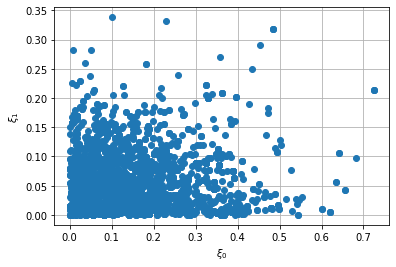

In [101]:
#plt.plot(np.random.normal(loc=0, scale=0.2, size=1000),(np.random.normal(loc=0, scale=0.1, size=1000)),'o')
plt.plot(phi[1000:,0],phi[1000:,1],'o') 
plt.xlabel('$\u03BE_0$')
plt.ylabel('$\u03BE_1$')
plt.grid(True)
#plt.savefig("C10.png", format="png")

#plt.xlim(, 11)
#plt.ylim(-1.5, 1.5);

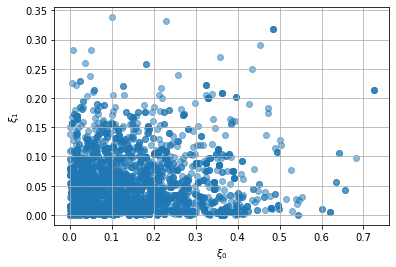

In [148]:
#plt.plot(np.random.normal(loc=0, scale=0.2, size=1000),(np.random.normal(loc=0, scale=0.1, size=1000)),'bo')
plt.scatter(phi[1000:,0],phi[1000:,1],alpha=0.5)
plt.xlabel('$\u03BE_0$')
plt.ylabel('$\u03BE_1$')
plt.grid(True)
#plt.savefig("C10.png", format="png")

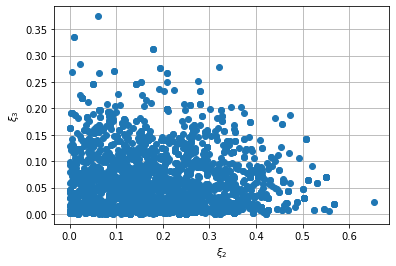

In [102]:
#plt.plot( np.random.normal(loc=0.2, scale=0.1, size=1000),np.random.normal(loc=0, scale=0.1, size=1000),'o')
plt.plot(phi[1000:,2],phi[1000:,3],'o')
plt.xlabel('$\u03BE_2$')
plt.ylabel('$\u03BE_3$')
plt.grid(True)
#plt.savefig("C01.png", format="png") 

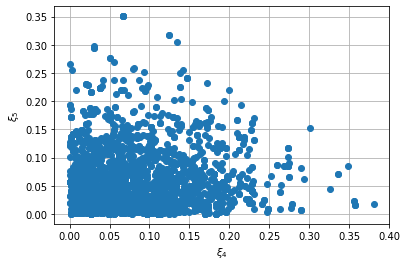

In [103]:
#plt.plot( np.random.normal(loc=0, scale=0.1, size=1000),np.random.normal(loc=0, scale=0.1, size=1000),'o')
plt.plot(phi[1000:,4],phi[1000:,5],'o')
plt.xlabel('$\u03BE_4$')
plt.ylabel('$\u03BE_5$')
plt.grid(True)
#plt.savefig("C11.png", format="png") 

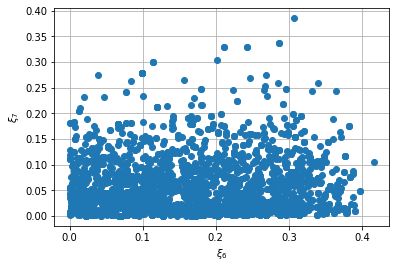

In [104]:
#plt.plot( np.random.normal(loc=0.2, scale=0.031, size=1000),np.random.normal(loc=0, scale=0.1, size=1000),'o')
plt.plot(phi[1000:,6],phi[1000:,7],'o')
plt.xlabel('$\u03BE_6$')
plt.ylabel('$\u03BE_7$')
plt.grid(True)
#plt.savefig("D1.png", format="png") 

In [19]:
def effectiveSampleSize(data, stepSize = 2) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag
  #varGammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 : 
         varStat += 2.0*s
      else :
        break
      
  # standard error of mean
  # stdErrorOfMean = Math.sqrt(varStat/samples);

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess

In [81]:
effectiveSampleSize(phi[1000:,0])/3000,effectiveSampleSize(phi[1000:,1])/3000,effectiveSampleSize(phi[1000:,2])/3000,effectiveSampleSize(phi[1000:,3])/3000,effectiveSampleSize(phi[1000:,4])/3000,effectiveSampleSize(phi[1000:,5])/3000,effectiveSampleSize(phi[1000:,6])/3000,effectiveSampleSize(phi[1000:,7])/3000

(0.14782160608291742,
 0.11649485364172231,
 0.13741577966217913,
 0.14240165887781533,
 0.09112951744990223,
 0.13759264654881959,
 0.1180169107461474,
 0.10254049185672322)

In [80]:
effectiveSampleSize(phi[1000:,0]),effectiveSampleSize(phi[1000:,1]),effectiveSampleSize(phi[1000:,2]),effectiveSampleSize(phi[1000:,3]),effectiveSampleSize(phi[1000:,4]),effectiveSampleSize(phi[1000:,5]),effectiveSampleSize(phi[1000:,6]),effectiveSampleSize(phi[1000:,7])

(443.46481824875224,
 349.48456092516693,
 412.2473389865374,
 427.204976633446,
 273.3885523497067,
 412.7779396464587,
 354.0507322384422,
 307.62147557016965)

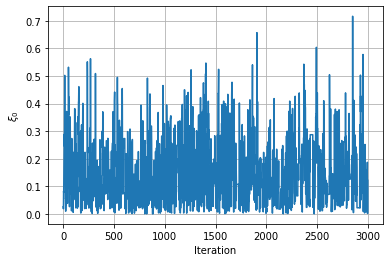

In [63]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,0])
#sns.regplot(np.array(range(0,8000)), As, fit_reg=False,color="g")
#plt.title('Trace-plot by pcN')
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_0$')
plt.grid(True)
plt.savefig("trace_xi_0.png", format="png") 

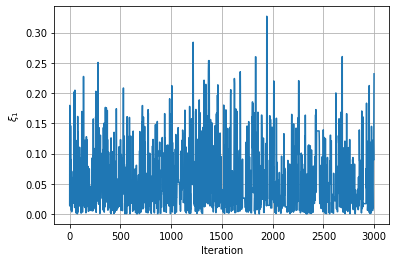

In [64]:
#Trace-plot of xi
plt.plot(np.array(range(0,3000)),phi[1000:,1])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_1$')
plt.grid(True)
plt.savefig("trace_xi_1.png", format="png") 

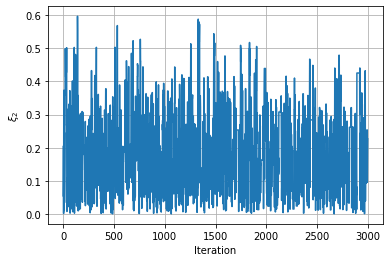

In [65]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,2])

plt.xlabel('Iteration')
plt.ylabel('$\u03BE_2$')
plt.grid(True)
plt.savefig("trace_xi_2.png", format="png") 

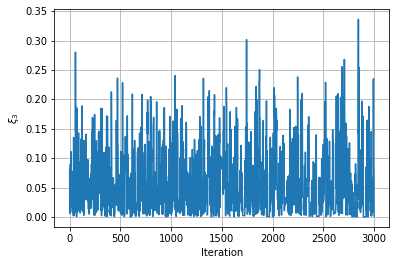

In [66]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,3])

plt.xlabel('Iteration')
plt.ylabel('$\u03BE_3$')
plt.grid(True)
plt.savefig("trace_xi_3.png", format="png") 

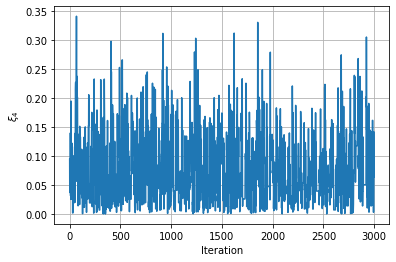

In [67]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,4])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_4$')
plt.grid(True)
plt.savefig("trace_xi_4.png", format="png") 

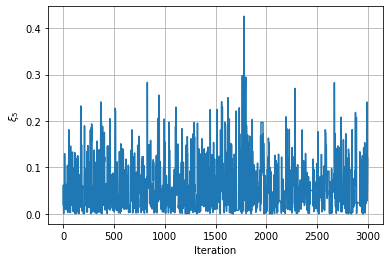

In [68]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,5])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_5$')
plt.grid(True)
plt.savefig("trace_xi_5.png", format="png") 

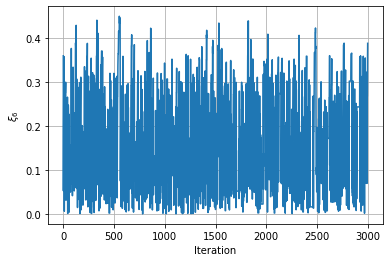

In [69]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,6])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_6$')
plt.grid(True)
plt.savefig("trace_xi_6.png", format="png") 

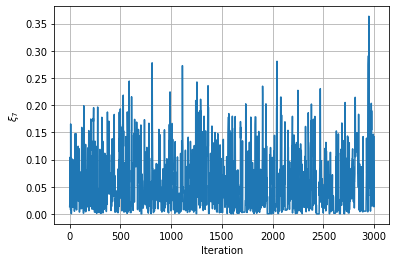

In [70]:
#Trace-plot of As
plt.plot(np.array(range(0,3000)),phi[1000:,7])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_7$')
plt.grid(True)
plt.savefig("trace_xi_7.png", format="png") 

In [72]:
phi0_list=[]
phi1_list=[]
phi2_list=[]
phi3_list=[]
phi4_list=[]
phi5_list=[]
phi6_list=[]
phi7_list=[]
for k in range(0,4):
    ndraws = 4000  # number of draws from the distribution
    phi=np.zeros((ndraws,8))
    prop_phi=np.zeros((ndraws,8))
    sigma1_sq=np.zeros((ndraws,1))
    sigma2_sq=np.zeros((ndraws,1))
    a=[1]
    sigma1_sq[0]=1
    sigma1_sq_it=1
    k=0
    ni=0
    m=1.1
    a_star=0.50
    acceptanceCount=0
    phi[0]=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
    #phi[0]=[0.1,0.1,0.1,0.1,0.1,0.1]
    logLikelihood = myModel.logLike(phi[0])

    for it in range(1,ndraws):
        #prop_phi[it][0]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][0] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))    
        #prop_phi[it][1]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][1] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
        ##prop_phi[it][2]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][2] + 500+sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
        #prop_phi[it][2]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][2] + sigma1_sq_it*float(np.random.normal(loc=5, scale=1.0, size=1))*(-1)**rnd.randrange(1,3)
        #prop_phi[it][3]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][3] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
        #prop_phi[it][4]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][4] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))    
        #prop_phi[it][5]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][5] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
        ##prop_phi[it][6]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][6] + 500+sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))
        #prop_phi[it][6]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][6] + sigma1_sq_it*float(np.random.normal(loc=2, scale=1.0, size=1))*(-1)**rnd.randrange(1,3)
        #prop_phi[it][7]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][7] + sigma1_sq_it*float(truncnorm.rvs(-1,1,size=1))     

        prop_phi[it][0]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][0] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)   
        prop_phi[it][1]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][1] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
        prop_phi[it][2]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][2] + sigma1_sq_it*float(np.random.normal(loc=0.2, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
        prop_phi[it][3]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][3] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
        prop_phi[it][4]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][4] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)    
        prop_phi[it][5]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][5] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)
        prop_phi[it][6]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][6] + sigma1_sq_it*float(np.random.normal(loc=0.2, scale=0.031, size=1))*(-1)**rnd.randrange(1,3)
        prop_phi[it][7]=np.sqrt(1-sigma1_sq_it**2)*phi[it-1][7] + sigma1_sq_it*float(np.random.normal(loc=0, scale=0.1, size=1))*(-1)**rnd.randrange(1,3)     


        prop_phi[it]=abs(prop_phi[it])

        #############################    
    #update the adaptation
        if it>100*(ni+1):
            k=k+1
            ni=ni+1
            #update of sigma_sq
            log_sigma1_sq=np.log(sigma1_sq[k-1]) + m**(-k)*(np.mean(np.array([a]))-a_star)
            sigma1_sq[k]=np.exp(log_sigma1_sq)
            #if sigma1_sq[k]>1:
            #    sigma1_sq[k]=0.99
            sigma1_sq_it=float(sigma1_sq[k]) 

        ##############################

        prop_logLikelihood = myModel.logLike(prop_phi[it])


        alpha= prop_logLikelihood -logLikelihood
        alpha = min(0,alpha)


        if     np.log(rnd.random())<alpha:

               acceptanceCount=acceptanceCount+1
               phi[it]=prop_phi[it]
               logLikelihood=prop_logLikelihood
               a=a+[1]
        else:
               phi[it]=phi[it-1]
               a=a+[0]
    phi0_list.append(phi[:,0])
    phi1_list.append(phi[:,1])
    phi2_list.append(phi[:,2])
    phi3_list.append(phi[:,3])
    phi4_list.append(phi[:,4])
    phi5_list.append(phi[:,5])
    phi6_list.append(phi[:,6])
    phi7_list.append(phi[:,7])

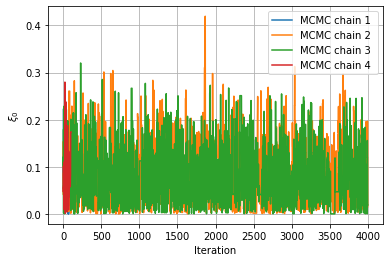

In [92]:
#phi0_list      #lenght 4

plt.plot(np.array(range(0,4000)),phi0_list[0])
plt.plot(np.array(range(0,4000)),phi0_list[1])
plt.plot(np.array(range(0,4000)),phi0_list[2])
plt.plot(np.array(range(0,4000)),phi0_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_0$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi0.png", format="png")

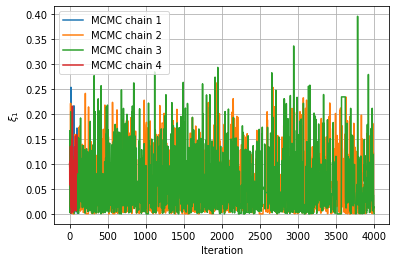

In [93]:
plt.plot(np.array(range(0,4000)),phi1_list[0])
plt.plot(np.array(range(0,4000)),phi1_list[1])
plt.plot(np.array(range(0,4000)),phi1_list[2])
plt.plot(np.array(range(0,4000)),phi1_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_1$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi1.png", format="png")

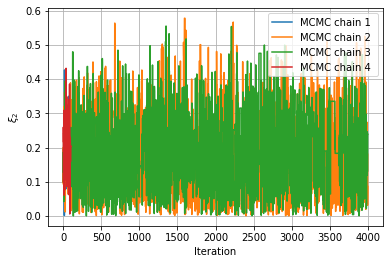

In [94]:
plt.plot(np.array(range(0,4000)),phi2_list[0])
plt.plot(np.array(range(0,4000)),phi2_list[1])
plt.plot(np.array(range(0,4000)),phi2_list[2])
plt.plot(np.array(range(0,4000)),phi2_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_2$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi2.png", format="png")

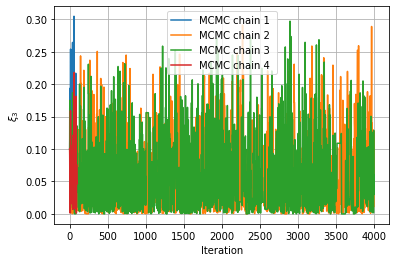

In [95]:
plt.plot(np.array(range(0,4000)),phi3_list[0])
plt.plot(np.array(range(0,4000)),phi3_list[1])
plt.plot(np.array(range(0,4000)),phi3_list[2])
plt.plot(np.array(range(0,4000)),phi3_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_3$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi3.png", format="png")

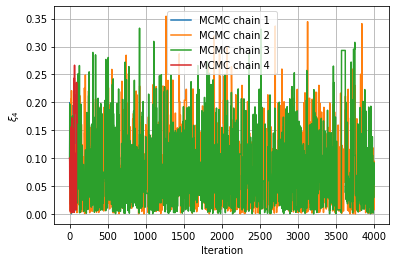

In [96]:
plt.plot(np.array(range(0,4000)),phi4_list[0])
plt.plot(np.array(range(0,4000)),phi4_list[1])
plt.plot(np.array(range(0,4000)),phi4_list[2])
plt.plot(np.array(range(0,4000)),phi4_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_4$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi4.png", format="png")

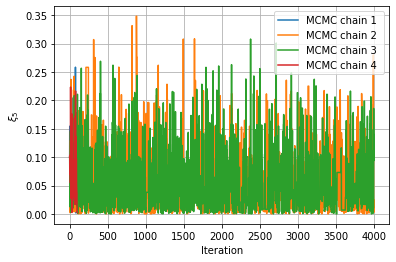

In [97]:
plt.plot(np.array(range(0,4000)),phi5_list[0])
plt.plot(np.array(range(0,4000)),phi5_list[1])
plt.plot(np.array(range(0,4000)),phi5_list[2])
plt.plot(np.array(range(0,4000)),phi5_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_5$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi5.png", format="png")

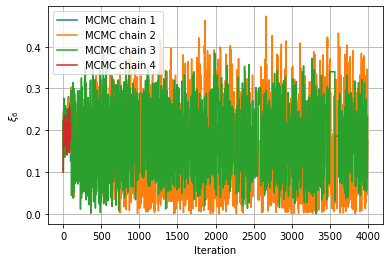

In [98]:
plt.plot(np.array(range(0,4000)),phi6_list[0])
plt.plot(np.array(range(0,4000)),phi6_list[1])
plt.plot(np.array(range(0,4000)),phi6_list[2])
plt.plot(np.array(range(0,4000)),phi6_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_6$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi6.png", format="png")

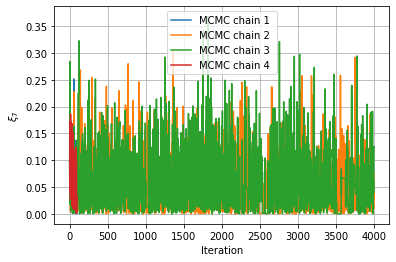

In [99]:
plt.plot(np.array(range(0,4000)),phi7_list[0])
plt.plot(np.array(range(0,4000)),phi7_list[1])
plt.plot(np.array(range(0,4000)),phi7_list[2])
plt.plot(np.array(range(0,4000)),phi7_list[3])
plt.xlabel('Iteration')
plt.ylabel('$\u03BE_7$')
plt.grid(True)
plt.legend(labels = ['MCMC chain 1 ','MCMC chain 2','MCMC chain 3','MCMC chain 4'])
plt.savefig("trace_4chain_xi7.png", format="png")

## Validation

## K-Fold validation

In [212]:
pointer = 1*myModel.validate_number
X_fold_1 = myModel.X_init[myModel.validate_number:]
Y_fold_1 = myModel.Y_init[myModel.validate_number:]
K_fold_1 = GPy.models.GPRegression(X=X_fold_1, Y=Y_fold_1,kernel=GPy.kern.RBF(input_dim=myModel.X_init.shape[1], ARD=True))
K_fold_1.optimize(messages=True)
K_fold_1.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -3074.6032992966084
Optimization restart 2/3, f = -3074.6032979120882
Optimization restart 3/3, f = -3074.6032983228547


In [219]:
misfit = np.zeros(myModel.validate_number)
for i in range(0,myModel.validate_number):
        theta = myModel.X_init[i,:]
        gp_value=np.reshape(theta,(1,-1))
        prediction = K_fold_1.predict(gp_value)
        misfit[i] = (prediction[0]- myModel.Y_init[i])**2
train_error = sum(misfit)/(myModel.validate_number) 
K1 = train_error

## 2-Cell

In [201]:
pointer = 2*myModel.validate_number
X_fold_2 = np.concatenate((myModel.X_init[0:myModel.validate_number],myModel.X_init[pointer:]))
Y_fold_2 = np.concatenate((myModel.Y_init[0:myModel.validate_number],myModel.Y_init[pointer:]))
K_fold_2 = GPy.models.GPRegression(X=X_fold_2, Y=Y_fold_2,kernel=GPy.kern.RBF(input_dim=myModel.X_init.shape[1], ARD=True))
K_fold_2.optimize(messages=True)
K_fold_2.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -3081.5918528748066
Optimization restart 2/3, f = -3081.591949837401
Optimization restart 3/3, f = -3081.788762924511


In [220]:
j=0
misfit = np.zeros(myModel.validate_number)
for i in range(myModel.validate_number,2*myModel.validate_number):
        theta = X_fold_2[i,:]
        gp_value=np.reshape(theta,(1,-1))
        prediction = K_fold_2.predict(gp_value)
        misfit[j] = (prediction[0]- Y_fold_2[i])**2
        j=j+1
train_error = sum(misfit)/(myModel.validate_number) 
K2 =train_error

## 3-Cell

In [203]:
pointer = 3*myModel.validate_number
X_fold_3 = np.concatenate((myModel.X_init[0:2*myModel.validate_number],myModel.X_init[pointer:]))
Y_fold_3 = np.concatenate((myModel.Y_init[0:2*myModel.validate_number],myModel.Y_init[pointer:]))
K_fold_3 = GPy.models.GPRegression(X=X_fold_3, Y=Y_fold_3,kernel=GPy.kern.RBF(input_dim=myModel.X_init.shape[1], ARD=True))
K_fold_3.optimize(messages=True)
K_fold_3.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -3029.8343419921516
Optimization restart 2/3, f = -3029.834341976459
Optimization restart 3/3, f = -3029.8343410800385


In [221]:
j=0
misfit = np.zeros(myModel.validate_number)
for i in range(myModel.validate_number,2*myModel.validate_number):
        theta = X_fold_3[i,:]
        gp_value=np.reshape(theta,(1,-1))
        prediction = K_fold_3.predict(gp_value)
        misfit[j] = (prediction[0]- Y_fold_3[i])**2
        j=j+1
train_error = sum(misfit)/(myModel.validate_number) 
K3 =train_error

## 4-Cell

In [205]:
pointer = 4*myModel.validate_number
X_fold_4 = np.concatenate((myModel.X_init[0:3*myModel.validate_number],myModel.X_init[pointer:]))
Y_fold_4 = np.concatenate((myModel.Y_init[0:3*myModel.validate_number],myModel.Y_init[pointer:]))
K_fold_4 = GPy.models.GPRegression(X=X_fold_4, Y=Y_fold_4,kernel=GPy.kern.RBF(input_dim=myModel.X_init.shape[1], ARD=True))
K_fold_4.optimize(messages=True)
K_fold_4.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -3069.9442930175514
Optimization restart 2/3, f = -3068.4402421840164
Optimization restart 3/3, f = -3069.944293879446


In [222]:
j=0
misfit = np.zeros(myModel.validate_number)
for i in range(2*myModel.validate_number,3*myModel.validate_number):
        theta = X_fold_4[i,:]
        gp_value=np.reshape(theta,(1,-1))
        prediction = K_fold_4.predict(gp_value)
        misfit[j] = (prediction[0]- Y_fold_4[i])**2
        j=j+1
train_error = sum(misfit)/(myModel.validate_number) 
K4 =train_error

## 5-Cell

In [215]:
pointer = 5*myModel.validate_number
X_fold_5 = np.concatenate((myModel.X_init[0:4*myModel.validate_number],myModel.X_init[pointer:]))
Y_fold_5 = np.concatenate((myModel.Y_init[0:4*myModel.validate_number],myModel.Y_init[pointer:]))
K_fold_5 = GPy.models.GPRegression(X=X_fold_5, Y=Y_fold_5,kernel=GPy.kern.RBF(input_dim=myModel.X_init.shape[1], ARD=True))
K_fold_5.optimize(messages=True)
K_fold_5.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -3037.6752054158947
Optimization restart 2/3, f = -3037.675205701279
Optimization restart 3/3, f = -3037.675205695981


In [217]:
j=0
misfit = np.zeros(myModel.validate_number)
for i in range(3*myModel.validate_number,4*myModel.validate_number):
        theta = X_fold_5[i,:]
        gp_value=np.reshape(theta,(1,-1))
        prediction = K_fold_5.predict(gp_value)
        misfit[j] = (prediction[0]- Y_fold_5[i])**2
        j=j+1
train_error = sum(misfit)/(myModel.validate_number) 
K5 = train_error
K5

1.185118188112932e-08

In [223]:
(K1+K2+K3+K4+K5)/5

8.36745319313913e-07